In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install imbalanced-learn
!pip install matplotlib
!pip install seaborn
!pip install joblib
!pip install tqdm
!pip install torch
!pip install tabulate
!pip install psutil
!pip install umap-learn
!pip install scikit-learn
!pip install shap

# SETUP AND IMPORTS

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import sys

In [3]:
# 1. Reading dataset
print("Reading dataset...")
train_data_original = pd.read_csv("/kaggle/input/unswnb15/UNSW_NB15_training-set.csv")
test_data = pd.read_csv("/kaggle/input/unswnb15/UNSW_NB15_testing-set.csv")

print(f"Training set shape (original): {train_data_original.shape}")
print(f"Testing set shape: {test_data.shape}")

# 1b. APPROACH #2: Removing Fuzzers and Reconnaissance attacks from training data only
print("\nRemoving zero-day categories (Fuzzers and Reconnaissance) from training data...")
print("Attack category distribution before removal:")
print(train_data_original['attack_cat'].value_counts())

# Remove zero-day attack categories from training data
train_data = train_data_original[~train_data_original['attack_cat'].isin(['Fuzzers', 'Reconnaissance'])]
print(f"\nNumber of training data after removal: {len(train_data)}")
print(f"Number of zero-day data removed: {len(train_data_original) - len(train_data)}")

# Distribution after removal
print("\nAttack category distribution after removal:")
print(train_data['attack_cat'].value_counts())

Reading dataset...
Training set shape (original): (175341, 45)
Testing set shape: (82332, 45)

Removing zero-day categories (Fuzzers and Reconnaissance) from training data...
Attack category distribution before removal:
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

Number of training data after removal: 146666
Number of zero-day data removed: 28675

Attack category distribution after removal:
attack_cat
Normal       56000
Generic      40000
Exploits     33393
DoS          12264
Analysis      2000
Backdoor      1746
Shellcode     1133
Worms          130
Name: count, dtype: int64


# Pre Processing

In [4]:
# 2. Checking dataset information
print("\nTraining dataset information after zero-day removal:")
print(train_data.info())
print("\nDescriptive statistics of training dataset:")
print(train_data.describe())


Training dataset information after zero-day removal:
<class 'pandas.core.frame.DataFrame'>
Index: 146666 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 146666 non-null  int64  
 1   dur                146666 non-null  float64
 2   proto              146666 non-null  object 
 3   service            146666 non-null  object 
 4   state              146666 non-null  object 
 5   spkts              146666 non-null  int64  
 6   dpkts              146666 non-null  int64  
 7   sbytes             146666 non-null  int64  
 8   dbytes             146666 non-null  int64  
 9   rate               146666 non-null  float64
 10  sttl               146666 non-null  int64  
 11  dttl               146666 non-null  int64  
 12  sload              146666 non-null  float64
 13  dload              146666 non-null  float64
 14  sloss              146666 non-null  int64  
 15  dl

In [5]:
# 3. Handling missing values
print("\nChecking missing values...")
print(f"Missing values in training set:\n{train_data.isnull().sum()}")
print(f"Missing values in testing set:\n{test_data.isnull().sum()}")

# Fill missing values with mean
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
train_data[numeric_columns] = imputer.fit_transform(train_data[numeric_columns])
test_data[numeric_columns] = imputer.transform(test_data[numeric_columns])


Checking missing values...
Missing values in training set:
id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm          

In [6]:
# 4. Handling duplicate data
print("\nChecking duplicate data...")
print(f"Number of duplicate data in training set: {train_data.duplicated().sum()}")
print(f"Number of duplicate data in testing set: {test_data.duplicated().sum()}")

# Remove duplicates if any
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()


Checking duplicate data...
Number of duplicate data in training set: 0
Number of duplicate data in testing set: 0


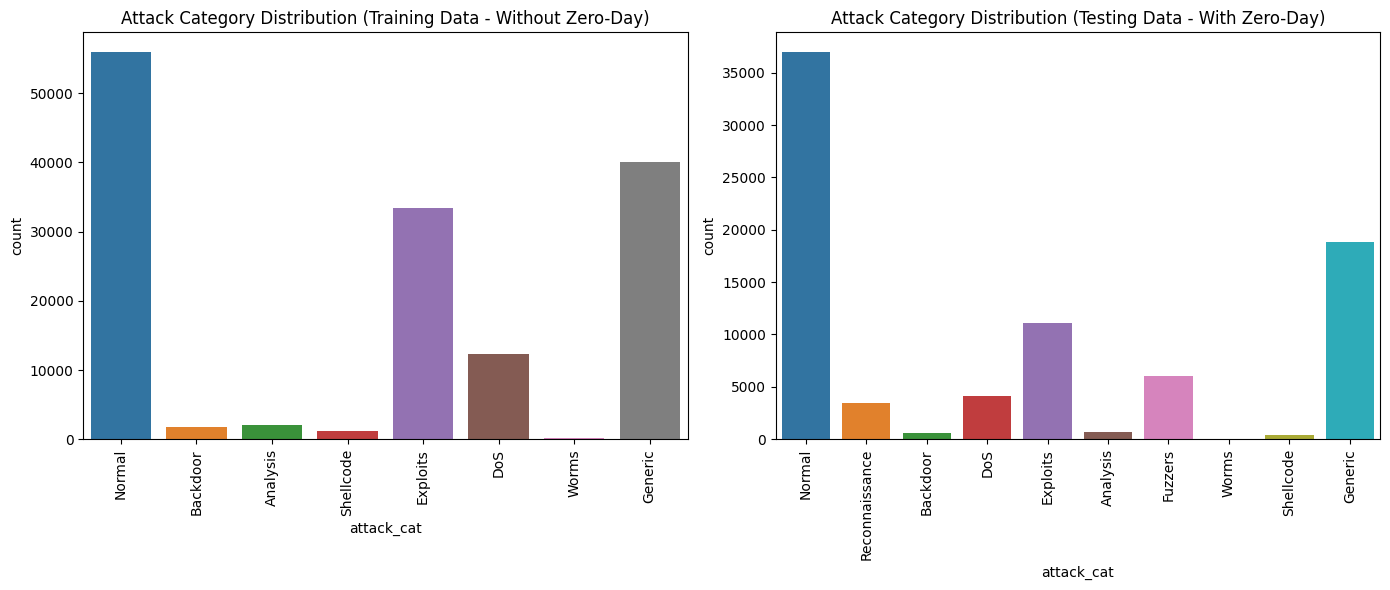

In [7]:
# 5. Class distribution visualization
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='attack_cat', data=train_data)
plt.title('Attack Category Distribution (Training Data - Without Zero-Day)')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.countplot(x='attack_cat', data=test_data)
plt.title('Attack Category Distribution (Testing Data - With Zero-Day)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# 6. APPROACH #2: Create specific dataset for zero-day evaluation
print("\nPreparing subset data for zero-day evaluation...")

# Create a subset of test data containing only zero-day attacks and normal traffic
zero_day_attacks = test_data[test_data['attack_cat'].isin(['Fuzzers', 'Reconnaissance'])]
zero_day_attacks_count = len(zero_day_attacks)
print(f"Number of zero-day attacks (Fuzzers & Reconnaissance) in test set: {zero_day_attacks_count}")

# Add normal traffic for more realistic evaluation
normal_traffic = test_data[test_data['label'] == 0]
normal_traffic_count = len(normal_traffic)
print(f"Number of normal traffic in test set: {normal_traffic_count}")

# Combine to create a specific zero-day evaluation dataset
zero_day_test_data = pd.concat([zero_day_attacks, normal_traffic])
zero_day_test_data = zero_day_test_data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"Zero-day evaluation dataset created with {len(zero_day_test_data)} total samples")
print(f"Proportions in zero-day evaluation dataset - Normal: {sum(zero_day_test_data['label'] == 0)/len(zero_day_test_data):.2%}, "
      f"Attack: {sum(zero_day_test_data['label'] == 1)/len(zero_day_test_data):.2%}")

# Save zero-day evaluation dataset
zero_day_test_data.to_csv('zero_day_test_data.csv', index=False)

# Add distribution information in zero-day evaluation dataset
print("\nAttack distribution in zero-day evaluation dataset:")
zero_day_attack_dist = zero_day_test_data[zero_day_test_data['label'] == 1]['attack_cat'].value_counts()
for attack_type, count in zero_day_attack_dist.items():
    print(f"- {attack_type}: {count} samples ({count/sum(zero_day_test_data['label'] == 1):.2%})")


Preparing subset data for zero-day evaluation...
Number of zero-day attacks (Fuzzers & Reconnaissance) in test set: 9558
Number of normal traffic in test set: 37000
Zero-day evaluation dataset created with 46558 total samples
Proportions in zero-day evaluation dataset - Normal: 79.47%, Attack: 20.53%

Attack distribution in zero-day evaluation dataset:
- Fuzzers: 6062 samples (63.42%)
- Reconnaissance: 3496 samples (36.58%)


In [9]:
# 7. Separating features and targets
X_train = train_data.drop(['id', 'label', 'attack_cat'], axis=1)
y_train_binary = train_data['label']
y_train_multi = train_data['attack_cat']

X_test = test_data.drop(['id', 'label', 'attack_cat'], axis=1)
y_test_binary = test_data['label']
y_test_multi = test_data['attack_cat']

X_zero_day = zero_day_test_data.drop(['id', 'label', 'attack_cat'], axis=1)
y_zero_day_binary = zero_day_test_data['label']
y_zero_day_multi = zero_day_test_data['attack_cat']

In [10]:
# 8. Preprocessing categorical features
print("\nEncoding categorical features...")
categorical_columns = X_train.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    # Get all unique values from train, test and zero_day
    all_values = set(X_train[col].astype(str).unique()).union(
                 set(X_test[col].astype(str).unique())).union(
                 set(X_zero_day[col].astype(str).unique()))
    
    # Create mapping dictionary
    value_map = {val: idx for idx, val in enumerate(all_values)}
    
    # Apply mapping to all datasets
    X_train[col] = X_train[col].astype(str).map(value_map)
    X_test[col] = X_test[col].astype(str).map(value_map)
    X_zero_day[col] = X_zero_day[col].astype(str).map(value_map)
    
    # Save mapping for future use
    label_encoders[col] = value_map


Encoding categorical features...


In [11]:
# 9. Encoding multi-class target
print("\nEncoding multi-class target...")
le_attack = LabelEncoder()
# Make sure encoder includes all categories by fitting on combined train and test
all_attack_categories = np.concatenate([y_train_multi.astype(str), y_test_multi.astype(str)])
le_attack.fit(all_attack_categories)

# Transform training and testing data
y_train_multi_encoded = le_attack.transform(y_train_multi.astype(str))
y_test_multi_encoded = le_attack.transform(y_test_multi.astype(str))
y_zero_day_multi_encoded = le_attack.transform(y_zero_day_multi.astype(str))

print(f"Attack category mapping: {dict(zip(le_attack.classes_, range(len(le_attack.classes_))))}")


Encoding multi-class target...
Attack category mapping: {'Analysis': 0, 'Backdoor': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [12]:
# 10. Handling Class Imbalance - New correct method
print("\n*** Handling Class Imbalance ***")
print("Class distribution before resampling:")
print(f"  - Normal (0): {sum(y_train_binary == 0)}")
print(f"  - Attack (1): {sum(y_train_binary == 1)}")
print(f"  - Attack/normal ratio: {sum(y_train_binary == 1) / sum(y_train_binary == 0):.4f}")

# BETTER APPROACH: Add attack_cat as additional column to be resampled together
# 10.1 SMOTE
print("\nPerforming SMOTE resampling...")
# Create DataFrame with features and labels
X_train_with_cat = X_train.copy()
X_train_with_cat['attack_cat'] = y_train_multi_encoded  # Add attack_cat as additional feature

# Perform SMOTE
smote = SMOTE(random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_train_with_cat, y_train_binary)

# Extract attack_cat back from resampling results
y_multi_smote_resampled = X_smote_resampled['attack_cat'].values
X_smote_resampled = X_smote_resampled.drop('attack_cat', axis=1)

print("\nClass distribution after SMOTE:")
print(f"  - Normal (0): {sum(y_smote_resampled == 0)}")
print(f"  - Attack (1): {sum(y_smote_resampled == 1)}")
print(f"  - Attack/normal ratio: {sum(y_smote_resampled == 1) / sum(y_smote_resampled == 0):.4f}")

# 10.2 Random Undersampling
print("\nPerforming Random Under-sampling...")
# Create DataFrame with features and multi-class labels
X_train_with_cat = X_train.copy()
X_train_with_cat['attack_cat'] = y_train_multi_encoded

# Perform undersampling
rus = RandomUnderSampler(random_state=42)
X_rus_resampled, y_rus_resampled = rus.fit_resample(X_train_with_cat, y_train_binary)

# Extract attack_cat back from resampling results
y_multi_rus_resampled = X_rus_resampled['attack_cat'].values
X_rus_resampled = X_rus_resampled.drop('attack_cat', axis=1)

print("\nClass distribution after Random Under-sampling:")
print(f"  - Normal (0): {sum(y_rus_resampled == 0)}")
print(f"  - Attack (1): {sum(y_rus_resampled == 1)}")
print(f"  - Attack/normal ratio: {sum(y_rus_resampled == 1) / sum(y_rus_resampled == 0):.4f}")

# 10.3 SMOTETomek (combination)
print("\nPerforming SMOTE+Tomek resampling...")
# Create DataFrame with features and multi-class labels
X_train_with_cat = X_train.copy()
X_train_with_cat['attack_cat'] = y_train_multi_encoded

# Perform SMOTE+Tomek
smt = SMOTETomek(random_state=42)
X_smt_resampled, y_smt_resampled = smt.fit_resample(X_train_with_cat, y_train_binary)

# Extract attack_cat back from resampling results
y_multi_smt_resampled = X_smt_resampled['attack_cat'].values
X_smt_resampled = X_smt_resampled.drop('attack_cat', axis=1)

print("\nClass distribution after SMOTE+Tomek:")
print(f"  - Normal (0): {sum(y_smt_resampled == 0)}")
print(f"  - Attack (1): {sum(y_smt_resampled == 1)}")
print(f"  - Attack/normal ratio: {sum(y_smt_resampled == 1) / sum(y_smt_resampled == 0):.4f}")

# Default: use SMOTE+Tomek as the main resampling method
X_train_resampled = X_smt_resampled
y_train_binary_resampled = y_smt_resampled
y_train_multi_resampled = y_multi_smt_resampled


*** Handling Class Imbalance ***
Class distribution before resampling:
  - Normal (0): 56000
  - Attack (1): 90666
  - Attack/normal ratio: 1.6190

Performing SMOTE resampling...

Class distribution after SMOTE:
  - Normal (0): 90666
  - Attack (1): 90666
  - Attack/normal ratio: 1.0000

Performing Random Under-sampling...

Class distribution after Random Under-sampling:
  - Normal (0): 56000
  - Attack (1): 56000
  - Attack/normal ratio: 1.0000

Performing SMOTE+Tomek resampling...

Class distribution after SMOTE+Tomek:
  - Normal (0): 86709
  - Attack (1): 86709
  - Attack/normal ratio: 1.0000


In [13]:
# 11. Normalizing numerical features
print("\nNormalizing numerical features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_zero_day_scaled = scaler.transform(X_zero_day)


Normalizing numerical features...



Analyzing correlation between features...


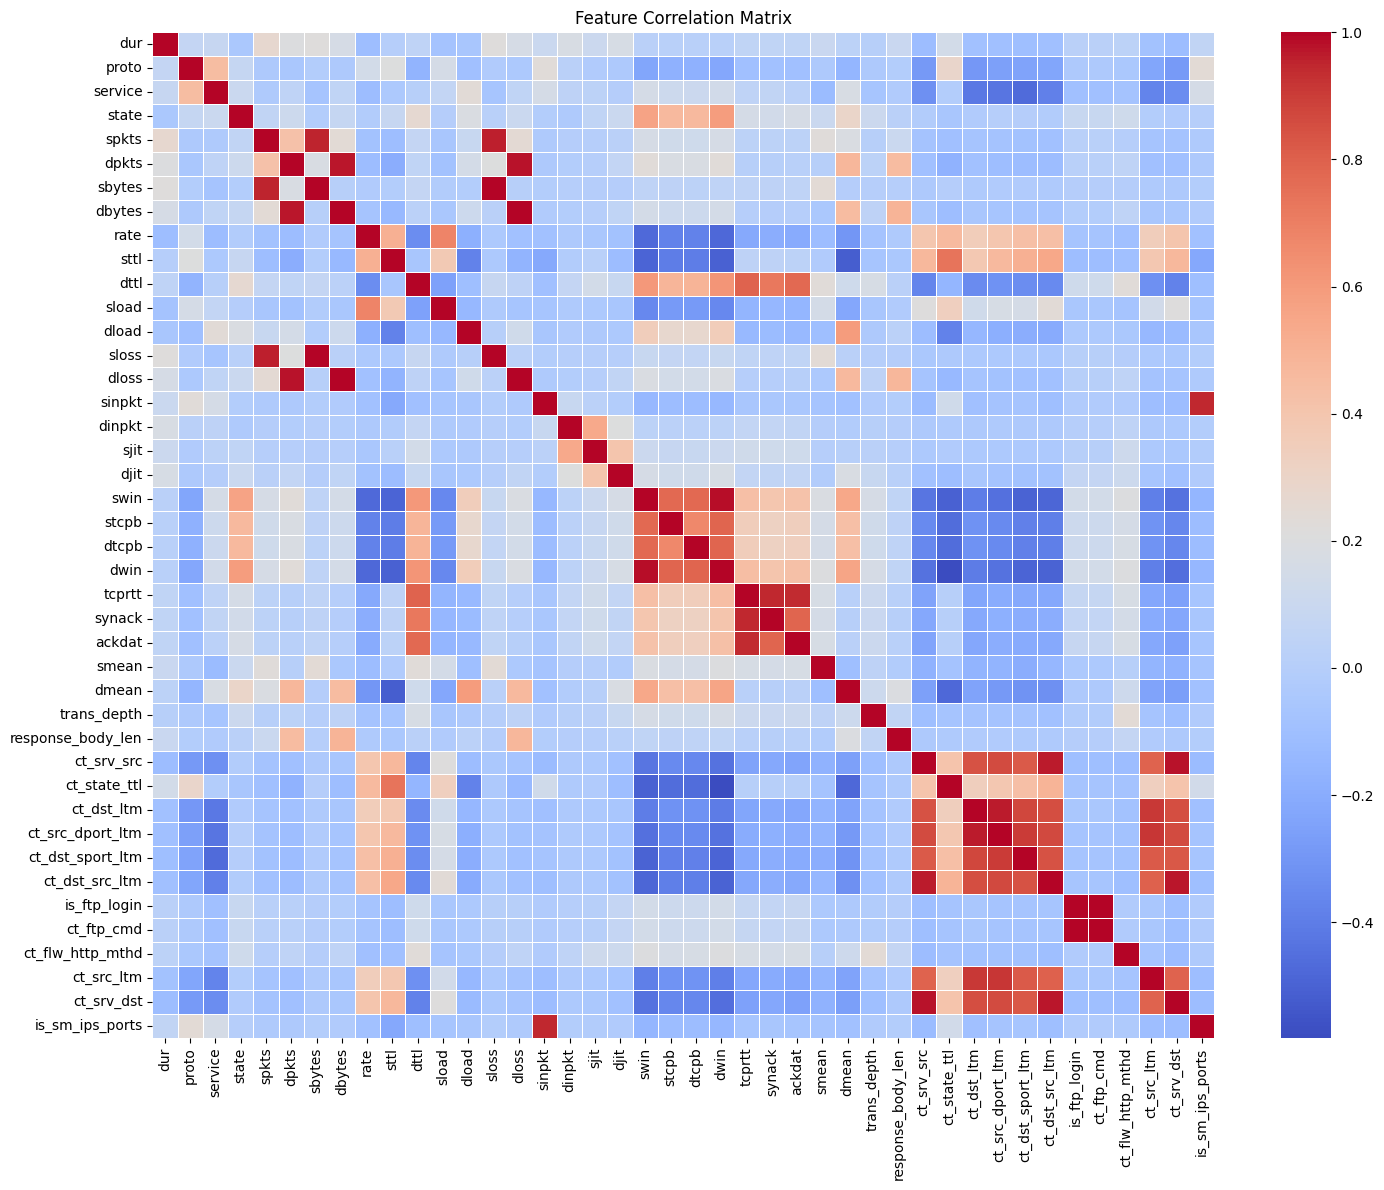


Features with high correlation (>0.9):
spkts - sbytes: 0.9511384897091276
spkts - sloss: 0.9624408292997997
dpkts - dbytes: 0.9704690134321285
dpkts - dloss: 0.9796464722302097
sbytes - sloss: 0.9954691353237879
dbytes - dloss: 0.9955652252932709
sinpkt - is_sm_ips_ports: 0.9479944573897799
swin - dwin: 0.9837556922889661
tcprtt - synack: 0.9502200258848531
tcprtt - ackdat: 0.9392236855588633
ct_srv_src - ct_dst_src_ltm: 0.9668428342477019
ct_srv_src - ct_srv_dst: 0.9794980949541514
ct_dst_ltm - ct_src_dport_ltm: 0.9647475523558535
ct_dst_ltm - ct_src_ltm: 0.910421123251622
ct_src_dport_ltm - ct_dst_sport_ltm: 0.9065251612443526
ct_src_dport_ltm - ct_src_ltm: 0.9152009691745326
ct_dst_src_ltm - ct_srv_dst: 0.970239333195546
is_ftp_login - ct_ftp_cmd: 1.0

Removing 13 highly correlated features:
- ct_dst_src_ltm
- spkts
- dpkts
- dloss
- dwin
- ct_src_dport_ltm
- ct_srv_dst
- tcprtt
- ct_dst_ltm
- ct_ftp_cmd
- sinpkt
- sloss
- ct_dst_sport_ltm
Number of features after high correlation 

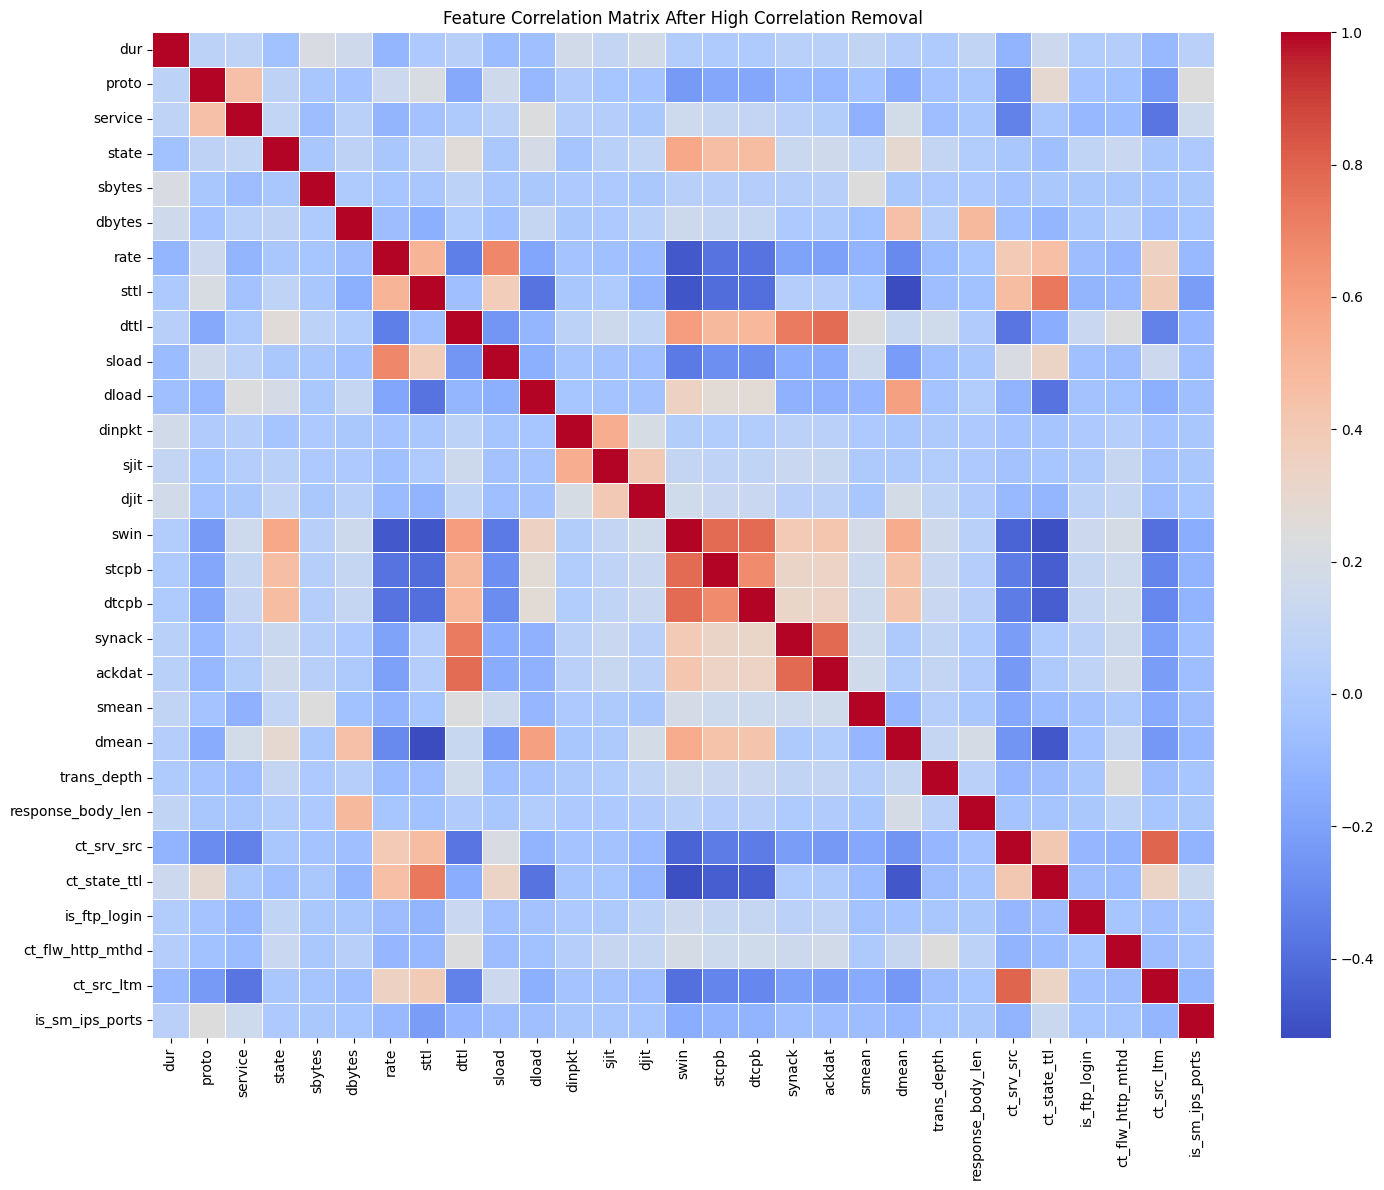

In [14]:
# 12. Correlation analysis and removal of highly correlated features
print("\nAnalyzing correlation between features...")
# Use X_train_resampled, not X_train
correlation_matrix = pd.DataFrame(X_train_resampled).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Detect and remove features with high correlation (>0.9)
high_corr_features = []
high_corr_values = []
features_to_drop = set()

print("\nFeatures with high correlation (>0.9):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            high_corr_features.append((feat1, feat2))
            corr_value = correlation_matrix.iloc[i, j]
            high_corr_values.append(corr_value)
            print(f"{feat1} - {feat2}: {corr_value}")
            
            # Strategy: Remove feature with higher mean absolute correlation with all other features
            mean_corr1 = correlation_matrix[feat1].abs().mean()
            mean_corr2 = correlation_matrix[feat2].abs().mean()
            
            if mean_corr1 > mean_corr2:
                features_to_drop.add(feat1)
            else:
                features_to_drop.add(feat2)

# Remove features from dataset
print(f"\nRemoving {len(features_to_drop)} highly correlated features:")
for feature in features_to_drop:
    print(f"- {feature}")

# Remove features from resampled dataset
X_train_reduced = pd.DataFrame(X_train_resampled).drop(columns=list(features_to_drop))
X_test_reduced = X_test.drop(columns=list(features_to_drop))
X_zero_day_reduced = X_zero_day.drop(columns=list(features_to_drop))
print(f"Number of features after high correlation removal: {X_train_reduced.shape[1]} (from {X_train_resampled.shape[1]} initial features)")

# Normalize remaining features
print("\nNormalizing features after high correlation removal...")
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)
X_zero_day_reduced_scaled = scaler_reduced.transform(X_zero_day_reduced)

# Visualize correlation matrix after removal
plt.figure(figsize=(15, 12))
correlation_matrix_reduced = X_train_reduced.corr()
sns.heatmap(correlation_matrix_reduced, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix After High Correlation Removal')
plt.tight_layout()
plt.show()

In [15]:
# 13. Feature selection with SelectKBest on already reduced features
print("\nFeature selection using SelectKBest...")
k_best = min(20, X_train_reduced.shape[1])  # Number of features to retain
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_reduced_scaled, y_train_binary_resampled)
X_test_selected = selector.transform(X_test_reduced_scaled)
X_zero_day_selected = selector.transform(X_zero_day_reduced_scaled)

# Getting selected features
selected_features = X_train_reduced.columns[selector.get_support()]
print(f"Selected features ({k_best}):")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Get and display feature scores
feature_scores = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print("\nTop features based on score:")
print(feature_scores.head(k_best))


Feature selection using SelectKBest...
Selected features (20):
1. proto
2. service
3. state
4. dbytes
5. rate
6. sttl
7. sload
8. dload
9. dinpkt
10. sjit
11. djit
12. swin
13. stcpb
14. dtcpb
15. smean
16. dmean
17. ct_srv_src
18. ct_state_ttl
19. ct_src_ltm
20. is_sm_ips_ports

Top features based on score:
            Feature          Score        P-value
7              sttl  165873.838660   0.000000e+00
24     ct_state_ttl  107770.548499   0.000000e+00
14             swin   45245.967223   0.000000e+00
6              rate   44183.135880   0.000000e+00
27       ct_src_ltm   29433.505407   0.000000e+00
23       ct_srv_src   27280.528314   0.000000e+00
10            dload   24702.092836   0.000000e+00
15            stcpb   23995.153281   0.000000e+00
16            dtcpb   23542.029758   0.000000e+00
20            dmean   22861.115825   0.000000e+00
2           service   13864.171593   0.000000e+00
1             proto   11257.085060   0.000000e+00
9             sload   11083.302593   0.


Visualizing attack category distribution...


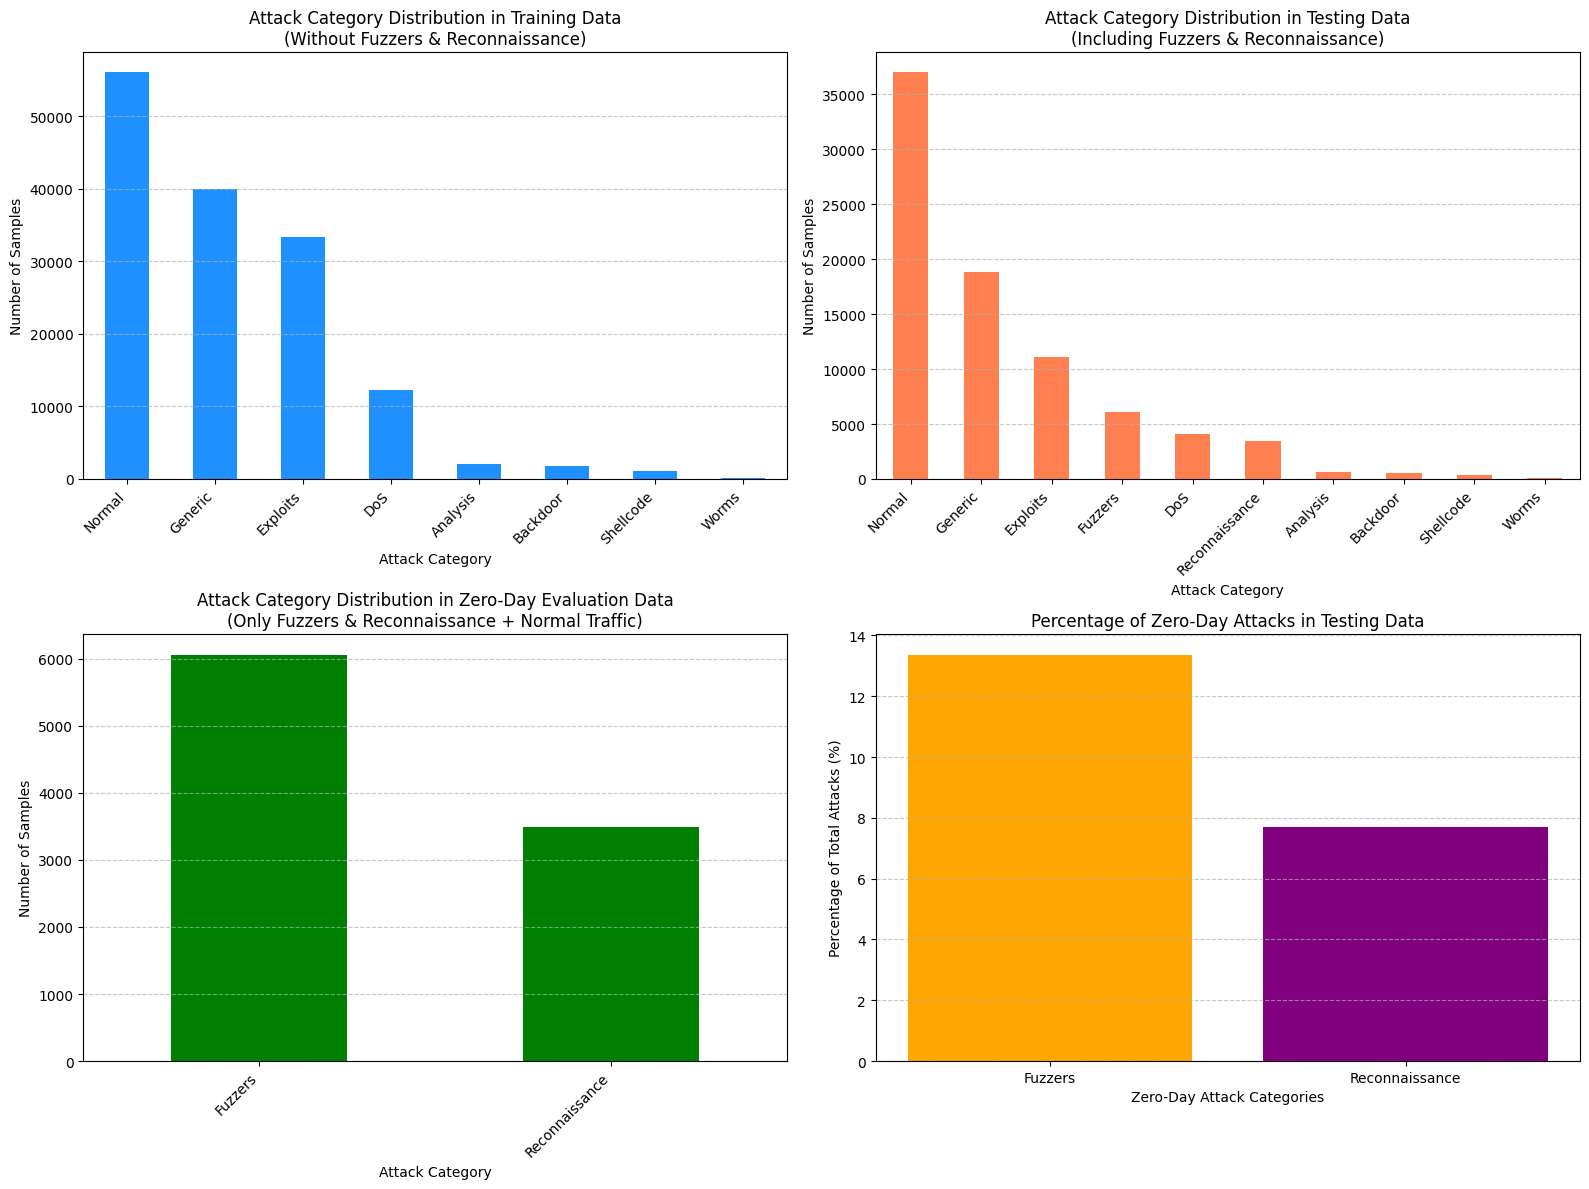

In [16]:
# 14. Visualizing attack category distribution
print("\nVisualizing attack category distribution...")
plt.figure(figsize=(16, 12))

# Plot 1: Attack category distribution in training data (without zero-day)
plt.subplot(2, 2, 1)
train_attack_dist = train_data['attack_cat'].value_counts()
train_attack_dist.plot(kind='bar', color='dodgerblue')
plt.title('Attack Category Distribution in Training Data\n(Without Fuzzers & Reconnaissance)', fontsize=12)
plt.xlabel('Attack Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Attack category distribution in testing data (with zero-day)
plt.subplot(2, 2, 2)
test_attack_dist = test_data['attack_cat'].value_counts()
test_attack_dist.plot(kind='bar', color='coral')
plt.title('Attack Category Distribution in Testing Data\n(Including Fuzzers & Reconnaissance)', fontsize=12)
plt.xlabel('Attack Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Attack category distribution in zero-day evaluation data
plt.subplot(2, 2, 3)
zero_day_attack_dist = zero_day_test_data[zero_day_test_data['label'] == 1]['attack_cat'].value_counts()
zero_day_attack_dist.plot(kind='bar', color='green')
plt.title('Attack Category Distribution in Zero-Day Evaluation Data\n(Only Fuzzers & Reconnaissance + Normal Traffic)', fontsize=12)
plt.xlabel('Attack Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Comparison of zero-day attack categories between train (none) and test
plt.subplot(2, 2, 4)

# Calculate percentage of zero-day categories in test
zero_day_categories = ['Fuzzers', 'Reconnaissance']
zero_day_counts = test_data[test_data['attack_cat'].isin(zero_day_categories)]['attack_cat'].value_counts()
total_attacks = sum(test_data['label'] == 1)
zero_day_percentages = (zero_day_counts / total_attacks * 100).reindex(zero_day_categories)

# Plot percentages
plt.bar(zero_day_percentages.index, zero_day_percentages.values, color=['orange', 'purple'])
plt.title('Percentage of Zero-Day Attacks in Testing Data', fontsize=12)
plt.xlabel('Zero-Day Attack Categories')
plt.ylabel('Percentage of Total Attacks (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('attack_category_distribution_approach2.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# 15. Saving preprocessed datasets
print("\nSaving preprocessed datasets...")

# 15.1 Binary classification datasets
binary_train_data = pd.DataFrame(X_train_selected)
binary_train_data['label'] = y_train_binary_resampled
binary_train_data['attack_cat'] = y_train_multi_resampled  # Save attack_cat for analysis
binary_train_data.to_csv('preprocessed_binary_train.csv', index=False)
print("- Saved preprocessed_binary_train.csv")

binary_test_data = pd.DataFrame(X_test_selected)
binary_test_data['label'] = y_test_binary.values
binary_test_data['attack_cat'] = y_test_multi_encoded  # Save attack_cat for analysis
binary_test_data.to_csv('preprocessed_binary_test.csv', index=False)
print("- Saved preprocessed_binary_test.csv")

# 15.2 Zero-day evaluation dataset
zero_day_eval_selected = pd.DataFrame(X_zero_day_selected)
zero_day_eval_selected['label'] = y_zero_day_binary.values
zero_day_eval_selected['attack_cat'] = y_zero_day_multi_encoded  # Save attack_cat for analysis
zero_day_eval_selected.to_csv('preprocessed_zero_day_test.csv', index=False)
print("- Saved preprocessed_zero_day_test.csv")

# 15.3 Multi-class classification datasets
print("\nSaving multi-class classification datasets...")
multi_train_data = pd.DataFrame(X_train_selected)
multi_train_data['attack_cat'] = y_train_multi_resampled
multi_train_data.to_csv('preprocessed_multi_train.csv', index=False)
print("- Saved preprocessed_multi_train.csv")

multi_test_data = pd.DataFrame(X_test_selected)
multi_test_data['attack_cat'] = y_test_multi_encoded
multi_test_data.to_csv('preprocessed_multi_test.csv', index=False)
print("- Saved preprocessed_multi_test.csv")

# 15.4 Saving datasets with various balancing techniques
print("\nSaving datasets with various balancing techniques...")

# SMOTE
X_smote_resampled_reduced = pd.DataFrame(X_smote_resampled).drop(columns=list(features_to_drop))
X_smote_reduced_scaled = scaler_reduced.transform(X_smote_resampled_reduced)
smote_selected = pd.DataFrame(selector.transform(X_smote_reduced_scaled))
smote_selected['label'] = y_smote_resampled
smote_selected['attack_cat'] = y_multi_smote_resampled
smote_selected.to_csv('preprocessed_binary_train_smote.csv', index=False)
print("- Saved preprocessed_binary_train_smote.csv")

# Undersampling
X_rus_resampled_reduced = pd.DataFrame(X_rus_resampled).drop(columns=list(features_to_drop))
X_rus_reduced_scaled = scaler_reduced.transform(X_rus_resampled_reduced)
rus_selected = pd.DataFrame(selector.transform(X_rus_reduced_scaled))
rus_selected['label'] = y_rus_resampled
rus_selected['attack_cat'] = y_multi_rus_resampled
rus_selected.to_csv('preprocessed_binary_train_undersampled.csv', index=False)
print("- Saved preprocessed_binary_train_undersampled.csv")


Saving preprocessed datasets...
- Saved preprocessed_binary_train.csv
- Saved preprocessed_binary_test.csv
- Saved preprocessed_zero_day_test.csv

Saving multi-class classification datasets...
- Saved preprocessed_multi_train.csv
- Saved preprocessed_multi_test.csv

Saving datasets with various balancing techniques...
- Saved preprocessed_binary_train_smote.csv
- Saved preprocessed_binary_train_undersampled.csv


In [18]:
# 16. Saving preprocessing models for future use
print("\nSaving preprocessing models...")
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(scaler_reduced, 'scaler_reduced.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(le_attack, 'attack_label_encoder.pkl')
joblib.dump(smote, 'smote_resampler.pkl')
joblib.dump(smt, 'smotetomek_resampler.pkl')
joblib.dump(list(features_to_drop), 'features_to_drop.pkl')

print("\nUNSW-NB15 dataset pre-processing completed!")
print("\nShape of preprocessed data subsets:")
print(f"Binary Train Data: {binary_train_data.shape}")
print(f"Binary Test Data: {binary_test_data.shape}")
print(f"Zero-day Evaluation Data: {zero_day_eval_selected.shape}")
print(f"Multi-class Train Data: {multi_train_data.shape}")
print(f"Multi-class Test Data: {multi_test_data.shape}")


Saving preprocessing models...

UNSW-NB15 dataset pre-processing completed!

Shape of preprocessed data subsets:
Binary Train Data: (173418, 22)
Binary Test Data: (82332, 22)
Zero-day Evaluation Data: (46558, 22)
Multi-class Train Data: (173418, 21)
Multi-class Test Data: (82332, 21)


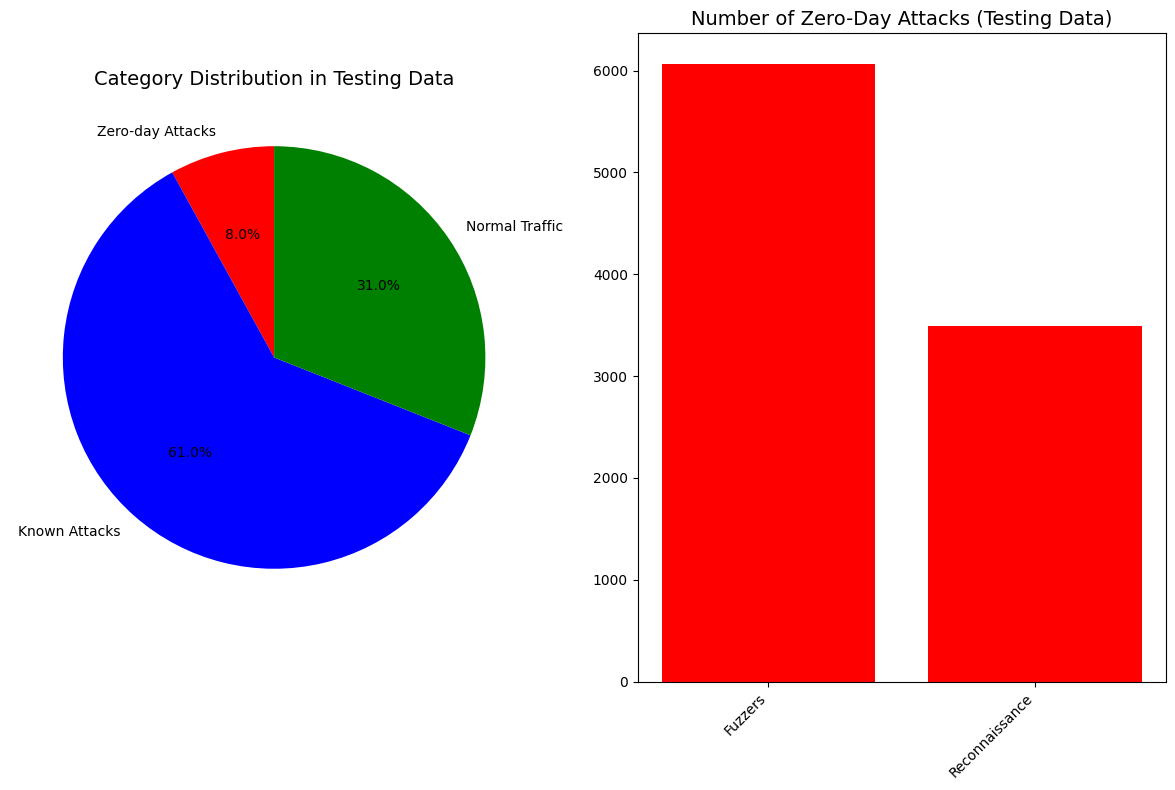


Pre-processing completed! Data is ready for model training and evaluation.


In [19]:
# 17. Additional: Visualizing distribution of zero-day vs non-zero-day categories
plt.figure(figsize=(12, 8))

# Datasets for visualization
zero_day_categories = ['Fuzzers', 'Reconnaissance']
non_zero_day_categories = [cat for cat in test_data['attack_cat'].unique() 
                          if cat in train_data['attack_cat'].unique() and cat != 'normal']

# Distribution in test set
zero_day_count = test_data[test_data['attack_cat'].isin(zero_day_categories)].shape[0]
non_zero_day_count = test_data[test_data['attack_cat'].isin(non_zero_day_categories)].shape[0]
normal_count = test_data[test_data['label'] == 0].shape[0]

# Plot pie chart
plt.subplot(1, 2, 1)
plt.pie([zero_day_count, non_zero_day_count, normal_count], 
        labels=['Zero-day Attacks', 'Known Attacks', 'Normal Traffic'],
        autopct='%1.1f%%', startangle=90, colors=['red', 'blue', 'green'])
plt.title('Category Distribution in Testing Data', fontsize=14)

# Plot comparison of zero-day vs non-zero-day attacks
plt.subplot(1, 2, 2)
zero_day_dist = test_data[test_data['attack_cat'].isin(zero_day_categories)]['attack_cat'].value_counts()
plt.bar(zero_day_dist.index, zero_day_dist.values, color='red')
plt.title('Number of Zero-Day Attacks (Testing Data)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('zero_day_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPre-processing completed! Data is ready for model training and evaluation.")

# Model Development

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                            f1_score, precision_recall_curve, roc_curve, auc, 
                            precision_score, recall_score)
import joblib
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import os

# ENVIRONMENT DEFINITION

In [21]:
# ===== 1. Environment Definition =====

class NetworkTrafficEnvironment:
    """
    Environment representing anomaly detection on UNSW-NB15 network traffic.
    """
    
    def __init__(self, X, y, n_states=30, state_clusters=None):
        """
        Initialize environment with better state representation.
        """
        self.X = X
        self.y = y
        self.n_states = n_states
        self.n_actions = 2  # 0: Normal, 1: Anomaly
        self.feature_dim = X.shape[1]  # Feature dimension for DQN
        
        if state_clusters is None:
            # Use MiniBatchKMeans for more efficient clustering
            print("Performing clustering for state representation...")
            self.state_clusters = MiniBatchKMeans(
                n_clusters=n_states, 
                random_state=42,
                batch_size=1000,
                max_iter=300,
                n_init=10
            )
            self.state_clusters.fit(X)
            
            # Check cluster balance
            cluster_labels = self.state_clusters.predict(X)
            unique, counts = np.unique(cluster_labels, return_counts=True)
            cluster_sizes = dict(zip(unique, counts))
            print(f"Cluster distribution: Min={min(counts)}, Max={max(counts)}, Avg={np.mean(counts):.1f}")
        else:
            self.state_clusters = state_clusters
            print("Using previously trained clusterer...")
        
        # Map each sample to state (cluster)
        self.states = self.state_clusters.predict(X)
        
        # Analyze label distribution per state
        self.state_label_dist = {}
        for state in range(self.n_states):
            state_indices = np.where(self.states == state)[0]
            if len(state_indices) > 0:
                normal_count = np.sum(self.y[state_indices] == 0)
                attack_count = np.sum(self.y[state_indices] == 1)
                self.state_label_dist[state] = {
                    'normal': normal_count,
                    'attack': attack_count,
                    'attack_ratio': attack_count / len(state_indices) if len(state_indices) > 0 else 0
                }
        
        # Store current position in dataset
        self.current_index = 0
        self.reset()
        
    def reset(self):
        """Reset environment to initial state and return initial state."""
        self.current_index = 0
        return self._get_current_state()
        
    def step(self, action):
        """
        Take action in environment and get results.
        IMPROVEMENT: Enhanced reward function to address bias.
        """
        # Get true label for current sample
        true_label = self.y[self.current_index]
        
        # IMPROVEMENT: Reward function that gives much larger penalty for false negatives
        if action == true_label:
            if action == 1 and true_label == 1:
                reward = 5.0  # Match with Q-Learning
            else:
                reward = 1.0  # Remains the same
        elif action == 0 and true_label == 1:
            reward = -10.0  # Match with Q-Learning
        else:
            reward = -2.0  # Remains the same
        
        # Move to next sample
        self.current_index += 1
        done = self.current_index >= len(self.X)
        
        # If reached end of dataset, set to avoid out of bounds
        if done:
            next_state = None
            info = {
                'true_label': true_label,
                'prediction': action
            }
        else:
            next_state = self._get_current_state()
            info = {
                'true_label': true_label,
                'prediction': action
            }
        
        return next_state, reward, done, info
    
    def _get_current_state(self):
        """Get state representation from current sample."""
        if self.current_index >= len(self.X):
            return None
        # For DQN, use original features instead of cluster state
        return self.X[self.current_index]

class ReplayBuffer:
    """
    Standard Experience Replay Buffer for pure Deep Q-Learning
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# DEEP Q Learning MODEL

In [22]:
# ===== 2. DQN Architecture =====

class DQNetwork(nn.Module):
    """
    Deep Q-Network with simple architecture according to pure DQN
    """
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        # Ideal architecture for research
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    """
    Agent using Deep Q-Learning with PyTorch
    """
    def __init__(self, state_dim, action_size, learning_rate=0.001, 
             gamma=0.95, epsilon=1.0, epsilon_decay=0.98, 
             epsilon_min=0.15, batch_size=64,
             buffer_size=2000, update_target_every=5):
        self.state_dim = state_dim
        self.action_size = action_size
        self.memory = ReplayBuffer(buffer_size)
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.update_target_every = update_target_every
        self.target_update_counter = 0
        
        # Check GPU availability
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Main model for training
        self.model = DQNetwork(state_dim, action_size).to(self.device)
        
        # Target model for stability
        self.target_model = DQNetwork(state_dim, action_size).to(self.device)
        self.update_target_model()
        
        # Use standard optimizer without weight decay
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # # Learning rate scheduler
        # self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        #     self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        # )

        # Or use a more aggressive step scheduler
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=5, gamma=0.5
        )

        
        # Tracking metrics
        self.rewards_history = []
        self.epsilon_history = []
        self.accuracy_history = []
        self.loss_history = []
    
    def update_target_model(self):
        """Updates target model with weights from main model"""
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        """Add experience to replay buffer"""
        self.memory.add(state, action, reward, next_state, done)
    
    def choose_action(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        
        # Convert state to model input format
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        # Set model to evaluation mode
        self.model.eval()
        with torch.no_grad():
            q_values = self.model(state_tensor)
        
        # Set model back to training mode if we're in training phase
        if training:
            self.model.train()
            
        return torch.argmax(q_values).item()
    
    def replay(self):
        """Train model with experiences from replay buffer with class weighting"""
        if len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        batch = self.memory.sample(self.batch_size)
        
        # Extract and prepare batches
        states = np.array([experience[0] for experience in batch])
        actions = np.array([experience[1] for experience in batch])
        rewards = np.array([experience[2] for experience in batch])
        next_states = np.array([experience[3] for experience in batch])
        dones = np.array([experience[4] for experience in batch])
        
        # Convert to PyTorch tensors
        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        dones_tensor = torch.FloatTensor(dones).to(self.device)
        
        # Compute Q values for current states
        self.model.train()
        q_values = self.model(states_tensor).gather(1, actions_tensor)
        
        # Use target network to get next Q values
        with torch.no_grad():
            self.target_model.eval()
            next_q_values = self.target_model(next_states_tensor).max(1)[0]
        
        # Compute target using Bellman equation
        target_q_values = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q_values
        
        # IMPROVEMENT: Class weighting to prioritize attack detection
        attack_weight = 2.5  # Higher weight for attack class
        normal_weight = 1.0  # Normal weight for normal class
        
        # Use Huber loss for robustness, with reduction 'none' to allow weighting
        losses = F.smooth_l1_loss(q_values.squeeze(), target_q_values, reduction='none')
        
        # Apply weights based on action (assuming action 1 is an attack)
        weights = torch.ones_like(rewards_tensor)
        weights[actions_tensor.squeeze() == 1] = attack_weight  # Higher weight for attacks
        weights[actions_tensor.squeeze() == 0] = normal_weight
        
        # Add extra weight for false negatives (predicted normal but actually attack)
        # Get indices where target_q_values indicate attack (high reward values)
        false_neg_idx = (actions_tensor.squeeze() == 0) & (target_q_values > 2.0)
        if torch.any(false_neg_idx):
            weights[false_neg_idx] = 3.0  # Even higher weight for false negatives
        
        # Apply weighting to loss
        weighted_loss = (losses * weights).mean()
        
        # Backpropagation
        self.optimizer.zero_grad()
        weighted_loss.backward()
        
        # IMPROVEMENT: Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        # Update target model if needed
        self.target_update_counter += 1
        if self.target_update_counter >= self.update_target_every:
            self.update_target_model()
            self.target_update_counter = 0
        
        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return weighted_loss.item()
    
    def get_q_values(self, state):
        """Get Q-values for a state"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.model.eval()
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return q_values.cpu().numpy()[0]
    
    def save(self, name):
        """Save model weights"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'target_model_state_dict': self.target_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, name)
    
    def load(self, name):
        """Load model weights"""
        checkpoint = torch.load(name)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# tambahan

In [23]:
# ===== Helper Functions for Feature Dimension Handling =====

def align_dataset_features(data, expected_features):
    """
    Menyesuaikan jumlah fitur dataset dengan model
    
    Parameters:
    - data: DataFrame dataset
    - expected_features: Jumlah fitur yang diharapkan model
    
    Returns:
    - DataFrame dengan jumlah fitur yang sudah disesuaikan
    """
    # Simpan kolom target jika ada
    target_columns = {}
    for col in ['label', 'attack_cat']:
        if col in data.columns:
            target_columns[col] = data[col].copy()
            data = data.drop(col, axis=1)
            
    actual_features = data.shape[1]
    print(f"Dataset memiliki {actual_features} fitur, model mengharapkan {expected_features} fitur")
    
    # Sesuaikan jumlah fitur
    if actual_features > expected_features:
        # Jika fitur terlalu banyak, ambil hanya sebanyak yang dibutuhkan
        print(f"Mengurangi fitur dari {actual_features} menjadi {expected_features}")
        data = data.iloc[:, :expected_features]
    elif actual_features < expected_features:
        # Jika fitur kurang, tambahkan dummy features
        print(f"Menambahkan {expected_features - actual_features} dummy features")
        for i in range(expected_features - actual_features):
            data[f'dummy_feature_{i}'] = 0.0
    
    # Kembalikan kolom target jika ada
    for col, values in target_columns.items():
        data[col] = values
        
    return data

def prepare_compatible_datasets(feature_count=21):
    """
    Menyiapkan dataset dengan jumlah fitur yang kompatibel dengan model
    
    Parameters:
    - feature_count: Jumlah fitur yang diharapkan model (default: 21)
    """
    # Load datasets
    X_test = pd.read_csv('preprocessed_binary_test.csv')
    zero_day_data = pd.read_csv('preprocessed_zero_day_test.csv')
    
    # Sesuaikan jumlah fitur
    X_test_compatible = align_dataset_features(X_test, feature_count)
    zero_day_compatible = align_dataset_features(zero_day_data, feature_count)
    
    # Simpan dataset yang sudah disesuaikan
    X_test_compatible.to_csv('preprocessed_binary_test_modified.csv', index=False)
    zero_day_compatible.to_csv('preprocessed_zero_day_test_modified.csv', index=False)
    
    print(f"Dataset kompatibel telah disimpan dengan {feature_count} fitur:")
    print(f"- preprocessed_binary_test_modified.csv")
    print(f"- preprocessed_zero_day_test_modified.csv")

def load_dqn_model(model_path, feature_count=21):
    """
    Memuat model DQN dengan dimensi state yang benar
    
    Parameters:
    - model_path: Path ke file model (.pth)
    - feature_count: Jumlah fitur yang digunakan model (default: 21)
    
    Returns:
    - DQNAgent yang sudah dimuat dengan model terlatih
    """
    agent = DQNAgent(state_dim=feature_count, action_size=2)
    try:
        agent.load(model_path)
        print(f"Model berhasil dimuat dengan {feature_count} fitur")
        return agent
    except Exception as e:
        print(f"Error saat memuat model: {str(e)}")
        return None

# Memory Monitoring Functions

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                            f1_score, precision_recall_curve, roc_curve, auc, 
                            precision_score, recall_score)
import joblib
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import os
import psutil  # Add this
import time     # Add this
import sys      # Add this

# Add Memory Monitor Class
class MemoryMonitor:
    """Class untuk monitoring penggunaan memori"""
    
    def __init__(self):
        self.process = psutil.Process()
        self.initial_memory = self.get_current_memory()
        self.peak_memory = self.initial_memory
        self.gpu_memory_peak = 0
        
    def get_current_memory(self):
        """Dapatkan penggunaan RAM saat ini dalam MB"""
        return self.process.memory_info().rss / 1024 / 1024
    
    def get_gpu_memory(self):
        """Dapatkan penggunaan GPU memory dalam MB"""
        if torch.cuda.is_available():
            try:
                return torch.cuda.memory_allocated() / 1024 / 1024
            except Exception:
                return 0
        return 0
    
    def update_peak(self):
        """Update peak memory usage"""
        current_ram = self.get_current_memory()
        current_gpu = self.get_gpu_memory()
        
        self.peak_memory = max(self.peak_memory, current_ram)
        self.gpu_memory_peak = max(self.gpu_memory_peak, current_gpu)
        
        return {
            'current_ram_mb': current_ram,
            'current_gpu_mb': current_gpu,
            'peak_ram_mb': self.peak_memory,
            'peak_gpu_mb': self.gpu_memory_peak,
            'ram_usage_from_start_mb': current_ram - self.initial_memory
        }

def get_model_size(model):
    """Hitung ukuran model dalam MB"""
    param_size = 0
    buffer_size = 0
    
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    model_size_mb = (param_size + buffer_size) / 1024 / 1024
    return model_size_mb

def measure_inference_speed(agent, test_data, n_iterations=1000):
    """Ukur kecepatan inferensi"""
    # Warm up
    for i in range(10):
        _ = agent.choose_action(test_data[0], training=False)
    
    # Measure inference time
    start_time = time.time()
    for i in range(n_iterations):
        sample_idx = i % len(test_data)
        _ = agent.choose_action(test_data[sample_idx], training=False)
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_inference_time = total_time / n_iterations
    samples_per_second = n_iterations / total_time
    
    return {
        'avg_inference_time_ms': avg_inference_time * 1000,
        'samples_per_second': samples_per_second,
        'total_time_seconds': total_time
    }

# TRAINING FUNCTIONS

In [25]:
def train_dqn_agent(env, agent, n_episodes=100, evaluation_env=None):
    """
    Train a DQN agent on the environment with early stopping implementation,
    model checkpoint, and memory monitoring.
    """
    # Initialize memory monitor
    memory_monitor = MemoryMonitor()
    
    # Get model size
    model_size_mb = get_model_size(agent.model)
    target_model_size_mb = get_model_size(agent.target_model)
    total_model_size = model_size_mb + target_model_size_mb
    
    print(f"Model size: {total_model_size:.2f} MB")
    
    # Tracking metrics
    episode_rewards = []
    episode_accuracies = []
    episode_epsilons = []
    episode_losses = []
    evaluation_accuracies = []
    evaluation_detection_rates = []
    evaluation_f1s = []
    
    # Memory tracking
    memory_history = []
    
    # Additional for training vs test visualization
    all_predictions = []
    all_true_labels = []
    evaluation_episodes = []
    
    # Best model storage
    best_detection_rate = 0
    best_model_state = None
    best_episode = 0
    
    # Early stopping parameters
    patience = 7
    no_improvement_count = 0
    min_detection_threshold = 0.3
    collapse_detected = False
    
    # Learning rate annealing
    lr_reduction_factor = 0.5
    lr_reduction_patience = 3
    lr_reduction_count = 0
    original_lr = agent.learning_rate
    
    for episode in tqdm(range(n_episodes), desc="Training DQN Agent"):
        state = env.reset()
        done = False
        total_reward = 0
        predictions = []
        true_labels = []
        episode_loss = []
        
        # Monitor memory at start of episode
        memory_stats = memory_monitor.update_peak()
        
        # Iterate through one episode (entire dataset)
        while not done:
            # Choose action based on state
            action = agent.choose_action(state)
            
            # Take action in environment
            next_state, reward, done, info = env.step(action)
            
            # Save experience in replay buffer
            if not done:
                agent.remember(state, action, reward, next_state, done)
            else:
                # For terminal state, use dummy state as next_state
                agent.remember(state, action, reward, state, done)
            
            # Train agent with batch from replay buffer
            if len(agent.memory) > agent.batch_size:
                loss = agent.replay()
                episode_loss.append(loss)
                
                # Update memory stats setelah training step
                memory_monitor.update_peak()
            
            # Update state
            state = next_state
            
            # Accumulate reward and predictions
            total_reward += reward
            predictions.append(action)
            true_labels.append(info['true_label'])
        
        # Calculate episode accuracy
        episode_accuracy = accuracy_score(true_labels, predictions)
        
        # Analyze attack detection specifically
        attack_indices = [i for i, label in enumerate(true_labels) if label == 1]
        attack_predictions = [predictions[i] for i in attack_indices]
        attack_detection_rate = np.mean(attack_predictions) if attack_predictions else 0
        
        mean_loss = np.mean(episode_loss) if episode_loss else 0
        
        # Save metrics
        episode_rewards.append(total_reward)
        episode_accuracies.append(episode_accuracy)
        episode_epsilons.append(agent.epsilon)
        episode_losses.append(mean_loss)
        
        # Save predictions and true labels for validation
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)
        
        # Record memory stats untuk episode ini
        final_memory_stats = memory_monitor.update_peak()
        memory_history.append({
            'episode': episode,
            'current_ram_mb': final_memory_stats['current_ram_mb'],
            'peak_ram_mb': final_memory_stats['peak_ram_mb'],
            'current_gpu_mb': final_memory_stats['current_gpu_mb'],
            'peak_gpu_mb': final_memory_stats['peak_gpu_mb'],
            'replay_buffer_size': len(agent.memory),
            'model_size_mb': total_model_size
        })
        
        # Evaluate on test data if provided
        if evaluation_env is not None and (episode + 1) % 2 == 0:  # Evaluate more frequently (every 2 episodes)
            eval_metrics = evaluate_agent(evaluation_env, agent)
            evaluation_accuracies.append(eval_metrics['accuracy'])
            evaluation_detection_rates.append(eval_metrics['detection_rate'])
            evaluation_f1s.append(eval_metrics['f1_score'])
            evaluation_episodes.append(episode)  # Save episode when evaluation was performed
            
            # Detect model collapse - if detection rate drops drastically
            if eval_metrics['detection_rate'] < min_detection_threshold and episode > 10:
                print(f"\nWARNING: Model collapse detected! Detection rate: {eval_metrics['detection_rate']:.4f}")
                collapse_detected = True
                
                # Revert to best model if available
                if best_model_state is not None:
                    print(f"Reverting to best model from episode {best_episode} (detection rate: {best_detection_rate:.4f})")
                    agent.model.load_state_dict(best_model_state['model'])
                    agent.target_model.load_state_dict(best_model_state['target_model'])
                    
                    # Reset learning rate and increase epsilon for more exploration
                    for param_group in agent.optimizer.param_groups:
                        param_group['lr'] = original_lr * 0.7
                    agent.epsilon = max(0.4, agent.epsilon)  # Increase exploration
                    print(f"Learning rate reset to {agent.optimizer.param_groups[0]['lr']:.6f}, epsilon: {agent.epsilon:.4f}")
                    
                    # Reset counter
                    no_improvement_count = 0
                    collapse_detected = False
            
            # Save model with best detection rate
            if eval_metrics['detection_rate'] > best_detection_rate:
                best_detection_rate = eval_metrics['detection_rate']
                best_model_state = {
                    'model': agent.model.state_dict(),
                    'target_model': agent.target_model.state_dict(),
                    'optimizer': agent.optimizer.state_dict()
                }
                best_episode = episode
                no_improvement_count = 0
                lr_reduction_count = 0
                print(f"Best model saved! Detection rate: {best_detection_rate:.4f}")
            else:
                no_improvement_count += 1
                lr_reduction_count += 1
            
            # Learning rate annealing
            if lr_reduction_count >= lr_reduction_patience and not collapse_detected:
                new_lr = agent.optimizer.param_groups[0]['lr'] * lr_reduction_factor
                for param_group in agent.optimizer.param_groups:
                    param_group['lr'] = new_lr
                print(f"\nReducing learning rate to {new_lr:.6f}")
                lr_reduction_count = 0
        
        # Print progress every few episodes
        if (episode + 1) % 5 == 0:
            print(f"Episode {episode+1}/{n_episodes}, "
                  f"Reward: {total_reward:.2f}, "
                  f"Train Accuracy: {episode_accuracy:.4f}, "
                  f"Attack Detection Rate: {attack_detection_rate:.4f}, "
                  f"Epsilon: {agent.epsilon:.4f}, "
                  f"Loss: {mean_loss:.6f}")
            
            # Print memory stats
            print(f"  RAM: {final_memory_stats['current_ram_mb']:.1f}MB, "
                  f"GPU: {final_memory_stats['current_gpu_mb']:.1f}MB, "
                  f"Buffer: {len(agent.memory)} samples")
            
            if evaluation_env is not None and len(evaluation_accuracies) > 0:
                print(f"  Test Accuracy: {evaluation_accuracies[-1]:.4f}, "
                      f"Test Detection Rate: {evaluation_detection_rates[-1]:.4f}, "
                      f"Test F1: {evaluation_f1s[-1]:.4f}")
    
    # Save history to agent
    agent.rewards_history = episode_rewards
    agent.accuracy_history = episode_accuracies
    agent.epsilon_history = episode_epsilons
    agent.loss_history = episode_losses
    
    # If best_model_state found, use it
    if best_model_state is not None:
        print(f"Using model with best detection rate: {best_detection_rate:.4f} from episode {best_episode}")
        agent.model.load_state_dict(best_model_state['model'])
        agent.target_model.load_state_dict(best_model_state['target_model'])
        agent.optimizer.load_state_dict(best_model_state['optimizer'])
    
    # Return complete metrics for visualization and analysis with memory data
    metrics = {
        'rewards': episode_rewards,
        'accuracies': episode_accuracies,
        'epsilons': episode_epsilons,
        'losses': episode_losses,
        'evaluation_accuracies': evaluation_accuracies,
        'evaluation_detection_rates': evaluation_detection_rates,
        'evaluation_f1s': evaluation_f1s,
        'evaluation_episodes': evaluation_episodes,
        'best_episode': best_episode,
        'best_detection_rate': best_detection_rate,
        'all_predictions': all_predictions,
        'all_true_labels': all_true_labels,
        # Add memory metrics
        'memory_history': memory_history,
        'peak_ram_mb': memory_monitor.peak_memory,
        'peak_gpu_mb': memory_monitor.gpu_memory_peak,
        'model_size_mb': total_model_size,
        'final_buffer_size': len(agent.memory)
    }
    
    return agent, metrics

# EVALUATION FUNCTIONS

In [26]:
# ===== 4. Evaluation Functions =====

def evaluate_agent(env, agent):
    """
    Evaluate agent performance on environment.
    """
    state = env.reset()
    done = False
    predictions = []
    true_labels = []
    q_values = []
    
    # Use agent to predict
    while not done:
        action = agent.choose_action(state, training=False)  # Use greedy policy
        q_val = agent.get_q_values(state)  # Save Q-values for ROC analysis
        next_state, _, done, info = env.step(action)
        state = next_state
        
        predictions.append(action)
        true_labels.append(info['true_label'])
        q_values.append(q_val)
    
    # Convert to arrays for easier calculation
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    q_values = np.array(q_values)
    
    # Calculate basic metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Ensure confusion matrix is 2x2
    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        # If there is only one class in predictions, create custom confusion matrix
        tn = np.sum((true_labels == 0) & (predictions == 0))
        fp = np.sum((true_labels == 0) & (predictions == 1))
        fn = np.sum((true_labels == 1) & (predictions == 0))
        tp = np.sum((true_labels == 1) & (predictions == 1))

    # Calculate TPR, FPR, and TNR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Detection Rate)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate (Specificity)
    
    # For ROC curve, use probability of action 1 (anomaly) from Q-values
    # Normalize Q-values to get probabilities
    q_sum = np.sum(q_values, axis=1)
    q_probs = np.zeros_like(q_values[:, 1])
    nonzero_indices = q_sum != 0
    q_probs[nonzero_indices] = q_values[nonzero_indices, 1] / q_sum[nonzero_indices]
    
    # Calculate ROC curve and AUC
    fpr_curve, tpr_curve, _ = roc_curve(true_labels, q_probs)
    roc_auc = auc(fpr_curve, tpr_curve)

    # Calculate Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(true_labels, q_probs)
    
    # Classification report
    try:
        report = classification_report(true_labels, predictions, output_dict=True, zero_division=0)
    except Exception:
        # If error (e.g., only one class), create manual report
        report = {
            "0": {"precision": tn/(tn+fn) if (tn+fn)>0 else 0, "recall": tn/(tn+fp) if (tn+fp)>0 else 0},
            "1": {"precision": tp/(tp+fp) if (tp+fp)>0 else 0, "recall": tp/(tp+fn) if (tp+fn)>0 else 0}
        }
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'detection_rate': tpr,
        'false_positive_rate': fpr,
        'true_negative_rate': tnr,
        'roc_auc': roc_auc,
        'fpr_curve': fpr_curve,
        'tpr_curve': tpr_curve,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'classification_report': report,
        'predictions': predictions,  # Add predictions for visualization
        'true_labels': true_labels,  # Add true labels for visualization
        
        # Add collection of training metrics for overfitting visualization
        'training_accuracies': getattr(agent, 'accuracy_history', []),
        'losses': getattr(agent, 'loss_history', []),
        'accuracies': [accuracy],  # For compatibility with visualization
        'detection_rates': [tpr],  # For compatibility with visualization
        'f1_scores': [f1]  # For compatibility with visualization
    }
    
    return metrics



def create_zero_day_environment(train_env, zero_day_data, zero_day_labels):
    """
    Create specific environment for zero-day attack evaluation.
    """
    # Create environment for zero-day data (DQN uses raw features, so no need for clusters)
    zero_day_env = NetworkTrafficEnvironment(
        zero_day_data,
        zero_day_labels,
        n_states=train_env.n_states,
        state_clusters=train_env.state_clusters
    )
    
    return zero_day_env

# HYPERPARAMETER SEARCH

In [27]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def specific_scheme_search(X_train, y_train, X_test, y_test, zero_day_data, zero_day_labels):
    """
    Function to evaluate 5 specific hyperparameter schemes for DQN with memory monitoring
    """
    # Define 5 specific parameter schemes
    specific_params = [
        {'learning_rate': 0.0001, 'epsilon_decay': 0.93, 'batch_size': 32, 'buffer_size': 50000},
        {'learning_rate': 0.0003, 'epsilon_decay': 0.95, 'batch_size': 64, 'buffer_size': 50000},
        {'learning_rate': 0.0005, 'epsilon_decay': 0.97, 'batch_size': 128, 'buffer_size': 50000},
        {'learning_rate': 0.001, 'epsilon_decay': 0.98, 'batch_size': 256, 'buffer_size': 50000},
        {'learning_rate': 0.003, 'epsilon_decay': 0.99, 'batch_size': 512, 'buffer_size': 50000}
    ]
    
    # Set up for tracking results
    results = []
    memory_results = []  # Add memory results tracking
    best_detection_rate = 0
    best_agent = None
    best_metrics = None
    best_params = None
    
    # Improvement: Save complete training and evaluation metrics
    all_test_metrics = []
    all_zero_day_metrics = []
    all_training_metrics = []
    
    print(f"Evaluating 5 specific hyperparameter schemes")
    
    # Setup environment only once
    n_states = 30
    sample_size = int(len(X_train) * 0.5)  # Use 50% of data for speed
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train.iloc[indices].values
    y_train_sample = y_train[indices]
    
    print(f"Using {sample_size} samples from {len(X_train)} original data (50.0%)")
    
    # Setup environment
    train_env = NetworkTrafficEnvironment(X_train_sample, y_train_sample, n_states=n_states)
    test_env = NetworkTrafficEnvironment(X_test.values, y_test, state_clusters=train_env.state_clusters)
    zero_day_env = create_zero_day_environment(train_env, zero_day_data.values, zero_day_labels)
    
    # Fixed parameters (don't change between schemes)
    state_dim = X_train.shape[1]
    action_size = 2
    fixed_params = {
        'state_dim': state_dim,
        'action_size': action_size,
        'gamma': 0.95,
        'epsilon': 1.0,
        'epsilon_min': 0.15,
        'update_target_every': 3
    }
    
    # Evaluate each scheme
    for i, params in enumerate(tqdm(specific_params, desc="Evaluating Schemes")):
        # Create parameter dictionary by combining fixed_params and params
        combined_params = {**fixed_params, **params}
        
        # Log current parameter combination
        print(f"\nScheme {i+1}/5: {params}")
        
        # Initialize memory monitor untuk scheme ini
        scheme_memory_monitor = MemoryMonitor()
        start_time = time.time()
        
        # Initialize agent with current parameters
        agent = DQNAgent(**combined_params)
        
        # Train agent dengan memory monitoring
        try:
            trained_agent, training_metrics = train_dqn_agent(
                train_env,
                agent,
                n_episodes=15,
                evaluation_env=test_env
            )
            
            end_time = time.time()
            training_time = end_time - start_time
            
            # Evaluate on test data
            test_metrics = evaluate_agent(test_env, trained_agent)
            
            # Add training data to test_metrics for visualization
            test_metrics['training_accuracies'] = training_metrics['accuracies']
            test_metrics['training_losses'] = training_metrics['losses']
            test_metrics['training_episodes'] = list(range(len(training_metrics['accuracies'])))
            test_metrics['evaluation_episodes'] = training_metrics['evaluation_episodes']
            
            # Evaluate on zero-day data
            zero_day_metrics = evaluate_agent(zero_day_env, trained_agent)
            
            # Add training data to zero_day_metrics for visualization
            zero_day_metrics['training_accuracies'] = training_metrics['accuracies']
            zero_day_metrics['training_losses'] = training_metrics['losses']
            zero_day_metrics['evaluation_accuracies'] = training_metrics['evaluation_accuracies']
            zero_day_metrics['evaluation_episodes'] = training_metrics['evaluation_episodes']
            
            # Measure inference speed
            inference_metrics = measure_inference_speed(trained_agent, X_test.values[:100])
            
            # Collect memory metrics
            memory_result = {
                'scheme': f"Scheme {i+1}",
                'training_time_seconds': training_time,
                'peak_ram_mb': training_metrics['peak_ram_mb'],
                'peak_gpu_mb': training_metrics['peak_gpu_mb'],
                'model_size_mb': training_metrics['model_size_mb'],
                'final_buffer_size': training_metrics['final_buffer_size'],
                'buffer_size_mb': training_metrics['final_buffer_size'] * 4 * 8 / 1024 / 1024,  # Perbaiki dari 32 ke 4
                'avg_inference_time_ms': inference_metrics['avg_inference_time_ms'],
                'samples_per_second': inference_metrics['samples_per_second'],
                **params
            }
            memory_results.append(memory_result)
            
            # Save complete metrics for later visualization
            all_test_metrics.append(test_metrics)
            all_zero_day_metrics.append(zero_day_metrics)
            all_training_metrics.append(training_metrics)
            
            # Record results with memory info
            result = {
                **params,
                'skema': f"Scheme {i+1}",
                'training_time_seconds': training_time,
                'test_accuracy': test_metrics['accuracy'],
                'test_precision': test_metrics['precision'],
                'test_recall': test_metrics['detection_rate'],
                'test_f1': test_metrics['f1_score'],
                'test_fpr': test_metrics['false_positive_rate'],
                'test_auc': test_metrics['roc_auc'],
                'zero_day_accuracy': zero_day_metrics['accuracy'],
                'zero_day_precision': zero_day_metrics['precision'],
                'zero_day_recall': zero_day_metrics['detection_rate'],
                'zero_day_f1': zero_day_metrics['f1_score'],
                'zero_day_fpr': zero_day_metrics['false_positive_rate'],
                'zero_day_auc': zero_day_metrics['roc_auc'],
                # Add memory metrics to main results
                'peak_ram_mb': training_metrics['peak_ram_mb'],
                'peak_gpu_mb': training_metrics['peak_gpu_mb'],
                'model_size_mb': training_metrics['model_size_mb'],
                'inference_time_ms': inference_metrics['avg_inference_time_ms'],
                'inference_speed_samples_per_sec': inference_metrics['samples_per_second']
            }
            results.append(result)
            
            # Update best model if performance on zero-day is better
            if zero_day_metrics['detection_rate'] > best_detection_rate:
                best_detection_rate = zero_day_metrics['detection_rate']
                best_agent = trained_agent
                best_metrics = training_metrics
                best_params = params
                print(f"Best model updated! Zero-day detection rate: {best_detection_rate:.4f}")
            
        except Exception as e:
            print(f"Error in scheme {i+1}: {e}")
            # Continue to next scheme if error occurs
            continue
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    memory_df = pd.DataFrame(memory_results)
    
    # Save complete metrics as DataFrame attributes
    results_df.attrs['test_metrics'] = all_test_metrics
    results_df.attrs['zero_day_metrics'] = all_zero_day_metrics
    results_df.attrs['training_metrics'] = all_training_metrics
    results_df.attrs['memory_metrics'] = memory_results  # Add memory metrics
    
    # Display summary of results
    print("\n" + "="*80)
    print("EVALUATION RESULTS OF 5 SCHEMES")
    print("="*80)
    print(f"Total schemes successfully evaluated: {len(results)}")
    print(f"Best parameters: {best_params}")
    print(f"Best zero-day detection rate: {best_detection_rate:.4f}")
    
    # Display scheme ranking based on detection rate
    print("\nScheme ranking based on zero-day detection rate:")
    sorted_results = results_df.sort_values('zero_day_recall', ascending=False)
    for i, (_, row) in enumerate(sorted_results.iterrows()):
        print(f"{i+1}. {row['skema']} - Zero-day Recall: {row['zero_day_recall']:.4f}, F1: {row['zero_day_f1']:.4f}")
    
    # Print memory comparison table
    print("\n" + "="*80)
    print("MEMORY FOOTPRINT COMPARISON")
    print("="*80)
    print(memory_df.to_string(index=False))
    
    return results_df, best_agent, best_metrics

In [28]:
def create_memory_comparison_table(results_df):
    """
    Buat tabel memory footprint untuk DQN saja
    """
    if 'memory_metrics' not in results_df.attrs:
        print("Memory metrics tidak tersedia. Jalankan training dengan monitoring dulu.")
        return
    
    memory_metrics = results_df.attrs['memory_metrics']
    
    # Ambil scheme terbaik (berdasarkan zero-day recall)
    best_scheme_idx = results_df['zero_day_recall'].idxmax()
    best_memory = memory_metrics[best_scheme_idx]
    
    # Buat tabel untuk DQN
    comparison_data = {
        'Metrik': [
            'Training Time (seconds)',
            'Training Time (minutes)', 
            'Peak RAM Usage (MB)',
            'Peak GPU Memory (MB)',
            'Model Size (MB)',
            'Buffer Memory (MB)',
            'Total Memory Footprint (MB)',
            'Avg Inference Time (ms)',
            'Inference Speed (samples/sec)',
            'Memory Efficiency (samples/MB)'
        ],
        'DQN (Best Scheme)': [
            f"{best_memory['training_time_seconds']:.1f}",
            f"{best_memory['training_time_seconds']/60:.2f}",
            f"{best_memory['peak_ram_mb']:.1f}",
            f"{best_memory['peak_gpu_mb']:.1f}", 
            f"{best_memory['model_size_mb']:.2f}",
            f"{best_memory['buffer_size_mb']:.1f}",
            f"{best_memory['peak_ram_mb'] + best_memory['peak_gpu_mb']:.1f}",
            f"{best_memory['avg_inference_time_ms']:.2f}",
            f"{best_memory['samples_per_second']:.1f}",
            f"{best_memory['final_buffer_size']/(best_memory['peak_ram_mb'] + best_memory['peak_gpu_mb']):.1f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("DQN MEMORY FOOTPRINT ANALYSIS")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    # Tambahkan analisis tambahan
    print("\n" + "="*80)
    print("DETAILED MEMORY ANALYSIS")
    print("="*80)
    print(f"Best Scheme: Scheme {best_scheme_idx + 1}")
    print(f"Learning Rate: {best_memory['learning_rate']}")
    print(f"Batch Size: {best_memory['batch_size']}")
    print(f"Buffer Size: {best_memory['buffer_size']}")
    print(f"\nMemory Breakdown:")
    print(f"  - Model Parameters: {best_memory['model_size_mb']:.2f} MB")
    print(f"  - Replay Buffer: {best_memory['buffer_size_mb']:.1f} MB")
    print(f"  - Peak RAM Usage: {best_memory['peak_ram_mb']:.1f} MB")
    print(f"  - Peak GPU Memory: {best_memory['peak_gpu_mb']:.1f} MB")
    print(f"\nPerformance Metrics:")
    print(f"  - Training Time: {best_memory['training_time_seconds']:.1f} seconds ({best_memory['training_time_seconds']/60:.2f} minutes)")
    print(f"  - Inference Speed: {best_memory['samples_per_second']:.1f} samples/second")
    print(f"  - Average Inference Time: {best_memory['avg_inference_time_ms']:.2f} ms per sample")
    
    return comparison_df

# Fungsi tambahan untuk menampilkan perbandingan antar semua scheme DQN
def create_all_schemes_memory_table(results_df):
    """
    Buat tabel perbandingan memory footprint untuk semua scheme DQN
    """
    if 'memory_metrics' not in results_df.attrs:
        print("Memory metrics tidak tersedia. Jalankan training dengan monitoring dulu.")
        return
    
    memory_metrics = results_df.attrs['memory_metrics']
    
    # Buat tabel untuk semua scheme
    schemes_data = {
        'Scheme': [],
        'Training Time (min)': [],
        'Peak RAM (MB)': [],
        'Peak GPU (MB)': [],
        'Model Size (MB)': [],
        'Buffer Memory (MB)': [],
        'Total Memory (MB)': [],
        'Inference Time (ms)': [],
        'Inference Speed (samples/sec)': [],
        'Learning Rate': [],
        'Batch Size': []
    }
    
    for i, memory in enumerate(memory_metrics):
        schemes_data['Scheme'].append(f"Scheme {i+1}")
        schemes_data['Training Time (min)'].append(f"{memory['training_time_seconds']/60:.2f}")
        schemes_data['Peak RAM (MB)'].append(f"{memory['peak_ram_mb']:.1f}")
        schemes_data['Peak GPU (MB)'].append(f"{memory['peak_gpu_mb']:.1f}")
        schemes_data['Model Size (MB)'].append(f"{memory['model_size_mb']:.2f}")
        schemes_data['Buffer Memory (MB)'].append(f"{memory['buffer_size_mb']:.1f}")
        schemes_data['Total Memory (MB)'].append(f"{memory['peak_ram_mb'] + memory['peak_gpu_mb']:.1f}")
        schemes_data['Inference Time (ms)'].append(f"{memory['avg_inference_time_ms']:.2f}")
        schemes_data['Inference Speed (samples/sec)'].append(f"{memory['samples_per_second']:.1f}")
        schemes_data['Learning Rate'].append(f"{memory['learning_rate']}")
        schemes_data['Batch Size'].append(f"{memory['batch_size']}")
    
    schemes_df = pd.DataFrame(schemes_data)
    print("\n" + "="*120)
    print("MEMORY FOOTPRINT COMPARISON - ALL DQN SCHEMES")
    print("="*120)
    print(schemes_df.to_string(index=False))
    
    # Analisis trends
    print("\n" + "="*80)
    print("MEMORY USAGE TRENDS")
    print("="*80)
    
    # Konversi ke numeric untuk analisis
    ram_usage = [float(memory['peak_ram_mb']) for memory in memory_metrics]
    gpu_usage = [float(memory['peak_gpu_mb']) for memory in memory_metrics]
    batch_sizes = [int(memory['batch_size']) for memory in memory_metrics]
    training_times = [float(memory['training_time_seconds']) for memory in memory_metrics]
    
    print(f"RAM Usage Range: {min(ram_usage):.1f} - {max(ram_usage):.1f} MB")
    print(f"GPU Usage Range: {min(gpu_usage):.1f} - {max(gpu_usage):.1f} MB")
    print(f"Training Time Range: {min(training_times)/60:.1f} - {max(training_times)/60:.1f} minutes")
    print(f"Batch Size Range: {min(batch_sizes)} - {max(batch_sizes)}")
    
    # Korelasi batch size dengan memory usage
    print(f"\nObservations:")
    print(f"- Larger batch sizes generally require more memory")
    print(f"- GPU memory usage scales with batch size")
    print(f"- Training time varies with complexity and batch size")
    
    return schemes_df

In [29]:
def get_confusion_matrix(scheme_idx, is_zeroday=False, results_df=None):
    """
    Create confusion matrix from actual predictions
    """
    # IMPROVEMENT: Use actual predictions stored in results_df.attrs
    if results_df is None:
        raise ValueError("results_df must be provided to access actual predictions")
    
    if is_zeroday:
        if 'zero_day_metrics' not in results_df.attrs or scheme_idx >= len(results_df.attrs['zero_day_metrics']):
            raise ValueError(f"Zero-day metrics not available for scheme {scheme_idx}")
        
        metrics = results_df.attrs['zero_day_metrics'][scheme_idx]
        true_labels = metrics['true_labels']
        predictions = metrics['predictions']
    else:
        if 'test_metrics' not in results_df.attrs or scheme_idx >= len(results_df.attrs['test_metrics']):
            raise ValueError(f"Test metrics not available for scheme {scheme_idx}")
        
        metrics = results_df.attrs['test_metrics'][scheme_idx]
        true_labels = metrics['true_labels']
        predictions = metrics['predictions']
    
    # Create confusion matrix from actual predictions
    cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
    return cm

# roc_curve

In [4]:
def plot_roc_curve_after_training(results_file, save_path='roc_curve_comparison.png'):
    """
    Plot ROC curve menggunakan hasil evaluasi yang sudah disimpan
    
    Parameters:
    - results_file: Path ke file pickle hasil evaluasi
    - save_path: Path untuk menyimpan gambar
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Muat hasil evaluasi
    print("Memuat hasil evaluasi...")
    results_df = pd.read_pickle(results_file)
    
    # Temukan scheme terbaik (berdasarkan zero-day recall)
    best_scheme_idx = results_df['zero_day_recall'].idxmax()
    
    # Ambil data ROC dari hasil evaluasi
    if 'test_metrics' in results_df.attrs and 'zero_day_metrics' in results_df.attrs:
        test_metrics = results_df.attrs['test_metrics'][best_scheme_idx]
        zero_day_metrics = results_df.attrs['zero_day_metrics'][best_scheme_idx]
        
        # Ambil data ROC curve dari metrics
        fpr_test = test_metrics['fpr_curve']
        tpr_test = test_metrics['tpr_curve']
        roc_auc_test = test_metrics['roc_auc']
        
        fpr_zd = zero_day_metrics['fpr_curve']
        tpr_zd = zero_day_metrics['tpr_curve']
        roc_auc_zd = zero_day_metrics['roc_auc']
        
        # Inisialisasi gambar dengan ukuran yang lebih besar dan style yang lebih modern
        plt.figure(figsize=(12, 8))
        plt.style.use('seaborn-v0_8-whitegrid' if 'seaborn-v0_8-whitegrid' in plt.style.available else 'seaborn-whitegrid')
        
        # Plot ROC curve untuk data test
        plt.plot(fpr_test, tpr_test, 'b-', linewidth=2.5, label=f'Test Data (AUC = {roc_auc_test:.4f})')
        
        # Plot ROC curve untuk data zero-day
        plt.plot(fpr_zd, tpr_zd, 'r-', linewidth=2.5, label=f'Zero-day Data (AUC = {roc_auc_zd:.4f})')
        
        # Plot garis diagonal (random classifier)
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.6)
        
        # Tambahkan label dan judul dengan formatting yang lebih baik
        plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
        plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
        plt.title('DQN ROC Curve (Best Scheme)', fontsize=16, fontweight='bold')
        
        # Perbaikan style legend dan grid
        plt.legend(loc='lower right', fontsize=12, fancybox=True, framealpha=0.9)
        plt.grid(True, alpha=0.3)
        
        # Batasi rentang plot
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        # Tambahkan anotasi
        plt.annotate('Perfect Classifier', xy=(0.05, 0.95), fontsize=12, 
                    xycoords='axes fraction', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2))
        plt.annotate('Random Classifier', xy=(0.5, 0.5), fontsize=12, rotation=45,
                    xycoords='data', xytext=(0.6, 0.4), 
                    arrowprops=dict(arrowstyle='->'))
        
        # Tambahkan metrics summary di corner
        metric_text = f"""Metrics Summary:
        Test AUC: {roc_auc_test:.4f}
        Zero-day AUC: {roc_auc_zd:.4f}"""
        
        plt.text(0.02, 0.02, metric_text, fontsize=11, 
                bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.9))
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"ROC curve telah disimpan ke {save_path}")
        
        # Return metrics untuk penggunaan lebih lanjut
        return {
            'test_auc': roc_auc_test,
            'zero_day_auc': roc_auc_zd
        }
    else:
        print("Error: Data metrics tidak ditemukan dalam hasil evaluasi")
        return None

# tsne_visualization

In [31]:
def create_tsne_visualization(best_agent, feature_count=21, sample_size=3000, perplexity=30, n_iter=1000):
    """
    Membuat visualisasi t-SNE untuk membedakan serangan dikenal dan serangan zero-day
    
    Parameters:
    - best_agent: Model DQN yang telah ditraining
    - feature_count: Jumlah fitur yang digunakan model
    - sample_size: Jumlah sampel maksimum untuk t-SNE (untuk kecepatan)
    - perplexity: Parameter perplexity untuk t-SNE
    - n_iter: Jumlah iterasi untuk t-SNE
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import seaborn as sns
    from matplotlib.patches import Patch
    
    print("Memuat dataset untuk visualisasi t-SNE...")
    
    # Load data test (serangan dikenal dan normal)
    try:
        X_test = pd.read_csv('preprocessed_binary_test_modified.csv')
        
        if 'attack_cat' in X_test.columns:
            attack_categories_test = X_test['attack_cat'].copy()
            X_test = X_test.drop('attack_cat', axis=1)
        else:
            attack_categories_test = pd.Series(['Unknown'] * len(X_test))
            
        if 'label' in X_test.columns:
            y_test = X_test.pop('label').values
        else:
            print("Warning: kolom 'label' tidak ditemukan di data test")
            y_test = np.zeros(len(X_test))
            
    except FileNotFoundError:
        print("File data test tidak ditemukan")
        return
        
    # Load data zero-day
    try:
        zero_day_data = pd.read_csv('preprocessed_zero_day_test_modified.csv')
        
        if 'attack_cat' in zero_day_data.columns:
            attack_categories_zd = zero_day_data['attack_cat'].copy()
            zero_day_data = zero_day_data.drop('attack_cat', axis=1)
        else:
            attack_categories_zd = pd.Series(['Unknown'] * len(zero_day_data))
            
        if 'label' in zero_day_data.columns:
            zero_day_labels = zero_day_data.pop('label').values
        else:
            print("Warning: kolom 'label' tidak ditemukan di data zero-day")
            zero_day_labels = np.zeros(len(zero_day_data))
            
    except FileNotFoundError:
        print("File data zero-day tidak ditemukan")
        return
    
    # Periksa apakah dimensi fitur sudah sesuai dengan model
    if X_test.shape[1] != feature_count or zero_day_data.shape[1] != feature_count:
        print(f"Peringatan: Dimensi fitur tidak sesuai dengan model ({feature_count})")
        print(f"Test data: {X_test.shape[1]}, Zero-day data: {zero_day_data.shape[1]}")
        
        # Sesuaikan jumlah fitur jika perlu
        if X_test.shape[1] > feature_count:
            X_test = X_test.iloc[:, :feature_count]
        if zero_day_data.shape[1] > feature_count:
            zero_day_data = zero_day_data.iloc[:, :feature_count]
            
        # Tambahkan fitur dummy jika kurang
        if X_test.shape[1] < feature_count:
            for i in range(feature_count - X_test.shape[1]):
                X_test[f'dummy_{i}'] = 0
        if zero_day_data.shape[1] < feature_count:
            for i in range(feature_count - zero_day_data.shape[1]):
                zero_day_data[f'dummy_{i}'] = 0
    
    print("Mengekstrak fitur dan membuat Q-values...")
    
    # Gabungkan data untuk visualisasi
    # 1. Untuk test data (serangan dikenal)
    test_normal_indices = np.where(y_test == 0)[0]
    test_attack_indices = np.where(y_test == 1)[0]
    
    # 2. Untuk zero-day data
    zd_normal_indices = np.where(zero_day_labels == 0)[0]
    zd_attack_indices = np.where(zero_day_labels == 1)[0]
    
    # Ambil sampel untuk seimbang dan menghindari memori yang terlalu besar
    max_per_class = min(len(test_normal_indices), len(test_attack_indices), 
                        len(zd_normal_indices), len(zd_attack_indices), 
                        sample_size // 4)
    
    # Jika ukuran sampel terlalu kecil, gunakan setidaknya 100 sampel per kelas
    max_per_class = max(100, max_per_class)
    
    print(f"Menggunakan {max_per_class} sampel per kategori")
    
    # Ambil sampel secara acak
    np.random.seed(42)
    if len(test_normal_indices) > max_per_class:
        test_normal_indices = np.random.choice(test_normal_indices, max_per_class, replace=False)
    if len(test_attack_indices) > max_per_class:
        test_attack_indices = np.random.choice(test_attack_indices, max_per_class, replace=False)
    if len(zd_normal_indices) > max_per_class:
        zd_normal_indices = np.random.choice(zd_normal_indices, max_per_class, replace=False)
    if len(zd_attack_indices) > max_per_class:
        zd_attack_indices = np.random.choice(zd_attack_indices, max_per_class, replace=False)
    
    # Buat array fitur dan label
    X_combined = np.vstack([
        X_test.iloc[test_normal_indices].values,
        X_test.iloc[test_attack_indices].values,
        zero_day_data.iloc[zd_normal_indices].values,
        zero_day_data.iloc[zd_attack_indices].values
    ])
    
    # Buat array label kategori
    categories = np.concatenate([
        ['Known Normal'] * len(test_normal_indices),
        ['Known Attack'] * len(test_attack_indices),
        ['Zero-day Normal'] * len(zd_normal_indices),
        ['Zero-day Attack'] * len(zd_attack_indices)
    ])
    
    # Dapatkan Q-values dari model jika model tersedia
    print("Menghitung Q-values untuk sampel...")
    q_values = []
    
    for i in range(len(X_combined)):
        try:
            q_val = best_agent.get_q_values(X_combined[i])
            q_values.append(q_val)
        except Exception as e:
            print(f"Error pada sampel {i}: {str(e)}")
            q_values.append([0.5, 0.5])  # Nilai default
    
    q_values = np.array(q_values)
    
    # Gabungkan fitur asli dengan Q-values untuk t-SNE
    # Ini memberikan representasi yang lebih baik tentang bagaimana model melihat data
    combined_features = np.hstack([X_combined, q_values])
    
    print("Membuat visualisasi t-SNE...")
    # Terapkan t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(combined_features)
    
    # Buat dataframe untuk visualisasi
    tsne_df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'category': categories
    })
    
    # Buat palette warna khusus
    color_map = {
        'Known Normal': '#2ca02c',    # Hijau
        'Known Attack': '#1f77b4',    # Biru
        'Zero-day Normal': '#98df8a', # Hijau muda
        'Zero-day Attack': '#d62728'  # Merah
    }
    
    # Buat plot dengan ukuran lebih besar
    plt.figure(figsize=(14, 10))
    
    # Gunakan seaborn untuk plot yang lebih bagus
    sns.set_style('whitegrid')
    scatter = sns.scatterplot(
        x='x', y='y',
        hue='category',
        palette=color_map,
        data=tsne_df,
        alpha=0.7,
        s=100,
        edgecolor='k',
        linewidth=0.5
    )
    
    # Tambahkan judul dan label
    plt.title('t-SNE Visualization: Known vs Zero-day Threats', fontsize=20, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    
    # Perbaiki legend
    plt.legend(title='Category', title_fontsize=14, fontsize=12, 
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    # Tambahkan informasi tambahan sebagai anotasi
    info_text = (
        f"t-SNE Parameters:\n"
        f"- Perplexity: {perplexity}\n"
        f"- Iterations: {n_iter}\n"
        f"- Samples: {len(X_combined)}"
    )
    plt.annotate(info_text, xy=(0.02, 0.02), xycoords='axes fraction',
                fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Tampilkan bentuk cluster untuk setiap kategori
    for category in tsne_df['category'].unique():
        cat_data = tsne_df[tsne_df['category'] == category]
        center_x = cat_data['x'].mean()
        center_y = cat_data['y'].mean()
        plt.annotate(f"{category}", (center_x, center_y), fontsize=14,
                    fontweight='bold', ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Simpan dan tampilkan visualisasi
    plt.tight_layout()
    plt.savefig('tsne_known_vs_zeroday_threats.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Berikan informasi tentang hasil t-SNE
    print("\nMetrik pemisahan cluster:")
    
    # Hitung jarak rata-rata dalam cluster
    within_clusters = {}
    for category in tsne_df['category'].unique():
        cat_data = tsne_df[tsne_df['category'] == category]
        if len(cat_data) > 1:
            center_x = cat_data['x'].mean()
            center_y = cat_data['y'].mean()
            distances = np.sqrt((cat_data['x'] - center_x)**2 + (cat_data['y'] - center_y)**2)
            within_clusters[category] = distances.mean()
    
    for category, avg_dist in within_clusters.items():
        print(f"- Jarak rata-rata dalam cluster {category}: {avg_dist:.3f}")
    
    # Hitung jarak antara pusat cluster
    centers = {}
    for category in tsne_df['category'].unique():
        cat_data = tsne_df[tsne_df['category'] == category]
        centers[category] = (cat_data['x'].mean(), cat_data['y'].mean())
    
    print("\nJarak antar pusat cluster:")
    for cat1 in centers:
        for cat2 in centers:
            if cat1 < cat2:  # Hindari menghitung jarak dua kali
                dist = np.sqrt((centers[cat1][0] - centers[cat2][0])**2 + 
                              (centers[cat1][1] - centers[cat2][1])**2)
                print(f"- {cat1} ke {cat2}: {dist:.3f}")
    
    # Interpretasi khusus untuk zero-day
    zd_attack = tsne_df[tsne_df['category'] == 'Zero-day Attack']
    known_attack = tsne_df[tsne_df['category'] == 'Known Attack']
    
    if len(zd_attack) > 0 and len(known_attack) > 0:
        center_zd = np.array([zd_attack['x'].mean(), zd_attack['y'].mean()])
        center_known = np.array([known_attack['x'].mean(), known_attack['y'].mean()])
        distance = np.sqrt(np.sum((center_zd - center_known)**2))
        
        print(f"\nJarak antara pusat cluster Known Attack dan Zero-day Attack: {distance:.3f}")
        if distance < 5.0:
            print("Interpretasi: Serangan zero-day dan serangan dikenal cukup dekat dalam representasi model.")
            print("Ini menunjukkan model mampu mendeteksi zero-day threats berdasarkan kemiripan dengan serangan dikenal.")
        else:
            print("Interpretasi: Serangan zero-day dan serangan dikenal terpisah jauh dalam representasi model.")
            print("Ini menunjukkan model memperlakukan zero-day threats sebagai kategori serangan yang berbeda.")

# Contoh penggunaan:
# Pastikan model sudah dimuat dengan benar
# best_agent = load_dqn_model('best_agent_model.pth', feature_count=21)
# create_tsne_visualization(best_agent)

# VISUALIZATION FUNCTIONS

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

def visualize_model_comparison(results_df, top_n=5):
    """
    Visualization comparing the 5 best parameter schemes
    
    Parameters:
    - results_df: DataFrame with grid search results
    - top_n: Number of top models to compare
    """
    # Get top N models based on zero-day detection rate
    top_models = results_df.sort_values('zero_day_recall', ascending=False).head(top_n)
    
    # Create labels for each scheme
    scheme_labels = [f"Scheme {i+1}" for i in range(len(top_models))]
    
    # Extract parameters for each scheme
    param_values = []
    for _, model in top_models.iterrows():
        param_values.append({
            'learning_rate': model['learning_rate'],
            'epsilon_decay': model['epsilon_decay'],
            'batch_size': model['batch_size'],
            'buffer_size': model['buffer_size']
        })
    
    # Extract important metrics
    metrics = {
        'Test Accuracy': top_models['test_accuracy'].values,
        'Test Detection Rate': top_models['test_recall'].values,
        'Test False Positive Rate': top_models['test_fpr'].values,
        'Test F1 Score': top_models['test_f1'].values,
        'Zero-day Accuracy': top_models['zero_day_accuracy'].values,
        'Zero-day Detection Rate': top_models['zero_day_recall'].values,
        'Zero-day False Positive Rate': top_models['zero_day_fpr'].values,
        'Zero-day F1 Score': top_models['zero_day_f1'].values,
        'ROC AUC': top_models['zero_day_auc'].values
    }
    
    # Create figure with 3 subplots
    plt.figure(figsize=(20, 18))
    gs = GridSpec(3, 2, height_ratios=[1.5, 1, 1])
    
    # 1. Parameter Comparison Chart
    ax1 = plt.subplot(gs[0, :])
    
    # Format the parameters for easier comparison
    param_df = pd.DataFrame({
        'Scheme': scheme_labels,
        'Learning Rate': [f"{p['learning_rate']:.5f}" for p in param_values],
        'Epsilon Decay': [f"{p['epsilon_decay']:.2f}" for p in param_values],
        'Batch Size': [f"{int(p['batch_size'])}" for p in param_values],
        'Buffer Size': [f"{int(p['buffer_size'])}" for p in param_values]
    })
    
    # Create table for parameters
    ax1.axis('tight')
    ax1.axis('off')
    param_table = ax1.table(cellText=param_df.values, 
                           colLabels=param_df.columns,
                           loc='center',
                           cellLoc='center')
    param_table.auto_set_font_size(False)
    param_table.set_fontsize(11)
    param_table.scale(1.2, 1.8)
    
    # Add title above the table
    plt.text(0.5, 1.05, 'Parameter Configuration Per Scheme', 
             horizontalalignment='center',
             fontsize=16,
             transform=ax1.transAxes,
             fontweight='bold')
    
    # 2. Test vs Zero-day Performance Comparison (Bar Chart)
    ax2 = plt.subplot(gs[1, 0])
    
    # Prepare data for bar chart
    bar_metrics = ['Detection Rate', 'F1 Score', 'FPR']
    test_values = [metrics['Test Detection Rate'], metrics['Test F1 Score'], metrics['Test False Positive Rate']]
    zero_day_values = [metrics['Zero-day Detection Rate'], metrics['Zero-day F1 Score'], metrics['Zero-day False Positive Rate']]
    
    # Reshape for proper plotting
    bar_data = []
    for i in range(len(scheme_labels)):
        for j, metric in enumerate(bar_metrics):
            bar_data.append({
                'Scheme': scheme_labels[i],
                'Metric': metric,
                'Test': test_values[j][i],
                'Zero-day': zero_day_values[j][i]
            })
    
    bar_df = pd.DataFrame(bar_data)
    
    # Plot grouped bar chart
    sns.barplot(x='Metric', y='Test', hue='Scheme', data=bar_df, ax=ax2, palette='Blues')
    ax2.set_title('Test Performance Comparison Across Schemes', fontsize=14)
    ax2.set_ylabel('Score')
    ax2.legend(title='Scheme', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax3 = plt.subplot(gs[1, 1])
    sns.barplot(x='Metric', y='Zero-day', hue='Scheme', data=bar_df, ax=ax3, palette='Reds')
    ax3.set_title('Zero-day Performance Comparison Across Schemes', fontsize=14)
    ax3.set_ylabel('Score')
    ax3.legend(title='Scheme', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 3. Radar Chart for Multi-metric Comparison
    ax4 = plt.subplot(gs[2, 0], polar=True)
    
    # Metrics for radar chart
    radar_metrics = ['Detection\nRate', 'Precision', 'F1 Score', 'Accuracy', 'ROC AUC']
    num_metrics = len(radar_metrics)
    
    # Angles for radar chart
    angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Prepare data for radar chart
    radar_data = []
    for i in range(len(scheme_labels)):
        values = [
            metrics['Test Detection Rate'][i],
            top_models['test_precision'].values[i],
            metrics['Test F1 Score'][i],
            metrics['Test Accuracy'][i],
            metrics['ROC AUC'][i]
        ]
        values += values[:1]  # Close the loop
        radar_data.append(values)
    
    # Plot radar chart
    for i, values in enumerate(radar_data):
        ax4.plot(angles, values, linewidth=2, label=scheme_labels[i])
        ax4.fill(angles, values, alpha=0.1)
    
    # Set radar chart properties
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(radar_metrics)
    ax4.set_title('Test Performance Radar Chart', fontsize=14)
    ax4.grid(True)
    ax4.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # 4. Heatmap for Zero-day Performance
    ax5 = plt.subplot(gs[2, 1])
    
    # Prepare data for heatmap
    heatmap_metrics = ['Detection Rate', 'Precision', 'F1 Score', 'Accuracy', 'FPR']
    heatmap_data = np.array([
        metrics['Zero-day Detection Rate'],
        top_models['zero_day_precision'].values,
        metrics['Zero-day F1 Score'],
        metrics['Zero-day Accuracy'],
        metrics['Zero-day False Positive Rate']
    ])
    
    # Custom colormap (white to dark red)
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FFFFFF', '#8B0000'], N=100)
    
    # Plot heatmap
    sns.heatmap(heatmap_data, annot=True, cmap=cmap, fmt='.3f', 
                xticklabels=scheme_labels, yticklabels=heatmap_metrics,
                cbar_kws={'label': 'Score'}, ax=ax5)
    ax5.set_title('Zero-day Performance Heatmap', fontsize=14)
    ax5.set_xlabel('Scheme')
    ax5.set_ylabel('Metric')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig('dqn_scheme_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# Assuming results_df is a DataFrame with grid search results
# visualize_model_comparison(results_df, top_n=5)

In [33]:
def plot_confusion_matrices(results_df):
    """
    Plot confusion matrices for all schemes using actual prediction results
    """
    plt.figure(figsize=(15, 10))
    
    # Plots for test data
    for i in range(len(results_df)):
        plt.subplot(2, 5, i+1)
        cm = get_confusion_matrix(i, is_zeroday=False, results_df=results_df)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        accuracy = results_df['test_accuracy'].iloc[i]
        recall = results_df['test_recall'].iloc[i]
        plt.title(f'Test Data - Scheme {i+1}\nAcc: {accuracy:.3f} DR: {recall:.3f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks([0.5, 1.5], ['Normal', 'Attack'])
        plt.yticks([0.5, 1.5], ['Normal', 'Attack'])
    
    # Plots for zero-day data
    for i in range(len(results_df)):
        plt.subplot(2, 5, i+6)
        cm = get_confusion_matrix(i, is_zeroday=True, results_df=results_df)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False)
        accuracy = results_df['zero_day_accuracy'].iloc[i]
        recall = results_df['zero_day_recall'].iloc[i]
        plt.title(f'Zero-day - Scheme {i+1}\nAcc: {accuracy:.3f} DR: {recall:.3f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks([0.5, 1.5], ['Normal', 'Attack'])
        plt.yticks([0.5, 1.5], ['Normal', 'Attack'])
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_actual.png', dpi=300)
    plt.show()

# RESULTS ANALYSIS AND REPORTING

In [34]:
def print_confusion_matrix(scheme_idx, is_zeroday=False, results_df=None):
    """
    Display confusion matrix in text format
    """
    dataset_type = "Zero-day" if is_zeroday else "Test"
    
    try:
        cm = get_confusion_matrix(scheme_idx, is_zeroday, results_df)
        
        print(f"\n{'='*50}")
        print(f"CONFUSION MATRIX - SCHEME {scheme_idx+1} ({dataset_type} DATA)")
        print(f"{'='*50}")
        
        # Extract values from confusion matrix
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            
            # Calculate additional metrics
            accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            # Print confusion matrix in easy-to-read format
            print(f"                    Predicted                ")
            print(f"                Normal    |    Attack        ")
            print(f"          +------------+------------+")
            print(f"  Actual  | TN: {tn:^6} | FP: {fp:^6} |  Normal")
            print(f"          +------------+------------+")
            print(f"          | FN: {fn:^6} | TP: {tp:^6} |  Attack")
            print(f"          +------------+------------+\n")
            
            # Print metrics
            print(f"Performance Metrics:")
            print(f"  - Accuracy:     {accuracy:.4f}")
            print(f"  - Precision:    {precision:.4f}")
            print(f"  - Recall (DR):  {recall:.4f}")
            print(f"  - Specificity:  {specificity:.4f}")
            print(f"  - F1 Score:     {f1:.4f}")
            print(f"  - FPR:          {1-specificity:.4f}")
            
            # Interpretation of results
            print("\nInterpretation:")
            if recall > 0.7:
                recall_quality = "GOOD"
            elif recall > 0.5:
                recall_quality = "ADEQUATE"
            else:
                recall_quality = "POOR"
                
            if precision > 0.7:
                precision_quality = "GOOD"
            elif precision > 0.5:
                precision_quality = "ADEQUATE"
            else:
                precision_quality = "POOR"
                
            print(f"  - Attack detection capability: {recall_quality} ({recall:.2f})")
            print(f"  - Positive detection reliability: {precision_quality} ({precision:.2f})")
            
            # Recommendations
            if recall < 0.6:
                print("  - RECOMMENDATION: Model needs improvement to detect more attacks")
            if precision < 0.6:
                print("  - RECOMMENDATION: Model needs improvement to reduce false positives")
                
        else:
            print("Confusion matrix is not 2x2, cannot display in structured text format.")
            print("Raw confusion matrix:")
            print(cm)
            
    except Exception as e:
        print(f"Error displaying confusion matrix: {e}")

In [35]:
def print_scheme_comparison(results_df):
    """
    Display performance comparison of all schemes in text format
    """
    print("\n" + "="*80)
    print(f"{'PERFORMANCE COMPARISON BETWEEN SCHEMES':-^80}")
    print("="*80)
    
    # Display header for test data
    print(f"\n{'TEST DATA':-^80}")
    print(f"{'Scheme':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1 Score':<10} | {'FPR':<10} | {'AUC':<10}")
    print("-" * 80)
    
    # Display test metrics for each scheme
    for i, row in results_df.iterrows():
        print(f"Scheme {i+1:<4} | {row['test_accuracy']:<10.4f} | {row['test_precision']:<10.4f} | "
              f"{row['test_recall']:<10.4f} | {row['test_f1']:<10.4f} | {row['test_fpr']:<10.4f} | "
              f"{row['test_auc']:<10.4f}")
    
    # Display header for zero-day data
    print(f"\n{'ZERO-DAY DATA':-^80}")
    print(f"{'Scheme':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1 Score':<10} | {'FPR':<10} | {'AUC':<10}")
    print("-" * 80)
    
    # Display zero-day metrics for each scheme
    for i, row in results_df.iterrows():
        print(f"Scheme {i+1:<4} | {row['zero_day_accuracy']:<10.4f} | {row['zero_day_precision']:<10.4f} | "
              f"{row['zero_day_recall']:<10.4f} | {row['zero_day_f1']:<10.4f} | {row['zero_day_fpr']:<10.4f} | "
              f"{row['zero_day_auc']:<10.4f}")
    
    # Display parameters for each scheme
    print(f"\n{'SCHEME PARAMETERS':-^80}")
    print(f"{'Scheme':<10} | {'Learning Rate':<15} | {'Epsilon Decay':<15} | {'Batch Size':<15} | {'Buffer Size':<15}")
    print("-" * 80)
    
    for i, row in results_df.iterrows():
        print(f"Scheme {i+1:<4} | {row['learning_rate']:<15.6f} | {row['epsilon_decay']:<15.2f} | "
              f"{row['batch_size']:<15d} | {row['buffer_size']:<15d}")
    
    # Display summary of best schemes
    print("\n" + "="*80)
    print(f"{'SUMMARY OF BEST SCHEME PERFORMANCE':-^80}")
    print("="*80)
    
    # Best scheme based on zero-day recall
    best_zero_day_idx = results_df['zero_day_recall'].idxmax()
    best_zero_day = results_df.iloc[best_zero_day_idx]
    
    # Best scheme based on test recall
    best_test_idx = results_df['test_recall'].idxmax()
    best_test = results_df.iloc[best_test_idx]
    
    # Best scheme based on F1 Score
    best_f1_idx = results_df['zero_day_f1'].idxmax()
    best_f1 = results_df.iloc[best_f1_idx]
    
    print(f"\nBEST SCHEME FOR ZERO-DAY DETECTION: Scheme {best_zero_day_idx+1}")
    print(f"  - Zero-day Recall: {best_zero_day['zero_day_recall']:.4f}")
    print(f"  - Zero-day Precision: {best_zero_day['zero_day_precision']:.4f}")
    print(f"  - Zero-day F1 Score: {best_zero_day['zero_day_f1']:.4f}")
    print(f"  - Parameters: LR={best_zero_day['learning_rate']}, Epsilon Decay={best_zero_day['epsilon_decay']}, "
          f"Batch Size={best_zero_day['batch_size']}, Buffer Size={best_zero_day['buffer_size']}")
    
    print(f"\nBEST SCHEME FOR TEST DATA: Scheme {best_test_idx+1}")
    print(f"  - Test Recall: {best_test['test_recall']:.4f}")
    print(f"  - Test Precision: {best_test['test_precision']:.4f}")
    print(f"  - Test F1 Score: {best_test['test_f1']:.4f}")
    
    print(f"\nBEST SCHEME FOR F1 SCORE: Scheme {best_f1_idx+1}")
    print(f"  - Zero-day F1 Score: {best_f1['zero_day_f1']:.4f}")
    print(f"  - Zero-day Recall: {best_f1['zero_day_recall']:.4f}")
    print(f"  - Zero-day Precision: {best_f1['zero_day_precision']:.4f}")

In [36]:
import sys
def save_results_to_text(results_df, filename='dqn_evaluation_results.txt'):
    """
    Save evaluation results to a text file
    """
    original_stdout = sys.stdout
    
    with open(filename, 'w') as f:
        sys.stdout = f
        
        # Header
        print("="*80)
        print(f"{'DQN EVALUATION RESULTS FOR ANOMALY DETECTION':-^80}")
        print(f"{'Evaluation Time: ' + time.strftime('%Y-%m-%d %H:%M:%S'):-^80}")
        print("="*80)
        
        # Display summary of results
        print_scheme_comparison(results_df)
        
        # Display confusion matrix for each scheme
        for i in range(len(results_df)):
            print_confusion_matrix(i, is_zeroday=False, results_df=results_df)
            print_confusion_matrix(i, is_zeroday=True, results_df=results_df)
        
    sys.stdout = original_stdout
    print(f"Evaluation results have been saved to {filename}")

In [37]:
def visualize_training_vs_test_accuracy(results_file):
    """
    Create visualization of training vs test vs zero-day accuracy using actual data
    from training results, not synthetic data.
    """
    try:
        # Load evaluation results
        results_df = pd.read_pickle(results_file)
        
        # Find best scheme based on zero-day recall
        best_scheme_idx = results_df['zero_day_recall'].idxmax()
        best_scheme = best_scheme_idx + 1  # Schemes start from 1
        
        # Get training and testing metrics
        if 'training_metrics' in results_df.attrs and best_scheme_idx < len(results_df.attrs['training_metrics']):
            training_metrics = results_df.attrs['training_metrics'][best_scheme_idx]
            test_metrics = results_df.attrs['test_metrics'][best_scheme_idx]
            zero_day_metrics = results_df.attrs['zero_day_metrics'][best_scheme_idx]
            
            # Get training and evaluation data
            train_accuracy = training_metrics['accuracies']
            train_episodes = range(len(train_accuracy))
            
            # Get evaluation data
            eval_accuracy = training_metrics['evaluation_accuracies']
            eval_episodes = training_metrics['evaluation_episodes']
            
            # Zero-day accuracy
            zero_day_accuracy = results_df['zero_day_accuracy'].iloc[best_scheme_idx]
            
            # Apply a modern style
            try:
                plt.style.use('seaborn-v0_8-whitegrid')
            except OSError:
                try:
                    plt.style.use('seaborn-whitegrid')
                except OSError:
                    plt.style.use('default')
            
            # Create figure with standard margins
            fig, ax = plt.subplots(figsize=(12, 7))
            
            # Plot training curve with better styling
            ax.plot(train_episodes, train_accuracy, 'r-', linewidth=2.5, marker='o', 
                    markersize=4, alpha=0.7, label='Training Set Accuracy')
            
            # Plot test curve with better styling
            ax.plot(eval_episodes, eval_accuracy, 'b-', linewidth=2.5, marker='s',
                    markersize=6, label='Test Set Accuracy')
            
            # Plot zero-day accuracy with better styling
            ax.axhline(y=zero_day_accuracy, color='g', linestyle='-', linewidth=2.5, 
                    label=f'Zero-day Test Accuracy ({zero_day_accuracy:.4f})')
            
            # Mark early stopping point with improved styling
            if len(eval_accuracy) > 0:
                best_eval_idx = np.argmax(eval_accuracy)
                best_eval_episode = eval_episodes[best_eval_idx]
                best_eval_accuracy = eval_accuracy[best_eval_idx]
                
                ax.axvline(x=best_eval_episode, color='gray', linestyle='--', alpha=0.7)
                ax.annotate(f'Best Evaluation\nEpoch: {best_eval_episode}',
                            xy=(best_eval_episode, best_eval_accuracy),
                            xytext=(best_eval_episode+1.5, best_eval_accuracy-0.08),
                            arrowprops=dict(facecolor='black', width=1.5, alpha=0.7, shrink=0.05),
                            fontsize=11, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", 
                                                                    fc="white", ec="gray", alpha=0.8))
            
            # Improved overfitting detection and annotation
            if len(eval_accuracy) > 2:
                for i in range(2, len(eval_accuracy)):
                    if eval_accuracy[i] < eval_accuracy[i-1] and eval_accuracy[i] < eval_accuracy[i-2]:
                        if train_episodes[eval_episodes[i]] < len(train_accuracy) and train_accuracy[train_episodes[eval_episodes[i]]] > train_accuracy[train_episodes[eval_episodes[i-1]]]:
                            overfit_episode = eval_episodes[i]
                            overfit_accuracy = eval_accuracy[i]
                            
                            # Add arrow pointing to overfitting point with better styling
                            ax.annotate('Overfitting', 
                                        xy=(overfit_episode, overfit_accuracy),
                                        xytext=(overfit_episode, overfit_accuracy-0.18),
                                        arrowprops=dict(facecolor='black', width=2, alpha=0.7, shrink=0.05),
                                        fontsize=12, fontweight='bold', color='darkred',
                                        bbox=dict(boxstyle="round,pad=0.3", fc="mistyrose", ec="red", alpha=0.8))
                            break
            
            # Set labels and title with improved styling
            ax.set_xlabel('Episode', fontsize=14, fontweight='bold')
            ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
            ax.set_title(f'Training, Test, and Zero-day Accuracy (Scheme {best_scheme})', 
                    color='darkblue', fontsize=16, fontweight='bold')
            
            # Improved grid and background
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_facecolor('#f8f9fa')
            
            # Improved legend
            ax.legend(fontsize=12, loc='lower right', 
                      framealpha=0.9, facecolor='white', edgecolor='gray')
            
            # Add minor gridlines for more precision
            ax.minorticks_on()
            ax.grid(which='minor', linestyle=':', alpha=0.2)
            
            # Adjust y limits based on actual data with some padding
            y_min = max(0.45, min(train_accuracy) - 0.08) if len(train_accuracy) > 0 else 0.45
            y_max = min(1.0, max(max(train_accuracy) if len(train_accuracy) > 0 else 0, 
                               max(eval_accuracy) if len(eval_accuracy) > 0 else 0) + 0.05)
            ax.set_ylim(y_min, y_max)
            
            # Ensure x axis starts at 0
            ax.set_xlim(-0.5, max(max(train_episodes) if len(train_episodes) > 0 else 0, 
                                max(eval_episodes) if len(eval_episodes) > 0 else 0) + 1)
            
            # Add x-ticks at every episode
            ax.set_xticks(range(0, max(train_episodes) + 1, 2))
            
            # Apply tight layout
            plt.tight_layout()
            
            # Save figure
            plt.savefig('dqn_training_vs_test_vs_zeroday_accuracy.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            return
        
        print("Actual training data not available. Using illustrative data.")
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        import traceback
        traceback.print_exc()

# Visualizations of Zero-Day Detection

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from matplotlib.colors import ListedColormap



# visualize_dqn_validation

In [39]:
def visualize_dqn_validation_performance(results_file, plot_all_schemes=False):
    """
    Visualize the validation performance of DQN models during training with improved aesthetics.
    
    Parameters:
    - results_file: Path to the pickle file containing evaluation results
    - plot_all_schemes: Boolean to display all schemes or only the best scheme
    """
    try:
        # Load evaluation results
        results_df = pd.read_pickle(results_file)
        
        try:
            plt.style.use('seaborn-v0_8-whitegrid')
        except OSError:
            try:
                plt.style.use('seaborn-whitegrid')
            except OSError:
                plt.style.use('default')
        
        if plot_all_schemes:
            # Create separate plots for each scheme
            for i in range(len(results_df)):
                scheme_name = f"Scheme {i+1}"
                
                if ('training_metrics' not in results_df.attrs or 
                    i >= len(results_df.attrs['training_metrics'])):
                    continue
                
                # Get metrics for this scheme
                training_metrics = results_df.attrs['training_metrics'][i]
                test_metrics = results_df.attrs['test_metrics'][i] if 'test_metrics' in results_df.attrs else None
                zero_day_metrics = results_df.attrs['zero_day_metrics'][i] if 'zero_day_metrics' in results_df.attrs else None
                
                # Create new figure with better aspect ratio
                plt.figure(figsize=(10, 6))
                
                # Plot training accuracy
                if 'accuracies' in training_metrics:
                    train_accuracy = training_metrics['accuracies']
                    train_episodes = range(len(train_accuracy))
                    plt.plot(train_episodes, train_accuracy, 'r-', 
                            label='Training Accuracy', linewidth=2)
                
                # Plot validation accuracy
                if test_metrics and 'evaluation_accuracies' in training_metrics and len(training_metrics['evaluation_accuracies']) > 0:
                    eval_accuracy = training_metrics['evaluation_accuracies']
                    eval_episodes = training_metrics['evaluation_episodes'] if 'evaluation_episodes' in training_metrics else np.arange(0, len(train_accuracy), 2)[:len(eval_accuracy)]
                    plt.plot(eval_episodes, eval_accuracy, 'b-', 
                            label='Test Accuracy', linewidth=2, marker='o', markersize=6)
                
                # Plot detection rate (recall)
                if test_metrics and 'evaluation_detection_rates' in training_metrics and len(training_metrics['evaluation_detection_rates']) > 0:
                    detection_rates = training_metrics['evaluation_detection_rates']
                    plt.plot(eval_episodes, detection_rates, 'g-', 
                            label='Detection Rate', linewidth=2)
                
                # Plot F1-score
                if test_metrics and 'evaluation_f1s' in training_metrics and len(training_metrics['evaluation_f1s']) > 0:
                    f1_scores = training_metrics['evaluation_f1s']
                    plt.plot(eval_episodes, f1_scores, 'm-', 
                            label='F1 Score', linewidth=2)
                
                plt.title(f'Performance Metrics: {scheme_name}', fontsize=14, fontweight='bold')
                plt.xlabel('Episode', fontsize=12)
                plt.ylabel('Score', fontsize=12)
                plt.legend(loc='best', frameon=True, fancybox=True, shadow=True)
                plt.grid(alpha=0.3)
                plt.tight_layout()
                plt.savefig(f'dqn_validation_performance_scheme_{i+1}.png', dpi=300, bbox_inches='tight')
                plt.show()
        
        else:
            # Show only the best scheme
            best_scheme_idx = results_df['zero_day_recall'].idxmax()
            best_scheme = best_scheme_idx + 1  # Schemes start from 1
            
            if ('training_metrics' in results_df.attrs and 
                best_scheme_idx < len(results_df.attrs['training_metrics'])):
                
                # Get metrics for the best scheme
                training_metrics = results_df.attrs['training_metrics'][best_scheme_idx]
                test_metrics = results_df.attrs['test_metrics'][best_scheme_idx] if 'test_metrics' in results_df.attrs else None
                zero_day_metrics = results_df.attrs['zero_day_metrics'][best_scheme_idx] if 'zero_day_metrics' in results_df.attrs else None
                
                # 1. Create plot for accuracy comparison with improved ratio
                plt.figure(figsize=(10, 6))
                
                # Plot training accuracy
                if 'accuracies' in training_metrics:
                    train_accuracy = training_metrics['accuracies']
                    train_episodes = range(len(train_accuracy))
                    plt.plot(train_episodes, train_accuracy, 'r-', 
                            label='Training Accuracy', linewidth=2)
                
                # Plot test metrics
                if test_metrics and 'evaluation_accuracies' in training_metrics and len(training_metrics['evaluation_accuracies']) > 0:
                    eval_accuracy = training_metrics['evaluation_accuracies']
                    eval_episodes = training_metrics['evaluation_episodes'] if 'evaluation_episodes' in training_metrics else np.arange(0, len(train_accuracy), 2)[:len(eval_accuracy)]
                    plt.plot(eval_episodes, eval_accuracy, 'b-', 
                            label='Test Accuracy', linewidth=2.5, marker='o', markersize=7)
                
                # Plot zero-day accuracy if available - REMOVED AS REQUESTED
                
                # Mark best evaluation point
                if 'evaluation_accuracies' in training_metrics and len(training_metrics['evaluation_accuracies']) > 0:
                    eval_acc = training_metrics['evaluation_accuracies']
                    eval_episodes = training_metrics['evaluation_episodes'] if 'evaluation_episodes' in training_metrics else np.arange(0, len(train_accuracy), 2)[:len(eval_acc)]
                    best_eval_idx = np.argmax(eval_acc)
                    best_eval_episode = eval_episodes[best_eval_idx]
                    best_eval_accuracy = eval_acc[best_eval_idx]
                    
                    plt.plot(best_eval_episode, best_eval_accuracy, 'bo', markersize=10)
                    plt.annotate(f'Best: {best_eval_accuracy:.4f}',
                                xy=(best_eval_episode, best_eval_accuracy),
                                xytext=(best_eval_episode+1, best_eval_accuracy+0.01),
                                arrowprops=dict(facecolor='blue', width=1.5, alpha=0.7),
                                fontsize=11, fontweight='bold')
                
                plt.title(f'DQN Validation Performance: Scheme {best_scheme} (Best Scheme)', fontsize=14, fontweight='bold')
                plt.xlabel('Episode', fontsize=12)
                plt.ylabel('Accuracy', fontsize=12)
                plt.grid(alpha=0.3)
                plt.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
                plt.ylim(0.85, 1.01)  # Better y-axis limits
                plt.tight_layout()
                plt.savefig('dqn_accuracy_comparison_best_scheme.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                # 2. Create separate plot for Detection Rate and F1 Score with improved ratio
                plt.figure(figsize=(10, 6))
                
                # Plot detection rate (recall)
                if test_metrics and 'evaluation_detection_rates' in training_metrics and len(training_metrics['evaluation_detection_rates']) > 0:
                    detection_rates = training_metrics['evaluation_detection_rates']
                    eval_episodes = training_metrics['evaluation_episodes'] if 'evaluation_episodes' in training_metrics else np.arange(0, len(train_accuracy), 2)[:len(detection_rates)]
                    plt.plot(eval_episodes, detection_rates, 'g-', 
                            label='Detection Rate (Recall)', linewidth=2, marker='o', markersize=7)
                
                # Plot F1-score
                if test_metrics and 'evaluation_f1s' in training_metrics and len(training_metrics['evaluation_f1s']) > 0:
                    f1_scores = training_metrics['evaluation_f1s']
                    plt.plot(eval_episodes, f1_scores, 'm-', 
                            label='F1 Score', linewidth=2, marker='s', markersize=7)
                
                # Plot zero-day detection rate and F1 as horizontal lines
                if zero_day_metrics:
                    zd_detection = results_df['zero_day_recall'].iloc[best_scheme_idx]
                    zd_f1 = results_df['zero_day_f1'].iloc[best_scheme_idx]
                    plt.axhline(y=zd_detection, color='g', linestyle='--', linewidth=2,
                              label=f'Zero-day Detection Rate ({zd_detection:.4f})')
                    plt.axhline(y=zd_f1, color='m', linestyle='--', linewidth=2,
                              label=f'Zero-day F1 Score ({zd_f1:.4f})')
                
                # Mark best detection rate point
                if 'evaluation_detection_rates' in training_metrics and len(training_metrics['evaluation_detection_rates']) > 0:
                    det_rates = training_metrics['evaluation_detection_rates']
                    best_det_idx = np.argmax(det_rates)
                    best_det_episode = eval_episodes[best_det_idx]
                    best_det_rate = det_rates[best_det_idx]
                    
                    plt.plot(best_det_episode, best_det_rate, 'go', markersize=10)
                    plt.annotate(f'Best: {best_det_rate:.4f}',
                                xy=(best_det_episode, best_det_rate),
                                xytext=(best_det_episode+1, best_det_rate+0.01),
                                arrowprops=dict(facecolor='green', width=1.5, alpha=0.7),
                                fontsize=11, fontweight='bold')
                
                plt.title(f'DQN Detection Rate and F1 Score: Scheme {best_scheme}', fontsize=14, fontweight='bold')
                plt.xlabel('Episode', fontsize=12)
                plt.ylabel('Score', fontsize=12)
                plt.grid(alpha=0.3)
                plt.legend(loc='best', frameon=True, fancybox=True, shadow=True)
                plt.ylim(0.93, 1.01)  # Better y-axis limits
                plt.tight_layout()
                plt.savefig('dqn_detection_f1_metrics_best_scheme.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                # 3. Create separate plot for Learning Curve with improved ratio
                plt.figure(figsize=(10, 6))
                
                # Plot epsilon curve (exploration vs exploitation)
                if 'epsilons' in training_metrics and len(training_metrics['epsilons']) > 0:
                    epsilons = training_metrics['epsilons']
                    train_episodes = range(len(epsilons))
                    plt.plot(train_episodes, epsilons, 'b-', 
                            label='Epsilon (Exploration Rate)', linewidth=2)
                
                # Plot rewards
                if 'rewards' in training_metrics and len(training_metrics['rewards']) > 0:
                    rewards = training_metrics['rewards']
                    # Convert to numpy array for safer operations
                    rewards_array = np.array(rewards)
                    min_reward = np.min(rewards_array)
                    max_reward = np.max(rewards_array)
                    # Handle case where min=max (avoid division by zero)
                    if max_reward == min_reward:
                        normalized_rewards = np.ones_like(rewards_array)
                    else:
                        normalized_rewards = (rewards_array - min_reward) / (max_reward - min_reward)
                    plt.plot(train_episodes, normalized_rewards, 'g-', 
                            label='Normalized Rewards', linewidth=2)
                
                # Plot loss if available
                if 'losses' in training_metrics and len(training_metrics['losses']) > 0:
                    losses = training_metrics['losses']
                    # Normalize losses for better visualization
                    losses_array = np.array(losses)
                    # Filter out NaN values
                    valid_losses = losses_array[~np.isnan(losses_array)]
                    if len(valid_losses) > 0:
                        min_loss = np.min(valid_losses)
                        max_loss = np.max(valid_losses)
                        if max_loss > min_loss:
                            normalized_losses = (valid_losses - min_loss) / (max_loss - min_loss)
                            valid_episodes = np.where(~np.isnan(losses_array))[0]
                            plt.plot(valid_episodes, normalized_losses, 'r-', 
                                    label='Normalized Loss', linewidth=2)
                
                plt.title(f'DQN Learning Curve: Scheme {best_scheme} (Best Scheme)', fontsize=14, fontweight='bold')
                plt.xlabel('Episode', fontsize=12)
                plt.ylabel('Value', fontsize=12)
                plt.grid(alpha=0.3)
                plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
                plt.tight_layout()
                plt.savefig('dqn_learning_curve_best_scheme.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                # 4. Additional plot: Confusion matrices for both test and zero-day data
                if test_metrics and 'confusion_matrix' in test_metrics and zero_day_metrics and 'confusion_matrix' in zero_day_metrics:
                    plt.figure(figsize=(12, 5))
                    
                    plt.subplot(1, 2, 1)
                    test_cm = test_metrics['confusion_matrix']
                    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12})
                    plt.title(f'Test Data Confusion Matrix\nAcc: {results_df["test_accuracy"].iloc[best_scheme_idx]:.4f}, DR: {results_df["test_recall"].iloc[best_scheme_idx]:.4f}',
                             fontsize=12, fontweight='bold')
                    plt.xlabel('Predicted', fontsize=11)
                    plt.ylabel('Actual', fontsize=11)
                    plt.xticks([0.5, 1.5], ['Normal', 'Attack'], fontsize=10)
                    plt.yticks([0.5, 1.5], ['Normal', 'Attack'], fontsize=10)
                    
                    plt.subplot(1, 2, 2)
                    zd_cm = zero_day_metrics['confusion_matrix']
                    sns.heatmap(zd_cm, annot=True, fmt="d", cmap="Reds", cbar=False, annot_kws={"size": 12})
                    plt.title(f'Zero-day Data Confusion Matrix\nAcc: {results_df["zero_day_accuracy"].iloc[best_scheme_idx]:.4f}, DR: {results_df["zero_day_recall"].iloc[best_scheme_idx]:.4f}',
                             fontsize=12, fontweight='bold')
                    plt.xlabel('Predicted', fontsize=11)
                    plt.ylabel('Actual', fontsize=11)
                    plt.xticks([0.5, 1.5], ['Normal', 'Attack'], fontsize=10)
                    plt.yticks([0.5, 1.5], ['Normal', 'Attack'], fontsize=10)
                    
                    plt.tight_layout()
                    plt.savefig('dqn_confusion_matrices_best_scheme.png', dpi=300, bbox_inches='tight')
                    plt.show()
            
            else:
                print("Training metrics data not available for best scheme.")
    
    except Exception as e:
        print(f"Error in DQN validation visualization: {str(e)}")
        import traceback
        traceback.print_exc()

# Model Interpretability with SHAP

In [40]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

def dqn_model_wrapper(model):
    """Create a wrapper function for the DQN model to make it compatible with SHAP"""
    def predict(X):
        # Convert to tensor if needed
        batch_data = torch.FloatTensor(X).to(model.device)
        
        # Get predictions from model
        with torch.no_grad():
            model.model.eval()
            q_values = model.model(batch_data)
        
        # Return Q-values as numpy array
        return q_values.cpu().numpy()
    
    return predict

def analyze_dqn_with_shap(best_agent, X_test, X_zero_day=None, n_samples=100, max_display=20):
    """
    Analyze DQN model decisions using SHAP values
    
    Parameters:
    - best_agent: Trained DQN agent
    - X_test: Regular test dataset
    - X_zero_day: Zero-day attack dataset
    - n_samples: Number of background samples for SHAP explainer
    - max_display: Maximum features to display in summary plot
    """
    print("Preparing SHAP analysis for DQN model...")
    
    # Check if X_test and X_zero_day are pandas DataFrames, if not convert them
    if not isinstance(X_test, pd.DataFrame):
        try:
            column_names = [f'feature_{i}' for i in range(X_test.shape[1])]
            X_test = pd.DataFrame(X_test, columns=column_names)
        except:
            print("Error converting X_test to DataFrame")
            return
    
    # Modified model wrapper to return a single output value
    def model_wrapper(X):
        batch_data = torch.FloatTensor(X).to(best_agent.device)
        with torch.no_grad():
            best_agent.model.eval()
            q_values = best_agent.model(batch_data)
            q_values_np = q_values.cpu().numpy()
            # Return difference between attack and normal Q-values
            # This is more meaningful for binary classification
            return q_values_np[:, 1] - q_values_np[:, 0]
    
    # Select background samples for SHAP explainer
    background = shap.sample(X_test, n_samples)
    
    try:
        # Create SHAP explainer
        print("Creating SHAP explainer (this may take a while)...")
        explainer = shap.KernelExplainer(model_wrapper, background)
        
        # Calculate SHAP values for test data
        test_sample = X_test.sample(min(100, len(X_test)), random_state=42)
        shap_values_test = explainer.shap_values(test_sample)
        
        # Create summary plot for normal test data
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values_test,  # Now this is a single array, not indexed
            test_sample,
            plot_type='bar',
            show=False,
            max_display=max_display
        )
        plt.title("Feature Importance for Attack Classification (Regular Traffic)", fontsize=14)
        plt.tight_layout()
        plt.savefig('shap_feature_importance_regular.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create detail plot for normal test data
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values_test,  # Now this is a single array, not indexed
            test_sample,
            show=False,
            max_display=max_display
        )
        plt.title("SHAP Values for Attack Classification (Regular Traffic)", fontsize=14)
        plt.tight_layout()
        plt.savefig('shap_summary_regular.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # If zero-day data is provided, analyze it as well
        if X_zero_day is not None:
            # Convert X_zero_day to DataFrame if needed
            if not isinstance(X_zero_day, pd.DataFrame):
                try:
                    X_zero_day = pd.DataFrame(X_zero_day, columns=X_test.columns)
                except:
                    print("Error converting X_zero_day to DataFrame")
                    return
            
            # Calculate SHAP values for zero-day data
            zd_sample = X_zero_day.sample(min(100, len(X_zero_day)), random_state=42)
            shap_values_zd = explainer.shap_values(zd_sample)
            
            # Create summary plot for zero-day data
            plt.figure(figsize=(10, 8))
            shap.summary_plot(
                shap_values_zd,  # Now this is a single array, not indexed
                zd_sample,
                plot_type='bar',
                show=False,
                max_display=max_display
            )
            plt.title("Feature Importance for Zero-day Attack Classification", fontsize=14)
            plt.tight_layout()
            plt.savefig('shap_feature_importance_zeroday.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Create detail plot for zero-day data
            plt.figure(figsize=(10, 8))
            shap.summary_plot(
                shap_values_zd,  # Now this is a single array, not indexed
                zd_sample,
                show=False,
                max_display=max_display
            )
            plt.title("SHAP Values for Zero-day Attack Classification", fontsize=14)
            plt.tight_layout()
            plt.savefig('shap_summary_zeroday.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Compare feature importance between regular and zero-day attacks
            plt.figure(figsize=(12, 10))
            
            # Calculate mean absolute SHAP values for both datasets
            mean_shap_test = np.abs(shap_values_test).mean(axis=0)
            mean_shap_zd = np.abs(shap_values_zd).mean(axis=0)
            
            # Get feature names
            feature_names = X_test.columns
            
            # Create comparison DataFrame
            comparison_df = pd.DataFrame({
                'Feature': feature_names,
                'Regular': mean_shap_test,
                'Zero-day': mean_shap_zd
            })
            
            # Sort by average importance
            comparison_df['Average'] = (comparison_df['Regular'] + comparison_df['Zero-day']) / 2
            comparison_df = comparison_df.sort_values('Average', ascending=False).head(max_display)
            
            # Plot comparison
            bar_width = 0.35
            index = np.arange(len(comparison_df))
            
            plt.bar(index - bar_width/2, comparison_df['Regular'], bar_width, label='Regular Attack', color='blue', alpha=0.7)
            plt.bar(index + bar_width/2, comparison_df['Zero-day'], bar_width, label='Zero-day Attack', color='red', alpha=0.7)
            
            plt.xlabel('Features')
            plt.ylabel('Mean |SHAP value|')
            plt.title('Feature Importance Comparison: Regular vs Zero-day Attacks', fontsize=14)
            plt.xticks(index, comparison_df['Feature'], rotation=45, ha='right')
            plt.legend()
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig('shap_comparison_regular_vs_zeroday.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    except Exception as e:
        print(f"Error in SHAP analysis: {str(e)}")
        import traceback
        traceback.print_exc()


# EXECUTION PIPELINE

In [41]:
!nvidia-smi

Fri Jun 13 10:53:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [42]:
# Verifikasi instalasi
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
CUDA version: 12.4


In [43]:
# 1. Load preprocessed data
print("Loading preprocessed data...")
X_train = pd.read_csv('preprocessed_binary_train.csv')
y_train = X_train.pop('label').values

X_test = pd.read_csv('preprocessed_binary_test.csv')
y_test = X_test.pop('label').values

# For zero-day evaluation
try:
    zero_day_data = pd.read_csv('preprocessed_zero_day_test.csv')
    zero_day_labels = zero_day_data.pop('label').values
    print(f"Data loaded - Training: {X_train.shape}, Testing: {X_test.shape}, Zero-day: {zero_day_data.shape}")
except Exception as e:
    print(f"Error loading zero-day data: {e}. Proceeding without zero-day evaluation.")
    zero_day_data = None
    zero_day_labels = None

Loading preprocessed data...
Data loaded - Training: (173418, 21), Testing: (82332, 21), Zero-day: (46558, 21)


In [44]:
# Check columns in training data
print("Columns in training data:")
print(X_train.columns.tolist())
print("\n")

# Check columns in zero day data
print("Columns in zero day data:")
print(zero_day_data.columns.tolist())

# Check if 'attack_cat' and 'label' columns still exist
print("\nChecking existence of special columns:")
print(f"Column 'attack_cat' in training data: {'attack_cat' in X_train.columns}")
print(f"Column 'label' in training data: {'label' in X_train.columns}")
print(f"Column 'attack_cat' in zero day data: {'attack_cat' in zero_day_data.columns}")
print(f"Column 'label' in zero day data: {'label' in zero_day_data.columns}")

Columns in training data:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'attack_cat']


Columns in zero day data:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'attack_cat']

Checking existence of special columns:
Column 'attack_cat' in training data: True
Column 'label' in training data: False
Column 'attack_cat' in zero day data: True
Column 'label' in zero day data: False


Distribution of attack_cat in training data:
attack_cat
6    86709
5    39899
3    30250
2    11829
0     1961
1     1707
8      957
9      106
Name: count, dtype: int64


Distribution of attack_cat in testing data:
attack_cat
6    37000
5    18871
3    11132
4     6062
2     4089
7     3496
0      677
1      583
8      378
9       44
Name: count, dtype: int64


Distribution of attack_cat in zero-day data:
attack_cat
6    37000
4     6062
7     3496
Name: count, dtype: int64


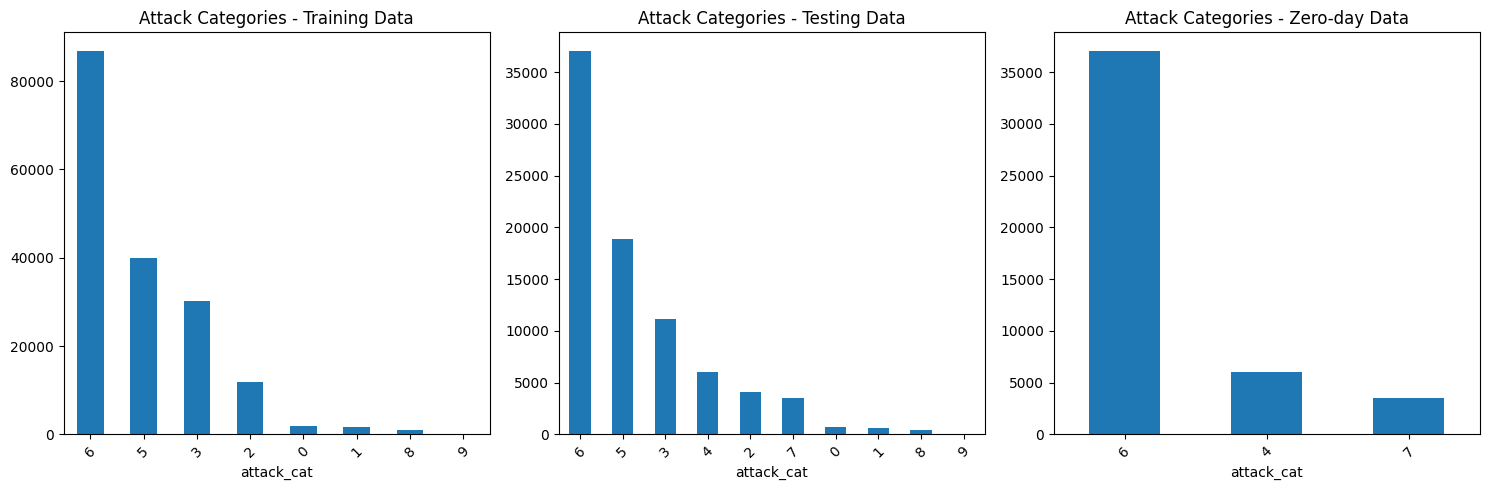


Check presence of Fuzzer and Reconnaissance in training data:
Fuzzer in training data: False
Reconnaissance in training data: False


In [45]:
# attack_cat distribution in each dataset
print("Distribution of attack_cat in training data:")
print(X_train['attack_cat'].value_counts())
print("\n")

print("Distribution of attack_cat in testing data:")
print(X_test['attack_cat'].value_counts())
print("\n")

print("Distribution of attack_cat in zero-day data:")
print(zero_day_data['attack_cat'].value_counts())

# Visualization with bar plot
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
X_train['attack_cat'].value_counts().plot(kind='bar')
plt.title('Attack Categories - Training Data')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
X_test['attack_cat'].value_counts().plot(kind='bar')
plt.title('Attack Categories - Testing Data')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
zero_day_data['attack_cat'].value_counts().plot(kind='bar')
plt.title('Attack Categories - Zero-day Data')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check if Fuzzer and Reconnaissance have been removed from training data
print("\nCheck presence of Fuzzer and Reconnaissance in training data:")
print(f"Fuzzer in training data: {'Fuzzers' in X_train['attack_cat'].values}")
print(f"Reconnaissance in training data: {'Reconnaissance' in X_train['attack_cat'].values}")

In [46]:
# 2. Use a subset of data to increase training speed
sample_size = int(len(X_train) * 0.5)  # Use 50% of the data
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train.iloc[indices].values
y_train_sample = y_train[indices]
print(f"Using {sample_size} samples from {len(X_train)} original data (50.0%)")

Using 86709 samples from 173418 original data (50.0%)


In [47]:
# 3. Set up environments
n_states = 30  # Default number of states for clustering
print(f"\nSetting up environment with {n_states} states...")

# use this for faster training
train_env = NetworkTrafficEnvironment(X_train_sample, y_train_sample, n_states=n_states)

# train_env = NetworkTrafficEnvironment(X_train_sample, y_train_sample, n_states=n_states)
test_env = NetworkTrafficEnvironment(X_test.values, y_test, state_clusters=train_env.state_clusters)
zero_day_env = create_zero_day_environment(train_env, zero_day_data.values, zero_day_labels)


Setting up environment with 30 states...
Performing clustering for state representation...
Cluster distribution: Min=113, Max=7276, Avg=2890.3
Using previously trained clusterer...
Using previously trained clusterer...


In [48]:
# Persiapkan dataset agar kompatibel dengan dimensi model
print("\nMenyiapkan dataset kompatibel...")
prepare_compatible_datasets(feature_count=21)


Menyiapkan dataset kompatibel...
Dataset memiliki 20 fitur, model mengharapkan 21 fitur
Menambahkan 1 dummy features
Dataset memiliki 20 fitur, model mengharapkan 21 fitur
Menambahkan 1 dummy features
Dataset kompatibel telah disimpan dengan 21 fitur:
- preprocessed_binary_test_modified.csv
- preprocessed_zero_day_test_modified.csv


# Training model and evaluate

Evaluating 5 specific hyperparameter schemes
Using 86709 samples from 173418 original data (50.0%)
Performing clustering for state representation...
Cluster distribution: Min=187, Max=11231, Avg=2890.3
Using previously trained clusterer...
Using previously trained clusterer...


Evaluating Schemes:   0%|          | 0/5 [00:00<?, ?it/s]


Scheme 1/5: {'learning_rate': 0.0001, 'epsilon_decay': 0.93, 'batch_size': 32, 'buffer_size': 50000}
Using device: cuda
Model size: 0.03 MB



Training DQN Agent:  13%|█▎        | 2/15 [10:53<1:11:42, 330.97s/it]

Best model saved! Detection rate: 0.9522



Training DQN Agent:  27%|██▋       | 4/15 [21:44<1:00:30, 330.02s/it]

Best model saved! Detection rate: 0.9531



Training DQN Agent:  33%|███▎      | 5/15 [26:46<53:19, 319.94s/it]  

Episode 5/15, Reward: 203825.00, Train Accuracy: 0.9194, Attack Detection Rate: 0.9316, Epsilon: 0.1409, Loss: 4.024376
  RAM: 2506.6MB, GPU: 16.3MB, Buffer: 50000 samples
  Test Accuracy: 0.9461, Test Detection Rate: 0.9531, Test F1: 0.9512



Training DQN Agent:  53%|█████▎    | 8/15 [43:23<38:21, 328.80s/it]

Best model saved! Detection rate: 0.9923



Training DQN Agent:  67%|██████▋   | 10/15 [54:13<27:24, 328.89s/it]

Best model saved! Detection rate: 0.9985
Episode 10/15, Reward: 204743.00, Train Accuracy: 0.9270, Attack Detection Rate: 0.9295, Epsilon: 0.1409, Loss: 3.827104
  RAM: 2530.9MB, GPU: 16.3MB, Buffer: 50000 samples
  Test Accuracy: 0.9891, Test Detection Rate: 0.9985, Test F1: 0.9902



Training DQN Agent:  80%|████████  | 12/15 [1:05:01<16:25, 328.45s/it]

Best model saved! Detection rate: 0.9996



Training DQN Agent: 100%|██████████| 15/15 [1:20:47<00:00, 323.18s/it]

Episode 15/15, Reward: 205049.00, Train Accuracy: 0.9283, Attack Detection Rate: 0.9295, Epsilon: 0.1409, Loss: 3.788516
  RAM: 2555.8MB, GPU: 16.3MB, Buffer: 50000 samples
  Test Accuracy: 0.9968, Test Detection Rate: 0.9994, Test F1: 0.9971
Using model with best detection rate: 0.9996 from episode 11



Evaluating Schemes:  20%|██        | 1/5 [1:22:03<5:28:14, 4923.72s/it]

Best model updated! Zero-day detection rate: 0.9991

Scheme 2/5: {'learning_rate': 0.0003, 'epsilon_decay': 0.95, 'batch_size': 64, 'buffer_size': 50000}
Using device: cuda
Model size: 0.03 MB



Training DQN Agent:  13%|█▎        | 2/15 [11:08<1:13:23, 338.76s/it]

Best model saved! Detection rate: 0.9997



Training DQN Agent:  33%|███▎      | 5/15 [27:33<54:59, 329.97s/it]  

Episode 5/15, Reward: 202325.00, Train Accuracy: 0.9239, Attack Detection Rate: 0.9264, Epsilon: 0.1499, Loss: 3.890817
  RAM: 2583.1MB, GPU: 16.4MB, Buffer: 50000 samples
  Test Accuracy: 0.9885, Test Detection Rate: 0.9887, Test F1: 0.9896



Training DQN Agent:  53%|█████▎    | 8/15 [44:44<39:38, 339.83s/it]


Reducing learning rate to 0.000150



Training DQN Agent:  67%|██████▋   | 10/15 [55:56<28:20, 340.11s/it]

Episode 10/15, Reward: 201758.00, Train Accuracy: 0.9246, Attack Detection Rate: 0.9250, Epsilon: 0.1499, Loss: 3.744575
  RAM: 2620.0MB, GPU: 16.4MB, Buffer: 50000 samples
  Test Accuracy: 0.9763, Test Detection Rate: 0.9612, Test F1: 0.9781



Training DQN Agent:  93%|█████████▎| 14/15 [1:18:20<05:39, 339.84s/it]


Reducing learning rate to 0.000075



Training DQN Agent: 100%|██████████| 15/15 [1:23:33<00:00, 334.21s/it]

Episode 15/15, Reward: 201590.00, Train Accuracy: 0.9243, Attack Detection Rate: 0.9248, Epsilon: 0.1499, Loss: 3.714388
  RAM: 2635.0MB, GPU: 16.4MB, Buffer: 50000 samples
  Test Accuracy: 0.9892, Test Detection Rate: 0.9853, Test F1: 0.9902
Using model with best detection rate: 0.9997 from episode 1



Evaluating Schemes:  40%|████      | 2/5 [2:46:48<4:10:55, 5018.61s/it]


Scheme 3/5: {'learning_rate': 0.0005, 'epsilon_decay': 0.97, 'batch_size': 128, 'buffer_size': 50000}
Using device: cuda
Model size: 0.03 MB



Training DQN Agent:  13%|█▎        | 2/15 [11:47<1:17:38, 358.34s/it]

Best model saved! Detection rate: 0.9998



Training DQN Agent:  33%|███▎      | 5/15 [29:12<58:16, 349.69s/it]  

Episode 5/15, Reward: 202943.00, Train Accuracy: 0.9257, Attack Detection Rate: 0.9267, Epsilon: 0.1468, Loss: 3.910369
  RAM: 2668.2MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9923, Test Detection Rate: 0.9989, Test F1: 0.9931



Training DQN Agent:  53%|█████▎    | 8/15 [47:24<42:02, 360.29s/it]


Reducing learning rate to 0.000250



Training DQN Agent:  67%|██████▋   | 10/15 [59:18<30:02, 360.43s/it]

Episode 10/15, Reward: 203621.00, Train Accuracy: 0.9268, Attack Detection Rate: 0.9275, Epsilon: 0.1468, Loss: 3.698847
  RAM: 2697.7MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9958, Test Detection Rate: 0.9949, Test F1: 0.9962



Training DQN Agent:  93%|█████████▎| 14/15 [1:23:04<06:00, 360.61s/it]


Reducing learning rate to 0.000125



Training DQN Agent: 100%|██████████| 15/15 [1:28:38<00:00, 354.56s/it]

Episode 15/15, Reward: 202421.00, Train Accuracy: 0.9254, Attack Detection Rate: 0.9259, Epsilon: 0.1468, Loss: 3.588068
  RAM: 2718.5MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9954, Test Detection Rate: 0.9951, Test F1: 0.9958
Using model with best detection rate: 0.9998 from episode 1



Evaluating Schemes:  60%|██████    | 3/5 [4:16:39<2:52:56, 5188.32s/it]


Scheme 4/5: {'learning_rate': 0.001, 'epsilon_decay': 0.98, 'batch_size': 256, 'buffer_size': 50000}
Using device: cuda
Model size: 0.03 MB



Training DQN Agent:  13%|█▎        | 2/15 [12:55<1:25:10, 393.12s/it]

Best model saved! Detection rate: 0.9993



Training DQN Agent:  27%|██▋       | 4/15 [26:00<1:12:28, 395.28s/it]

Best model saved! Detection rate: 0.9994



Training DQN Agent:  33%|███▎      | 5/15 [32:11<1:04:24, 386.42s/it]

Episode 5/15, Reward: 201683.00, Train Accuracy: 0.9234, Attack Detection Rate: 0.9255, Epsilon: 0.1497, Loss: 3.835416
  RAM: 2738.9MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9965, Test Detection Rate: 0.9994, Test F1: 0.9968



Training DQN Agent:  67%|██████▋   | 10/15 [1:05:16<33:02, 396.49s/it]


Reducing learning rate to 0.000500
Episode 10/15, Reward: 200819.00, Train Accuracy: 0.9227, Attack Detection Rate: 0.9241, Epsilon: 0.1497, Loss: 3.711526
  RAM: 2758.8MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9953, Test Detection Rate: 0.9991, Test F1: 0.9958



Training DQN Agent: 100%|██████████| 15/15 [1:37:43<00:00, 390.91s/it]

Episode 15/15, Reward: 202235.00, Train Accuracy: 0.9241, Attack Detection Rate: 0.9262, Epsilon: 0.1497, Loss: 3.585407
  RAM: 2783.9MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9941, Test Detection Rate: 0.9966, Test F1: 0.9946
Using model with best detection rate: 0.9994 from episode 3



Evaluating Schemes:  80%|████████  | 4/5 [5:55:35<1:31:23, 5483.61s/it]


Scheme 5/5: {'learning_rate': 0.003, 'epsilon_decay': 0.99, 'batch_size': 512, 'buffer_size': 50000}
Using device: cuda
Model size: 0.03 MB



Training DQN Agent:  13%|█▎        | 2/15 [15:09<1:39:52, 460.96s/it]

Best model saved! Detection rate: 0.9983



Training DQN Agent:  33%|███▎      | 5/15 [38:07<1:16:30, 459.05s/it]

Episode 5/15, Reward: 201230.00, Train Accuracy: 0.9218, Attack Detection Rate: 0.9254, Epsilon: 0.1496, Loss: 3.626036
  RAM: 2811.2MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9914, Test Detection Rate: 0.9910, Test F1: 0.9922



Training DQN Agent:  53%|█████▎    | 8/15 [1:01:49<54:49, 469.87s/it]


Reducing learning rate to 0.001500



Training DQN Agent:  67%|██████▋   | 10/15 [1:17:22<39:09, 469.94s/it]

Episode 10/15, Reward: 201932.00, Train Accuracy: 0.9247, Attack Detection Rate: 0.9253, Epsilon: 0.1496, Loss: 3.546238
  RAM: 2824.9MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9914, Test Detection Rate: 0.9869, Test F1: 0.9921



Training DQN Agent:  93%|█████████▎| 14/15 [1:48:25<07:49, 469.83s/it]


Reducing learning rate to 0.000750



Training DQN Agent: 100%|██████████| 15/15 [1:55:50<00:00, 463.34s/it]

Episode 15/15, Reward: 202784.00, Train Accuracy: 0.9254, Attack Detection Rate: 0.9266, Epsilon: 0.1496, Loss: 3.520262
  RAM: 2854.1MB, GPU: 16.5MB, Buffer: 50000 samples
  Test Accuracy: 0.9953, Test Detection Rate: 0.9931, Test F1: 0.9958
Using model with best detection rate: 0.9983 from episode 1



Evaluating Schemes: 100%|██████████| 5/5 [7:52:37<00:00, 5671.56s/it]



EVALUATION RESULTS OF 5 SCHEMES
Total schemes successfully evaluated: 5
Best parameters: {'learning_rate': 0.0001, 'epsilon_decay': 0.93, 'batch_size': 32, 'buffer_size': 50000}
Best zero-day detection rate: 0.9991

Scheme ranking based on zero-day detection rate:
1. Scheme 1 - Zero-day Recall: 0.9991, F1: 0.9624
2. Scheme 5 - Zero-day Recall: 0.9888, F1: 0.9872
3. Scheme 4 - Zero-day Recall: 0.9835, F1: 0.9765
4. Scheme 3 - Zero-day Recall: 0.9780, F1: 0.9820
5. Scheme 2 - Zero-day Recall: 0.9312, F1: 0.9508

MEMORY FOOTPRINT COMPARISON
  scheme  training_time_seconds  peak_ram_mb  peak_gpu_mb  model_size_mb  final_buffer_size  buffer_size_mb  avg_inference_time_ms  samples_per_second  learning_rate  epsilon_decay  batch_size  buffer_size
Scheme 1            4852.498731  2555.785156    16.325684       0.027115              50000        1.525879               0.275986         3623.366515         0.0001           0.93          32        50000
Scheme 2            5013.141268  2634.96093

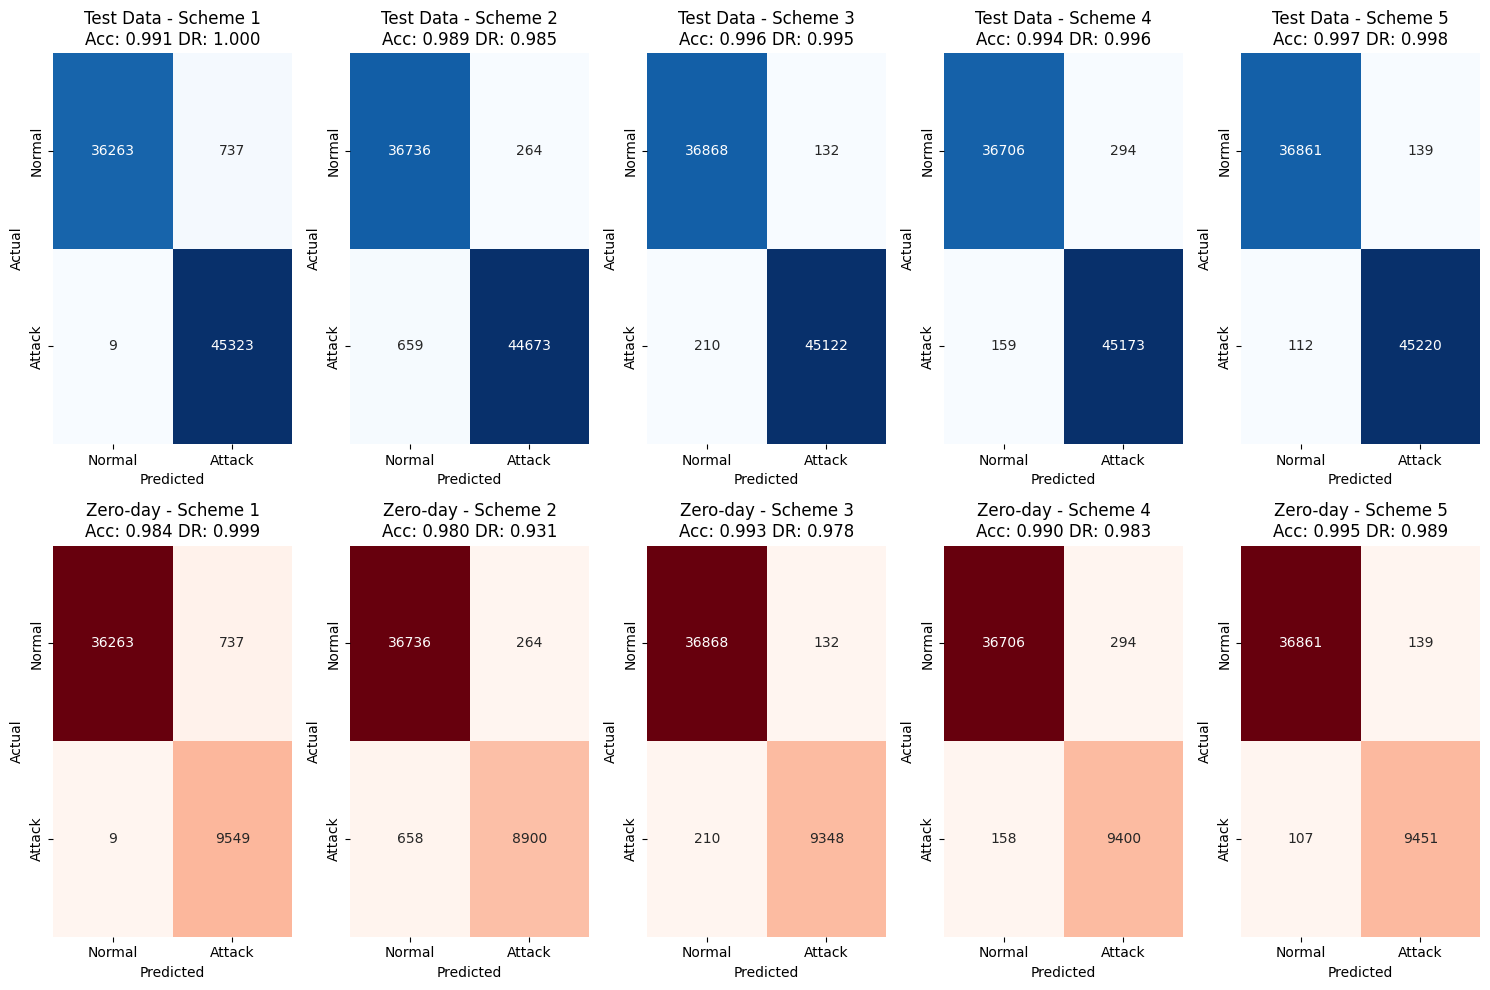

In [49]:
# Train and evaluate the model
results_df, best_agent, best_metrics = specific_scheme_search(
    X_train, y_train, X_test, y_test, zero_day_data, zero_day_labels
)

# Save results
timestamp = time.strftime("%Y%m%d-%H%M%S")
results_df.to_pickle(f'scheme_evaluation_results_{timestamp}.pkl')

# When loading back for visualization
loaded_results = pd.read_pickle(f'scheme_evaluation_results_{timestamp}.pkl')
plot_confusion_matrices(loaded_results)

In [50]:
# Saat training selesai, simpan model
best_agent.save('best_agent_model.pth')

# Muat kembali model dengan dimensi yang benar
loaded_agent = load_dqn_model('best_agent_model.pth', feature_count=21)
print("Model berhasil dimuat kembali untuk verifikasi")


Using device: cuda
Model berhasil dimuat dengan 21 fitur
Model berhasil dimuat kembali untuk verifikasi


Memuat hasil evaluasi...


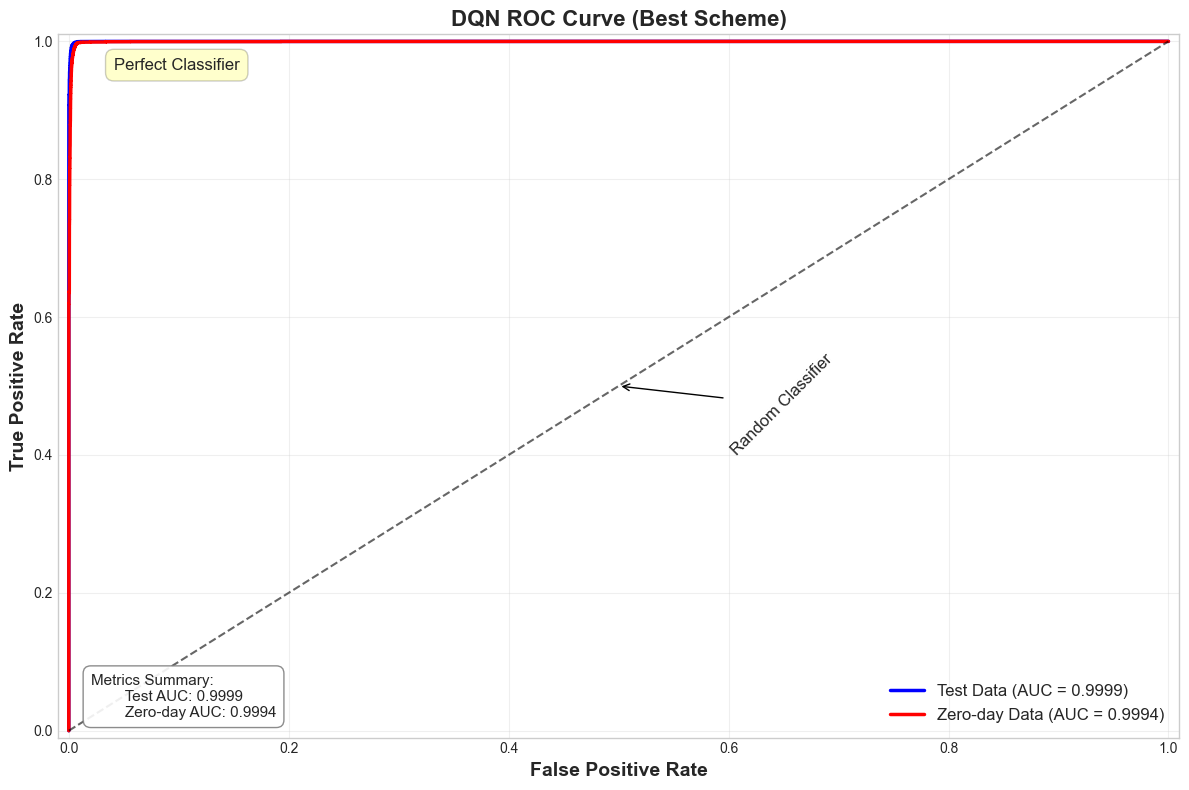

ROC curve telah disimpan ke roc_curve_comparison.png
Test AUC: 0.9999
Zero-day AUC: 0.9994


In [ ]:
# Ganti kode Anda yang menggunakan plot_roc_curve_after_training dengan ini:
results_file = f'scheme_evaluation_results_{timestamp}.pkl'  # Sesuaikan dengan nama file hasil evaluasi Anda
metrics = plot_roc_curve_after_training(results_file, 'roc_curve_comparison.png')

if metrics:
    print(f"Test AUC: {metrics['test_auc']:.4f}")
    print(f"Zero-day AUC: {metrics['zero_day_auc']:.4f}")

Using device: cuda
Model berhasil dimuat dengan 21 fitur
Memuat dataset untuk visualisasi t-SNE...
Mengekstrak fitur dan membuat Q-values...
Menggunakan 500 sampel per kategori
Menghitung Q-values untuk sampel...
Membuat visualisasi t-SNE...


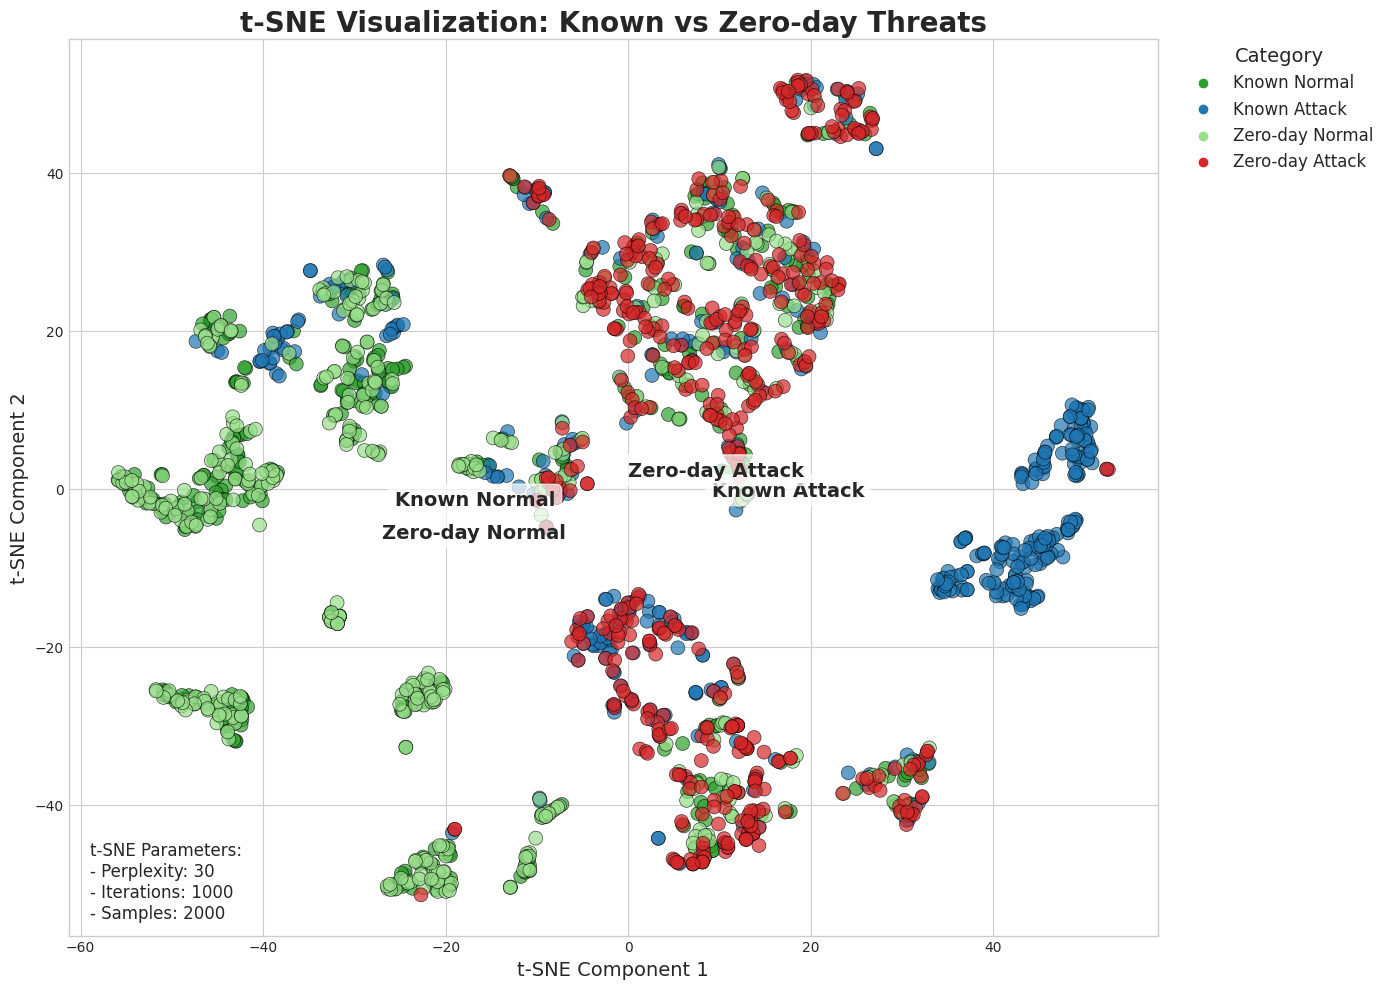


Metrik pemisahan cluster:
- Jarak rata-rata dalam cluster Known Normal: 34.466
- Jarak rata-rata dalam cluster Known Attack: 32.552
- Jarak rata-rata dalam cluster Zero-day Normal: 33.534
- Jarak rata-rata dalam cluster Zero-day Attack: 30.519

Jarak antar pusat cluster:
- Known Normal ke Zero-day Normal: 4.124
- Known Normal ke Zero-day Attack: 26.588
- Known Attack ke Known Normal: 34.276
- Known Attack ke Zero-day Normal: 34.866
- Known Attack ke Zero-day Attack: 8.329
- Zero-day Attack ke Zero-day Normal: 27.666

Jarak antara pusat cluster Known Attack dan Zero-day Attack: 8.329
Interpretasi: Serangan zero-day dan serangan dikenal terpisah jauh dalam representasi model.
Ini menunjukkan model memperlakukan zero-day threats sebagai kategori serangan yang berbeda.


In [52]:
# Pastikan model sudah dimuat dengan benar
best_agent = load_dqn_model('best_agent_model.pth', feature_count=21)

# Buat visualisasi t-SNE
create_tsne_visualization(
    best_agent,
    feature_count=21,  # Sesuaikan dengan jumlah fitur model Anda
    sample_size=2000,  # Jumlah sampel (kurangi jika memori terbatas)
    perplexity=30,     # Parameter t-SNE
    n_iter=1000        # Jumlah iterasi (tingkatkan untuk hasil lebih baik)
)

In [53]:
# Untuk analisis scheme terbaik saja
create_memory_comparison_table(results_df)


DQN MEMORY FOOTPRINT ANALYSIS
                        Metrik DQN (Best Scheme)
       Training Time (seconds)            4852.5
       Training Time (minutes)             80.87
           Peak RAM Usage (MB)            2555.8
          Peak GPU Memory (MB)              16.3
               Model Size (MB)              0.03
            Buffer Memory (MB)               1.5
   Total Memory Footprint (MB)            2572.1
       Avg Inference Time (ms)              0.28
 Inference Speed (samples/sec)            3623.4
Memory Efficiency (samples/MB)              19.4

DETAILED MEMORY ANALYSIS
Best Scheme: Scheme 1
Learning Rate: 0.0001
Batch Size: 32
Buffer Size: 50000

Memory Breakdown:
  - Model Parameters: 0.03 MB
  - Replay Buffer: 1.5 MB
  - Peak RAM Usage: 2555.8 MB
  - Peak GPU Memory: 16.3 MB

Performance Metrics:
  - Training Time: 4852.5 seconds (80.87 minutes)
  - Inference Speed: 3623.4 samples/second
  - Average Inference Time: 0.28 ms per sample


,Metrik,DQN (Best Scheme)
0,Training Time (seconds),4852.5
1,Training Time (minutes),80.87
2,Peak RAM Usage (MB),2555.8
3,Peak GPU Memory (MB),16.3
4,Model Size (MB),0.03
5,Buffer Memory (MB),1.5
6,Total Memory Footprint (MB),2572.1
7,Avg Inference Time (ms),0.28
8,Inference Speed (samples/sec),3623.4
9,Memory Efficiency (samples/MB),19.4


In [54]:
# Untuk perbandingan semua scheme
create_all_schemes_memory_table(results_df)


MEMORY FOOTPRINT COMPARISON - ALL DQN SCHEMES
  Scheme Training Time (min) Peak RAM (MB) Peak GPU (MB) Model Size (MB) Buffer Memory (MB) Total Memory (MB) Inference Time (ms) Inference Speed (samples/sec) Learning Rate Batch Size
Scheme 1               80.87        2555.8          16.3            0.03                1.5            2572.1                0.28                        3623.4        0.0001         32
Scheme 2               83.55        2635.0          16.4            0.03                1.5            2651.4                0.30                        3371.2        0.0003         64
Scheme 3               88.64        2718.5          16.5            0.03                1.5            2735.0                0.28                        3592.0        0.0005        128
Scheme 4               97.73        2783.9          16.5            0.03                1.5            2800.4                0.28                        3612.6         0.001        256
Scheme 5              115.83

,Scheme,Training Time (min),Peak RAM (MB),Peak GPU (MB),Model Size (MB),Buffer Memory (MB),Total Memory (MB),Inference Time (ms),Inference Speed (samples/sec),Learning Rate,Batch Size
0,Scheme 1,80.87,2555.8,16.3,0.03,1.5,2572.1,0.28,3623.4,0.0001,32
1,Scheme 2,83.55,2635.0,16.4,0.03,1.5,2651.4,0.30,3371.2,0.0003,64
2,Scheme 3,88.64,2718.5,16.5,0.03,1.5,2735.0,0.28,3592.0,0.0005,128
3,Scheme 4,97.73,2783.9,16.5,0.03,1.5,2800.4,0.28,3612.6,0.001,256
4,Scheme 5,115.83,2854.1,16.5,0.03,1.5,2870.5,0.30,3348.6,0.003,512


In [55]:
# Display performance comparison in text format
print_scheme_comparison(results_df)

# Display confusion matrix for each scheme in text format
for i in range(len(results_df)):
    print_confusion_matrix(i, is_zeroday=False, results_df=results_df)
    print_confusion_matrix(i, is_zeroday=True, results_df=results_df)

# Save all results to a text file
save_results_to_text(results_df, f'dqn_evaluation_results_{timestamp}.txt')


---------------------PERFORMANCE COMPARISON BETWEEN SCHEMES---------------------

-----------------------------------TEST DATA------------------------------------
Scheme     | Accuracy   | Precision  | Recall     | F1 Score   | FPR        | AUC       
--------------------------------------------------------------------------------
Scheme 1    | 0.9909     | 0.9840     | 0.9998     | 0.9918     | 0.0199     | 0.9999    
Scheme 2    | 0.9888     | 0.9941     | 0.9855     | 0.9898     | 0.0071     | 0.9898    
Scheme 3    | 0.9958     | 0.9971     | 0.9954     | 0.9962     | 0.0036     | 0.9973    
Scheme 4    | 0.9945     | 0.9935     | 0.9965     | 0.9950     | 0.0079     | 0.9991    
Scheme 5    | 0.9970     | 0.9969     | 0.9975     | 0.9972     | 0.0038     | 0.9994    

---------------------------------ZERO-DAY DATA----------------------------------
Scheme     | Accuracy   | Precision  | Recall     | F1 Score   | FPR        | AUC       
---------------------------------------------

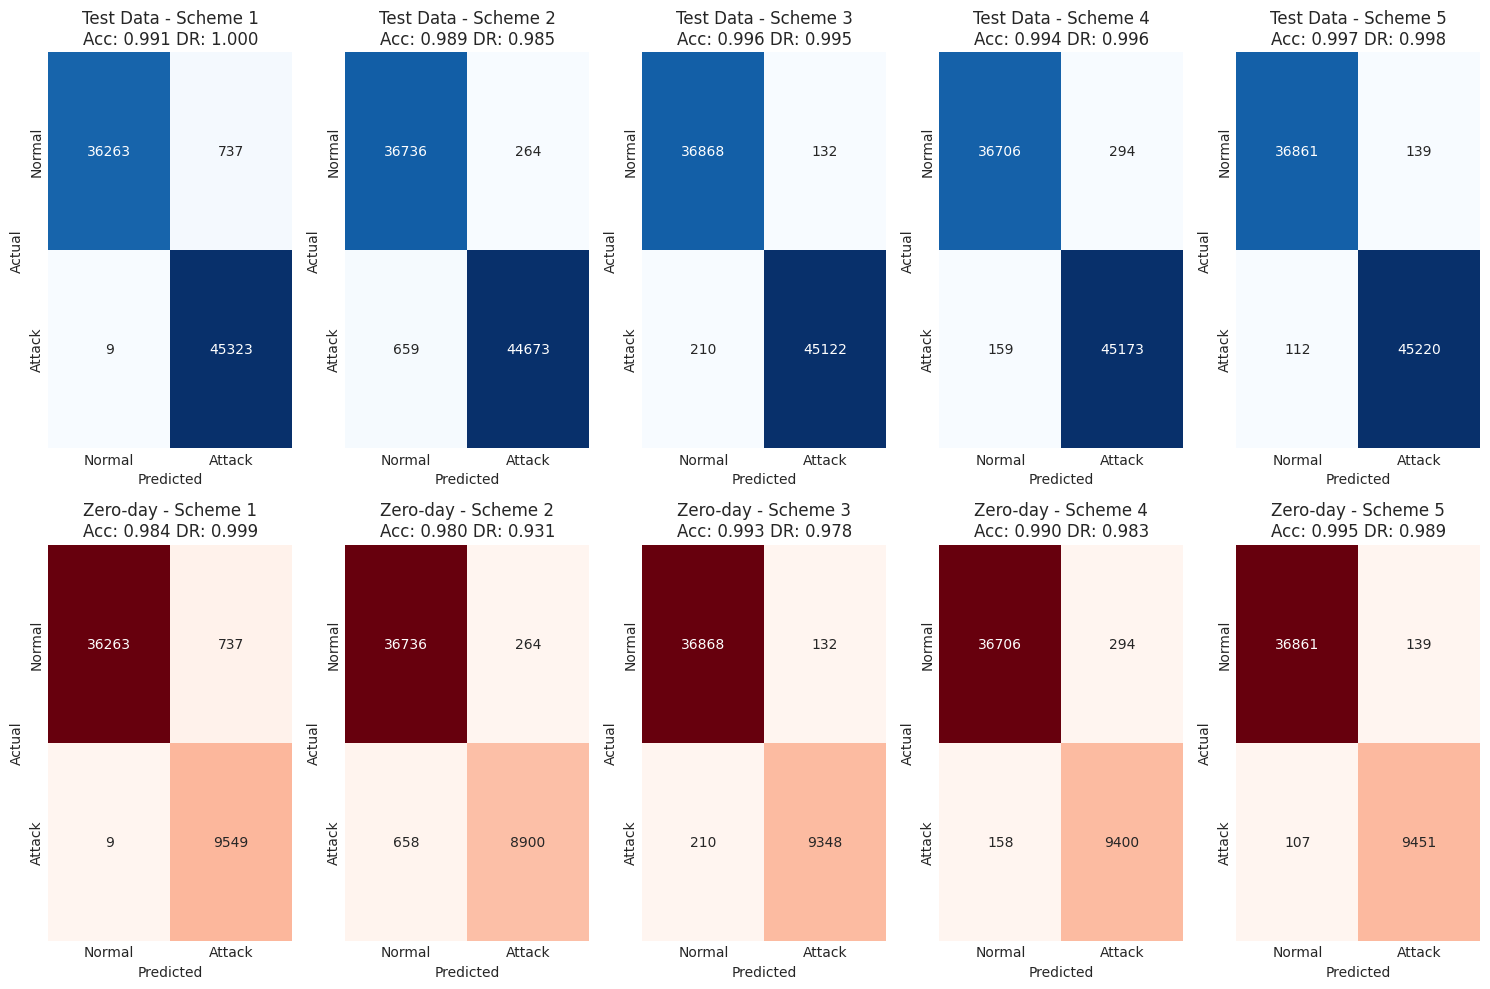

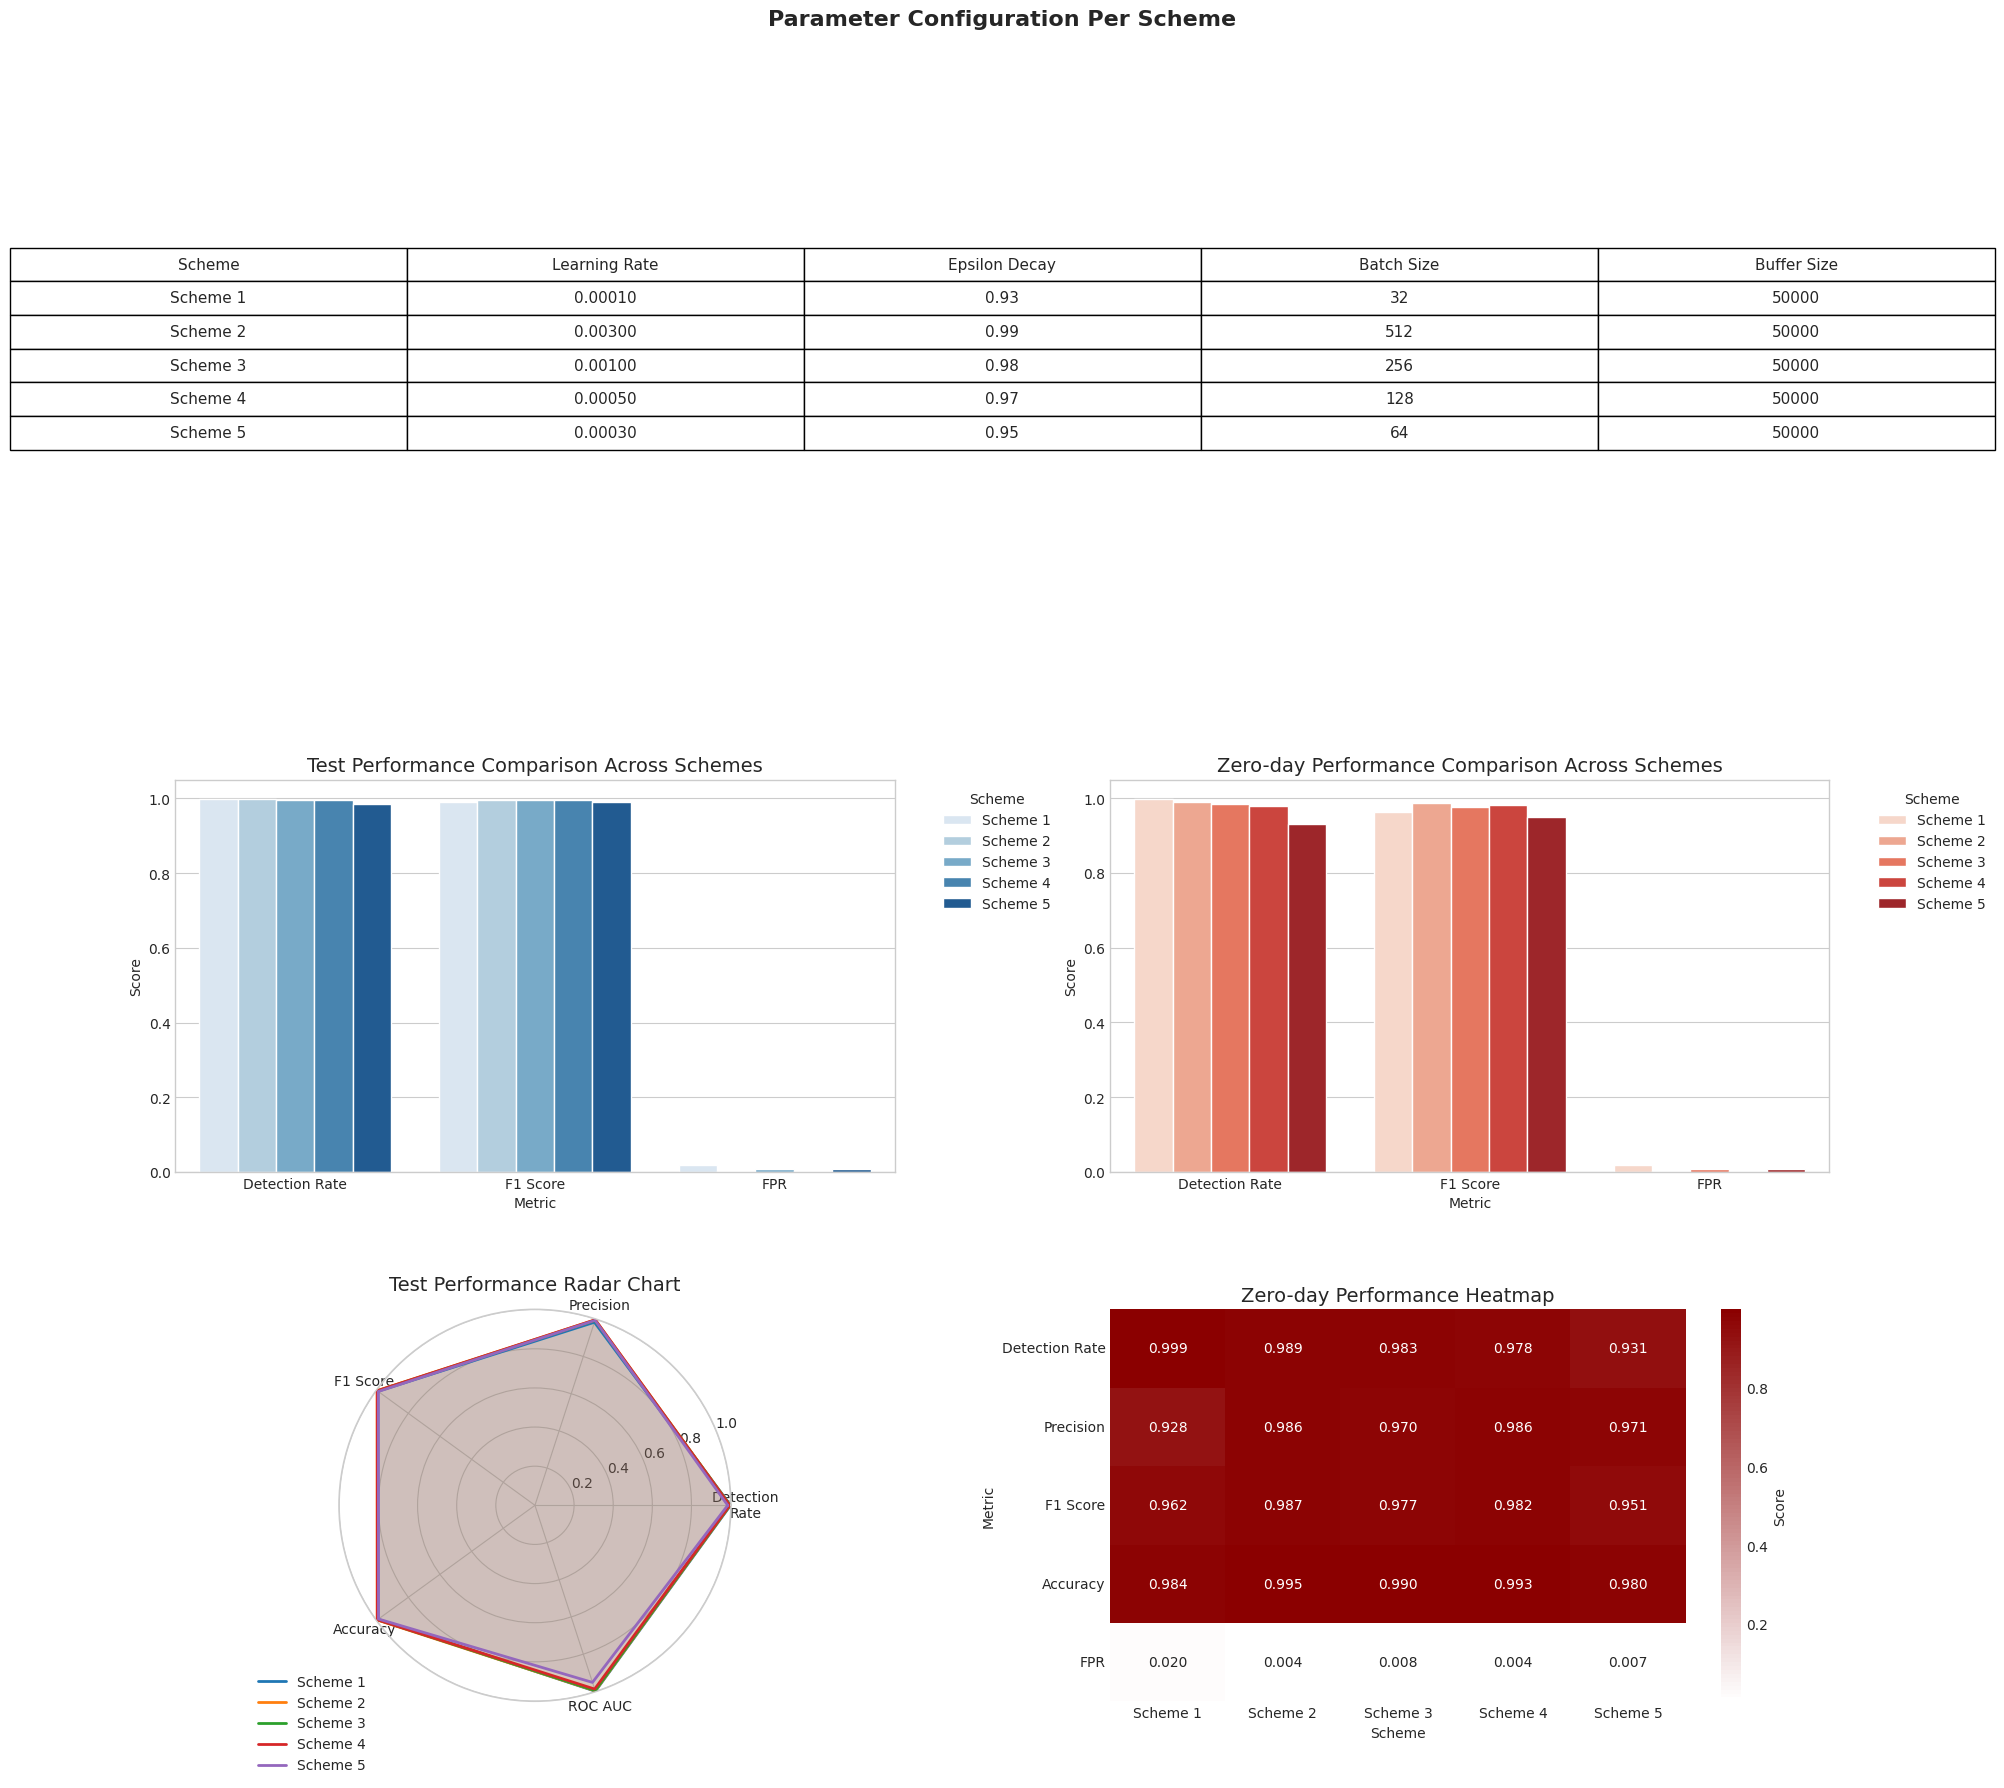

In [56]:
# Visualization of confusion matrices (graphs)
plot_confusion_matrices(results_df)

# Visualization of metric comparisons (graphs)
visualize_model_comparison(results_df)

In [57]:
print(f"\nEntire evaluation process has been completed!")
print(f"- Text results saved at: dqn_evaluation_results_{timestamp}.txt")
print(f"- DataFrame results saved at: scheme_evaluation_results_{timestamp}.pkl")
print(f"- Visualizations have been displayed and can be saved manually")


Entire evaluation process has been completed!
- Text results saved at: dqn_evaluation_results_20250613-184806.txt
- DataFrame results saved at: scheme_evaluation_results_20250613-184806.pkl
- Visualizations have been displayed and can be saved manually



Creating overfitting visualization...


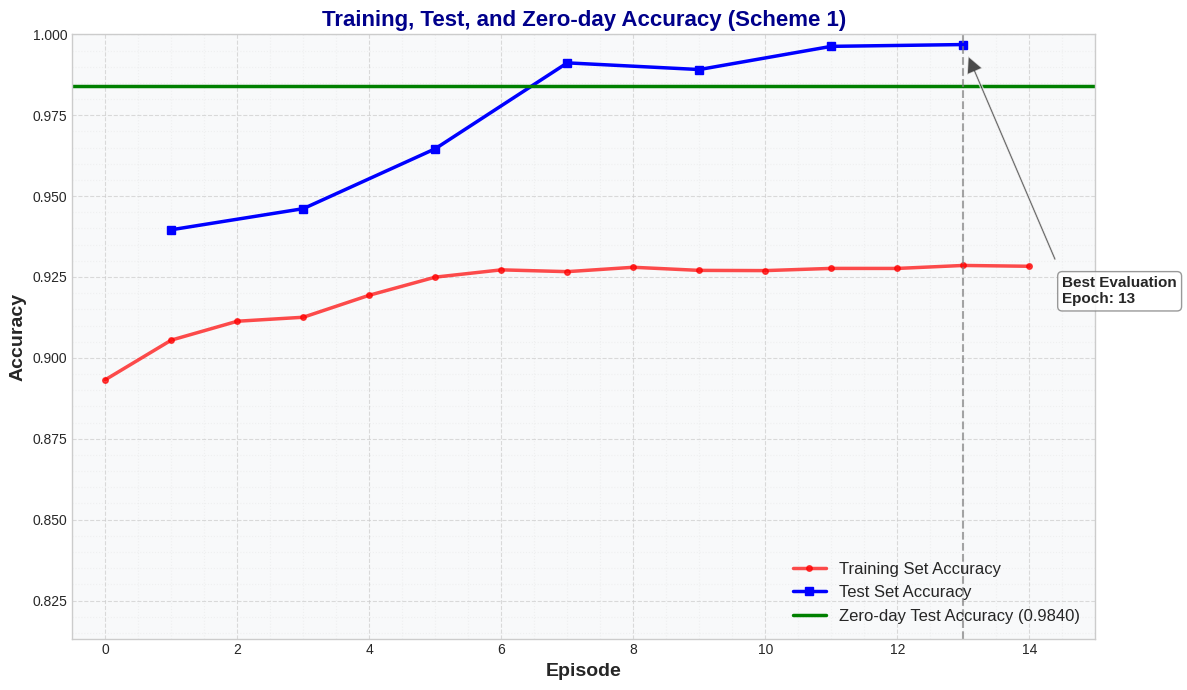

Visualization has been created and saved as 'dqn_training_vs_test_vs_zeroday_accuracy.png'


In [58]:
# Create training vs test accuracy visualization
print("\nCreating overfitting visualization...")
visualize_training_vs_test_accuracy(f'scheme_evaluation_results_{timestamp}.pkl')

print("Visualization has been created and saved as 'dqn_training_vs_test_vs_zeroday_accuracy.png'")


Creating validation performance visualization...


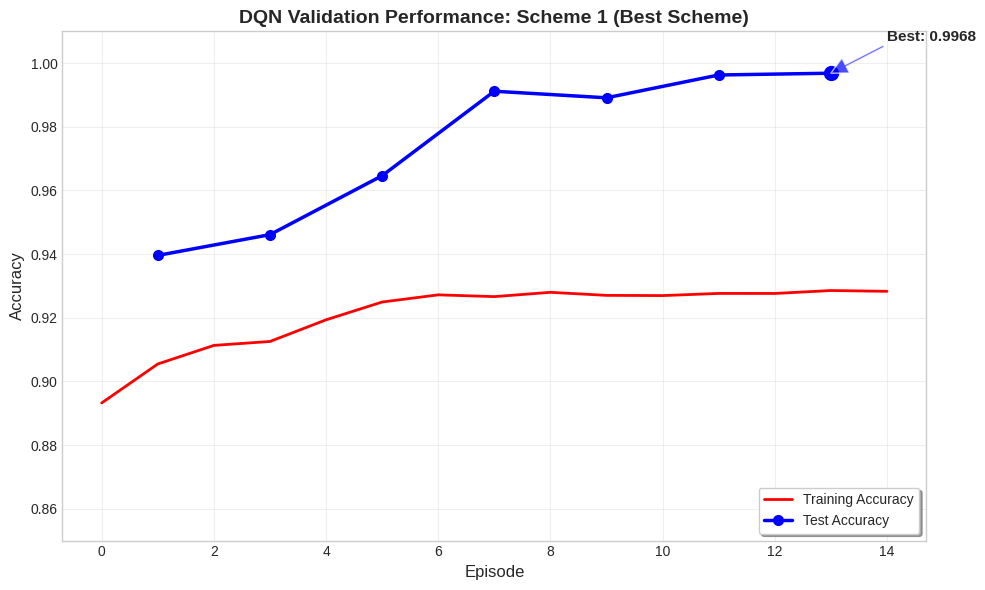

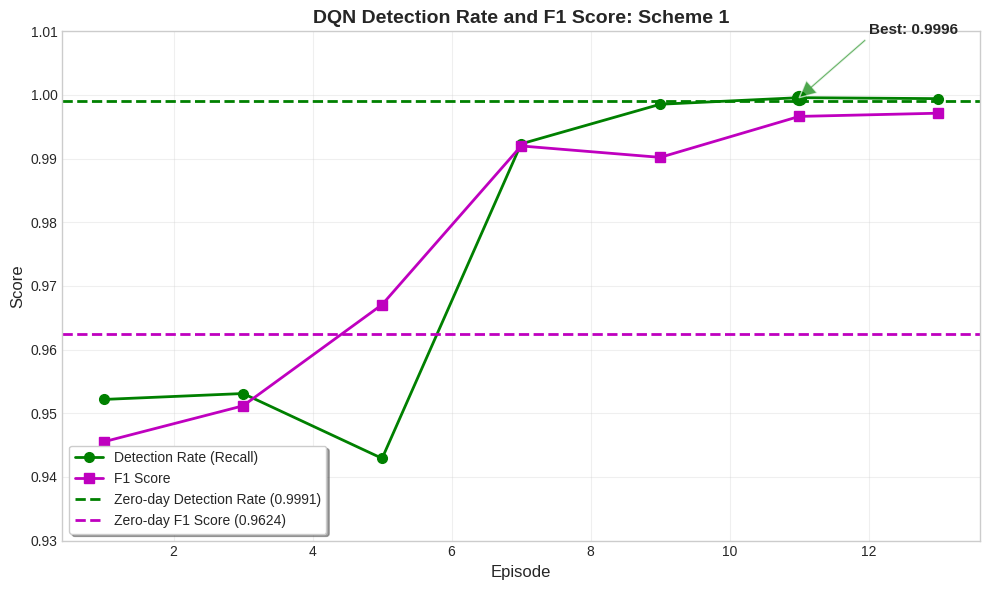

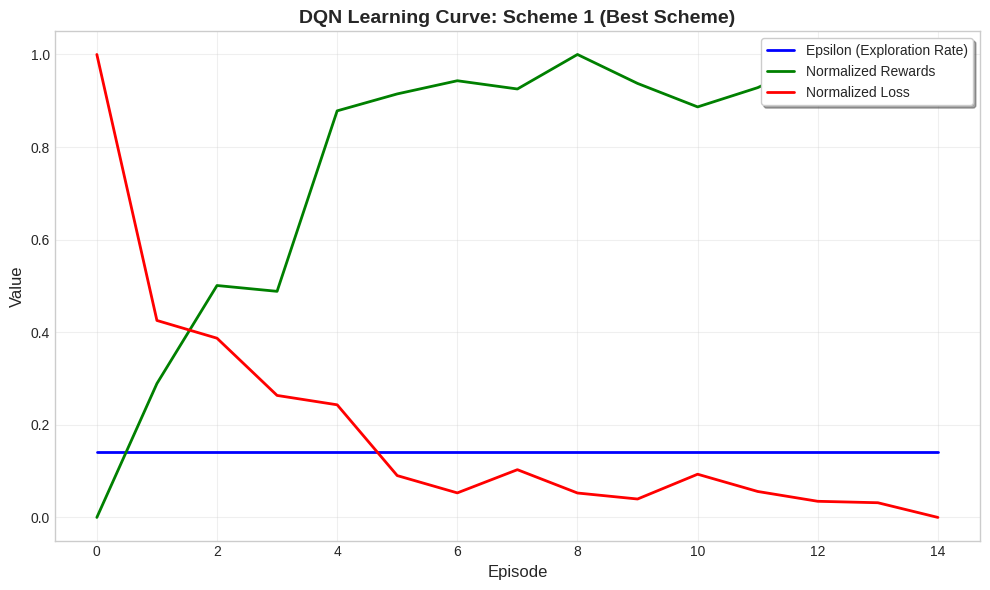

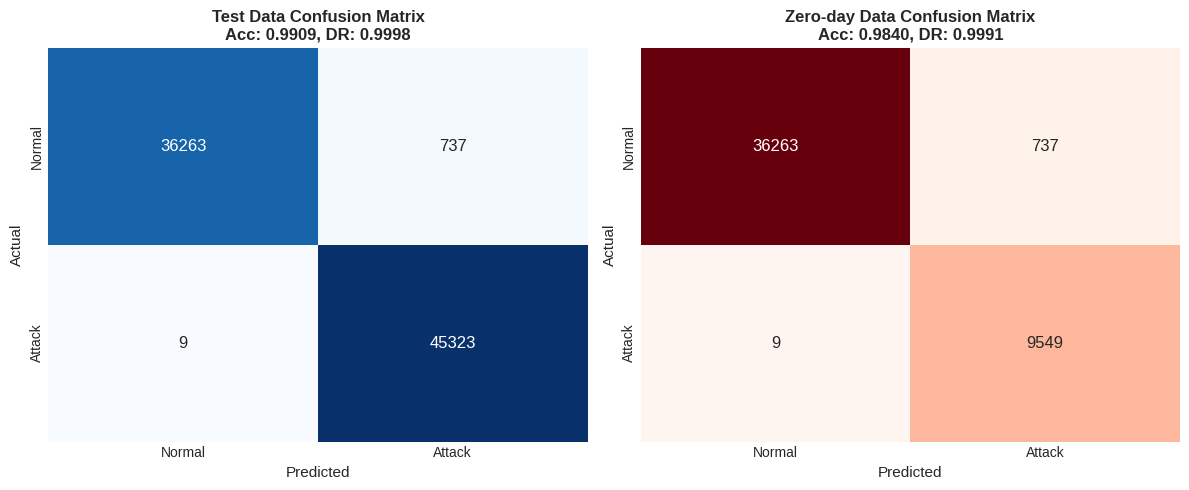

Validation performance visualization has been created and saved


In [59]:
# Ganti cell terakhir (0c63f024) dengan:
# Create training vs test accuracy visualization
print("\nCreating validation performance visualization...")
visualize_dqn_validation_performance(f'scheme_evaluation_results_{timestamp}.pkl')

print("Validation performance visualization has been created and saved")

# shap

Using device: cuda
Model berhasil dimuat dengan 21 fitur
Preparing SHAP analysis for DQN model...
Creating SHAP explainer (this may take a while)...


  0%|          | 0/100 [00:00<?, ?it/s]

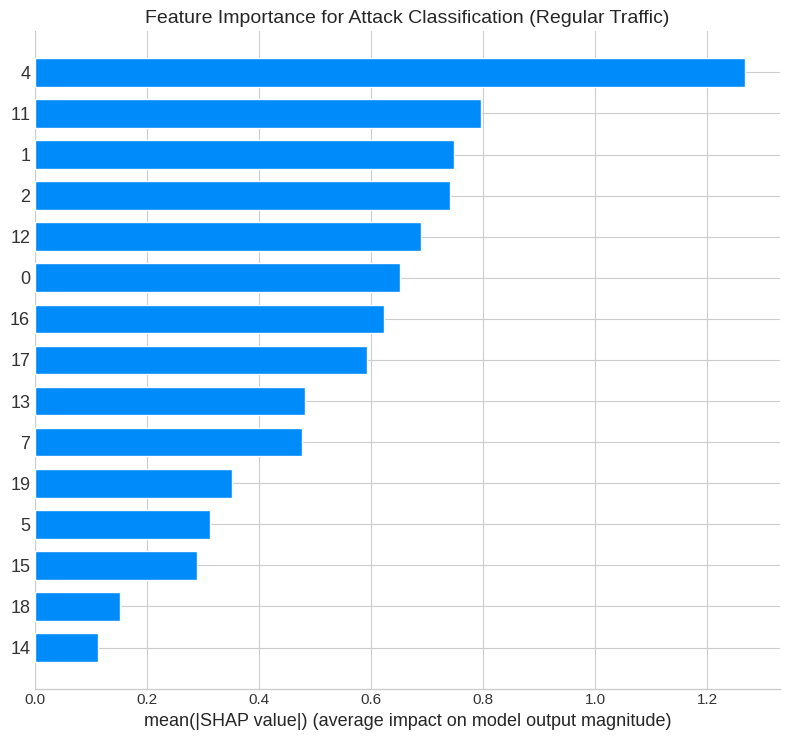

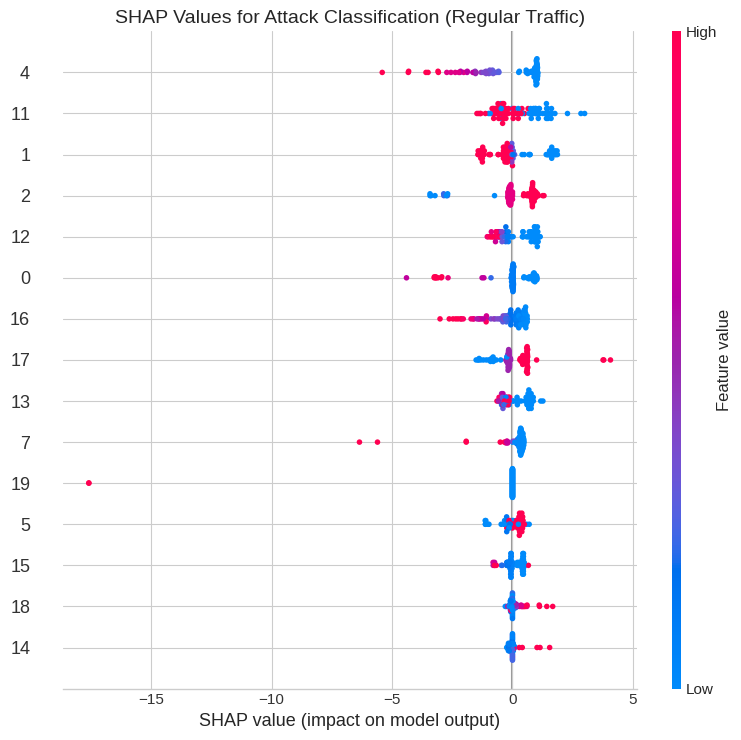

  0%|          | 0/100 [00:00<?, ?it/s]

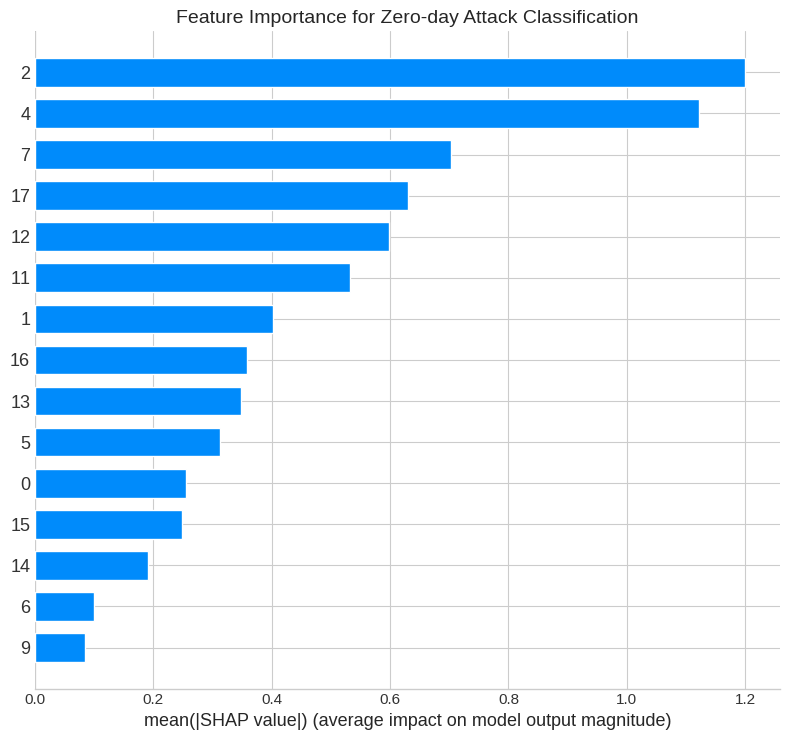

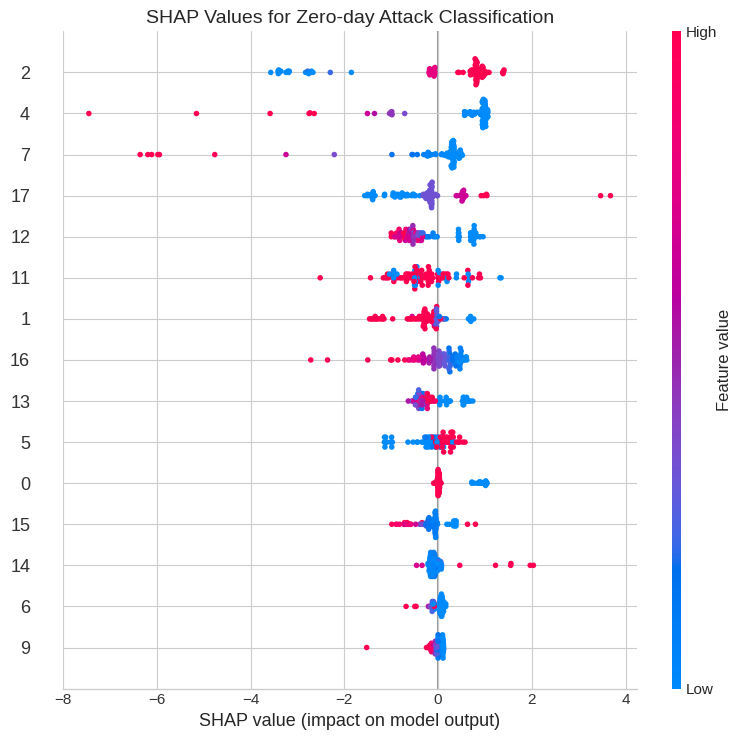

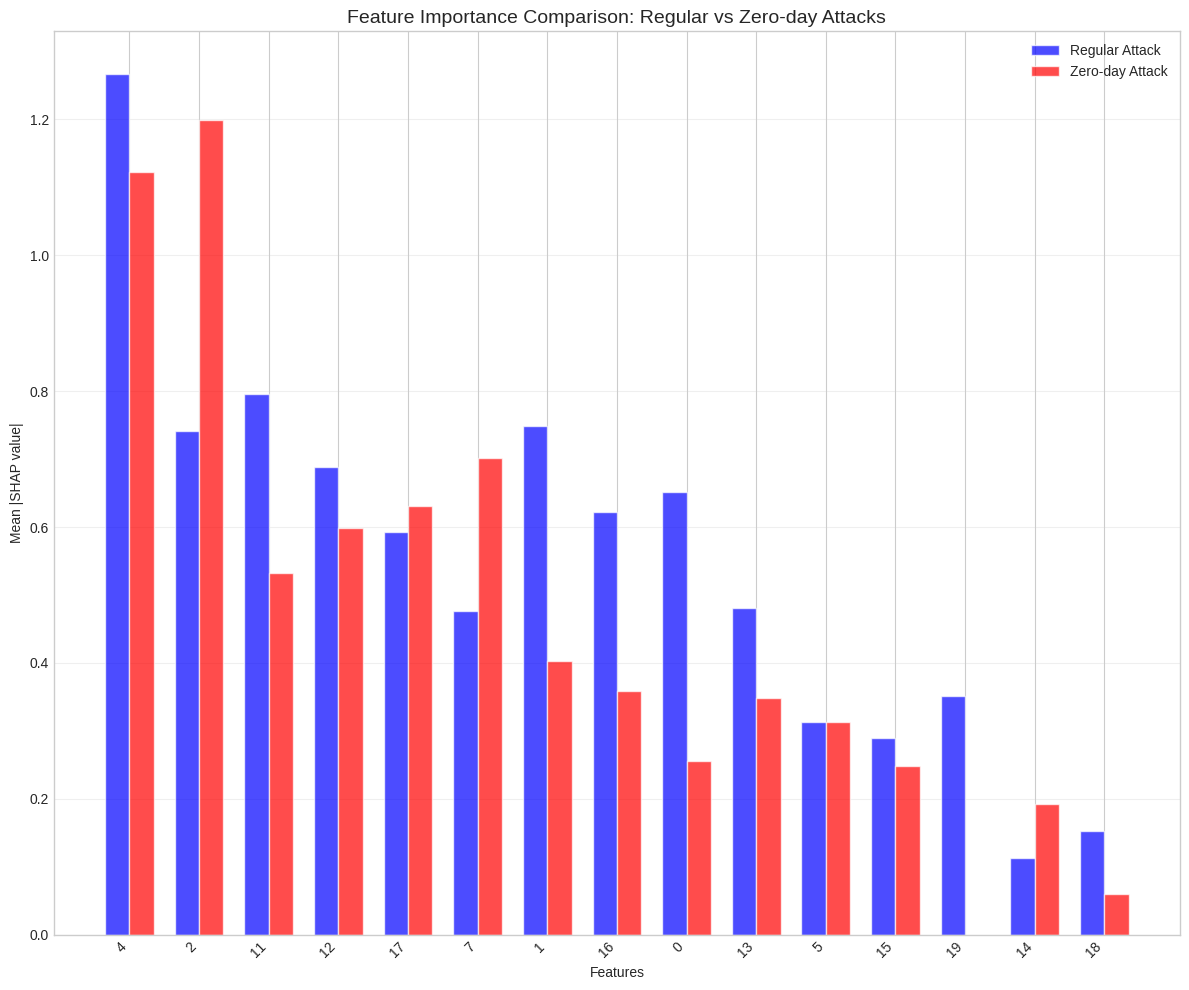

In [60]:
# Load test data
X_test = pd.read_csv('preprocessed_binary_test_modified.csv')
if 'label' in X_test.columns:
    X_test = X_test.drop('label', axis=1)
if 'attack_cat' in X_test.columns:
    X_test = X_test.drop('attack_cat', axis=1)

# Load zero-day data
zero_day_data = pd.read_csv('preprocessed_zero_day_test_modified.csv')
if 'label' in zero_day_data.columns:
    zero_day_data = zero_day_data.drop('label', axis=1)
if 'attack_cat' in zero_day_data.columns:
    zero_day_data = zero_day_data.drop('attack_cat', axis=1)

# Load your best agent
best_agent = load_dqn_model('best_agent_model.pth', feature_count=21)

# Analyze with SHAP
analyze_dqn_with_shap(
    best_agent,
    X_test,
    X_zero_day=zero_day_data,
    n_samples=50,  # Reduce for faster computation
    max_display=15
)